# Diabetes Risk Identification and Prediction (DRIP)

# About the Dataset
**Selected Variables Encoding Information**:  https://www.cdc.gov/pcd/issues/2019/19_0109.htm

**Codebook**: https://www.cdc.gov/brfss/annual_data/2015/pdf/codebook15_llcp.pdf

# Imports

In [177]:
# Data Handling and Manipulation
import os
import json
import math
import pickle
import pandas as pd
from scipy.stats import pointbiserialr, spearmanr
from sklearn.utils import resample

# Data Visualization
import sweetviz as sv
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display, Markdown

# Warning Handling
import warnings
from sklearn.exceptions import DataConversionWarning

# Machine Learning Models
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from catboost import CatBoostClassifier, Pool, cv
import xgboost as xgb
from pytorch_tabnet.tab_model import TabNetClassifier

# Model Selection and Evaluation
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, GridSearchCV, cross_val_score
from sklearn.metrics import (
    classification_report, 
    roc_auc_score, 
    roc_curve, 
    confusion_matrix, 
    precision_recall_curve, 
    auc, 
    precision_score, 
    recall_score, 
    f1_score, 
    accuracy_score
)

# Preprocessing and Pipelines
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.pipeline import Pipeline

# Hyperparameter Optimization
import optuna
from optuna.samplers import RandomSampler

# Hierarchical Clustering
from scipy.cluster.hierarchy import linkage, leaves_list

# Data Fetching (Specific to UCI ML Repository)
from ucimlrepo import fetch_ucirepo

# Suppress specific warnings
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

import re
from sklearn.base import BaseEstimator, ClassifierMixin


from onnx.helper import get_attribute_value
from skl2onnx import update_registered_converter
from skl2onnx.common.shape_calculator import calculate_linear_classifier_output_shapes
from skl2onnx.common.data_types import Int64TensorType, guess_tensor_type
from skl2onnx._parse import _apply_zipmap, _get_sklearn_operator_name
from catboost.utils import convert_to_onnx_object
import onnxruntime as rt
import numpy as np

from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType


# Data Acquisition and Loading

In [2]:
data_dir = "data"  # You can change this to your preferred directory
feature_path = os.path.join(data_dir, "cdc_diabetes_data_features.pkl")
target_path = os.path.join(data_dir, "cdc_diabetes_data_targets.pkl")
metadata_path = os.path.join(data_dir, "cdc_diabetes_data_metadata.json")
variables_path = os.path.join(data_dir, "cdc_diabetes_data_variables.pkl")  # Changed to .pkl for pickle

def load_dataset():
    # Ensure the directory exists
    if not os.path.exists(data_dir):
        os.makedirs(data_dir)
    
    # Check if the dataset is already downloaded and saved locally
    if not (os.path.exists(feature_path) and os.path.exists(target_path) and 
            os.path.exists(metadata_path) and os.path.exists(variables_path)):
        
        # Assuming fetch_ucirepo is a function that downloads the dataset
        cdc_diabetes_health_indicators = fetch_ucirepo(id=891)
        display(cdc_diabetes_health_indicators.keys())
        
        # Save the features, targets, metadata, and variables locally
        cdc_diabetes_health_indicators.data.features.to_pickle(feature_path)
        cdc_diabetes_health_indicators.data.targets.to_pickle(target_path)
        
        # Serialize metadata using JSON
        metadata = cdc_diabetes_health_indicators.metadata
        with open(metadata_path, 'w') as f:
            json.dump(metadata, f)
        
        # Serialize variables using pickle
        variables = cdc_diabetes_health_indicators.variables
        with open(variables_path, 'wb') as f:
            pickle.dump(variables, f)
        
        print("Downloaded and saved the dataset locally.")
        features = cdc_diabetes_health_indicators.data.features
        targets = cdc_diabetes_health_indicators.data.targets

    else:
        # Load the features, targets, metadata, and variables from local storage
        features = pd.read_pickle(feature_path)
        targets = pd.read_pickle(target_path)
        
        with open(metadata_path, 'r') as f:
            metadata = json.load(f)
        
        with open(variables_path, 'rb') as f:
            variables = pickle.load(f)
        
        print("Loaded dataset from local storage.")

    return features, targets, metadata, variables

# Use the function to load your dataset
X, y, metadata, variables = load_dataset()

# Display metadata and variables to ensure they're correctly loaded
print("Metadata:", metadata)
display("Variables:", variables)
from sklearn.metrics import roc_auc_score, roc_curve, classification_report, confusion_matrix, accuracy_score

import numpy as np

Loaded dataset from local storage.
Metadata: {'uci_id': 891, 'name': 'CDC Diabetes Health Indicators', 'repository_url': 'https://archive.ics.uci.edu/dataset/891/cdc+diabetes+health+indicators', 'data_url': 'https://archive.ics.uci.edu/static/public/891/data.csv', 'abstract': 'The Diabetes Health Indicators Dataset contains healthcare statistics and lifestyle survey information about people in general along with their diagnosis of diabetes. The 35 features consist of some demographics, lab test results, and answers to survey questions for each patient. The target variable for classification is whether a patient has diabetes, is pre-diabetic, or healthy. ', 'area': 'Health and Medicine', 'tasks': ['Classification'], 'characteristics': ['Tabular', 'Multivariate'], 'num_instances': 253680, 'num_features': 21, 'feature_types': ['Categorical', 'Integer'], 'demographics': ['Sex', 'Age', 'Education Level', 'Income'], 'target_col': ['Diabetes_binary'], 'index_col': ['ID'], 'has_missing_values'

'Variables:'

name     role     type      demographic  \
0                     ID       ID  Integer             None   
1        Diabetes_binary   Target   Binary             None   
2                 HighBP  Feature   Binary             None   
3               HighChol  Feature   Binary             None   
4              CholCheck  Feature   Binary             None   
5                    BMI  Feature  Integer             None   
6                 Smoker  Feature   Binary             None   
7                 Stroke  Feature   Binary             None   
8   HeartDiseaseorAttack  Feature   Binary             None   
9           PhysActivity  Feature   Binary             None   
10                Fruits  Feature   Binary             None   
11               Veggies  Feature   Binary             None   
12     HvyAlcoholConsump  Feature   Binary             None   
13         AnyHealthcare  Feature   Binary             None   
14           NoDocbcCost  Feature   Binary             None   
15               GenHlth  Feature  Integer             None   
16              MentHlth  Feature  Integer             None   
17              PhysHlth  Feature  Integer             None   
18              DiffWalk  Feature   Binary             None   
19                   Sex  Feature   Binary              Sex   
20                   Age  Feature  Integer              Age   
21             Education  Feature  Integer  Education Level   
22                Income  Feature  Integer           Income   

                                          description units missing_values  
0                                          Patient ID  None             no  
1         0 = no diabetes 1 = prediabetes or diabetes  None             no  
2                          0 = no high BP 1 = high BP  None             no  
3        0 = no high cholesterol 1 = high cholesterol  None             no  
4   0 = no cholesterol check in 5 years 1 = yes ch...  None             no  
5                                     Body Mass Index  None             no  
6   Have you smoked at least 100 cigarettes in you...  None             no  
7        (Ever told) you had a stroke. 0 = no 1 = yes  None             no  
8   coronary heart disease (CHD) or myocardial inf...  None             no  
9   physical activity in past 30 days - not includ...  None             no  
10  Consume Fruit 1 or more times per day 0 = no 1...  None             no  
11  Consume Vegetables 1 or more times per day 0 =...  None             no  
12  Heavy drinkers (adult men having more than 14 ...  None             no  
13  Have any kind of health care coverage, includi...  None             no  
14  Was there a time in the past 12 months when yo...  None             no  
15  Would you say that in general your health is: ...  None             no  
16  Now thinking about your mental health, which i...  None             no  
17  Now thinking about your physical health, which...  None             no  
18  Do you have serious difficulty walking or clim...  None             no  
19                                0 = female 1 = male  None             no  
20  13-level age category (_AGEG5YR see codebook) ...  None             no  
21  Education level (EDUCA see codebook) scale 1-6...  None             no  
22  Income scale (INCOME2 see codebook) scale 1-8 ...  None             no

In [3]:
display(X)

HighBP  HighChol  CholCheck  BMI  Smoker  Stroke  \
0            1         1          1   40       1       0   
1            0         0          0   25       1       0   
2            1         1          1   28       0       0   
3            1         0          1   27       0       0   
4            1         1          1   24       0       0   
...        ...       ...        ...  ...     ...     ...   
253675       1         1          1   45       0       0   
253676       1         1          1   18       0       0   
253677       0         0          1   28       0       0   
253678       1         0          1   23       0       0   
253679       1         1          1   25       0       0   

        HeartDiseaseorAttack  PhysActivity  Fruits  Veggies  ...  \
0                          0             0       0        1  ...   
1                          0             1       0        0  ...   
2                          0             0       1        0  ...   
3                          0             1       1        1  ...   
4                          0             1       1        1  ...   
...                      ...           ...     ...      ...  ...   
253675                     0             0       1        1  ...   
253676                     0             0       0        0  ...   
253677                     0             1       1        0  ...   
253678                     0             0       1        1  ...   
253679                     1             1       1        0  ...   

        AnyHealthcare  NoDocbcCost  GenHlth  MentHlth  PhysHlth  DiffWalk  \
0                   1            0        5        18        15         1   
1                   0            1        3         0         0         0   
2                   1            1        5        30        30         1   
3                   1            0        2         0         0         0   
4                   1            0        2         3         0         0   
...               ...          ...      ...       ...       ...       ...   
253675              1            0        3         0         5         0   
253676              1            0        4         0         0         1   
253677              1            0        1         0         0         0   
253678              1            0        3         0         0         0   
253679              1            0        2         0         0         0   

        Sex  Age  Education  Income  
0         0    9          4       3  
1         0    7          6       1  
2         0    9          4       8  
3         0   11          3       6  
4         0   11          5       4  
...     ...  ...        ...     ...  
253675    1    5          6       7  
253676    0   11          2       4  
253677    0    2          5       2  
253678    1    7          5       1  
253679    0    9          6       2  

[253680 rows x 21 columns]

In [4]:
display(y)

Diabetes_binary
0                     0
1                     0
2                     0
3                     0
4                     0
...                 ...
253675                0
253676                1
253677                0
253678                0
253679                1

[253680 rows x 1 columns]

# SweetViz

                                             |          | [  0%]   00:00 -> (? left)


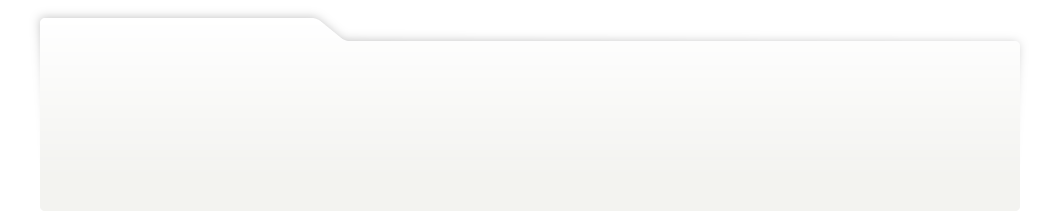
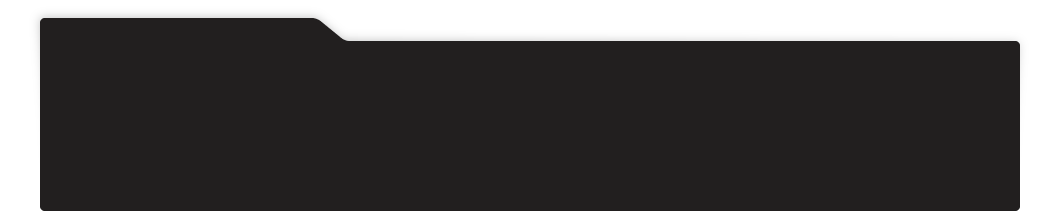
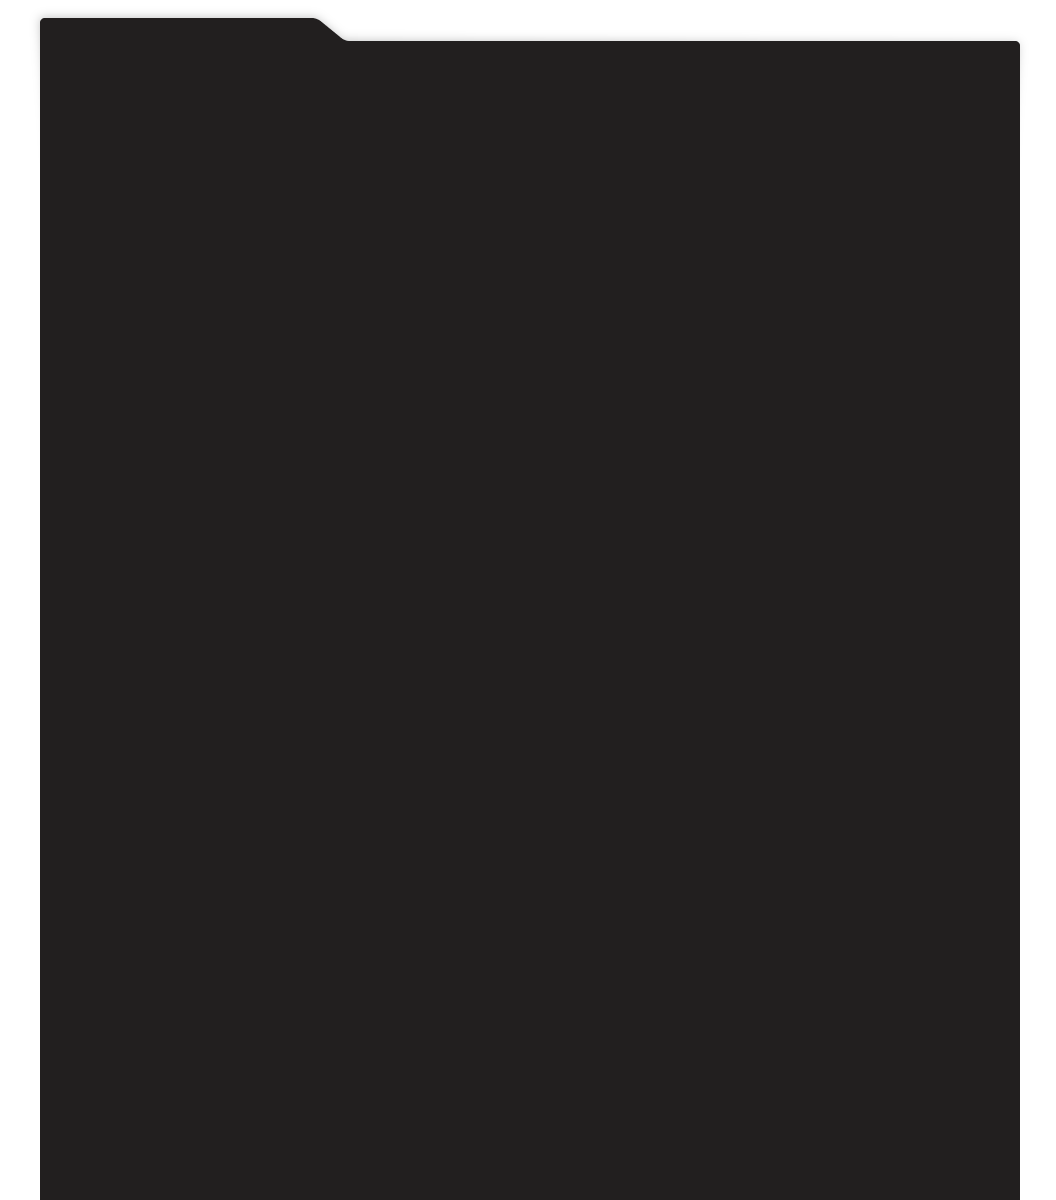
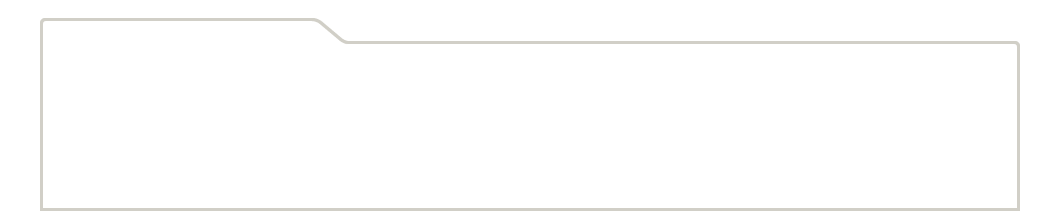
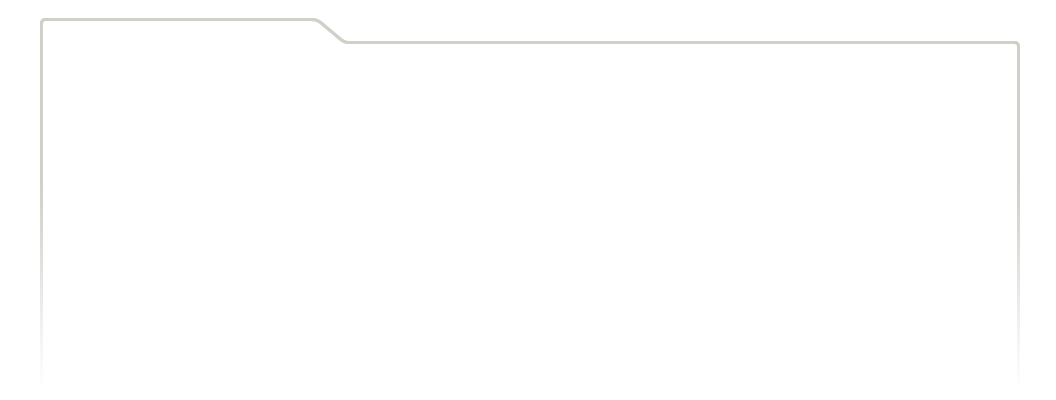
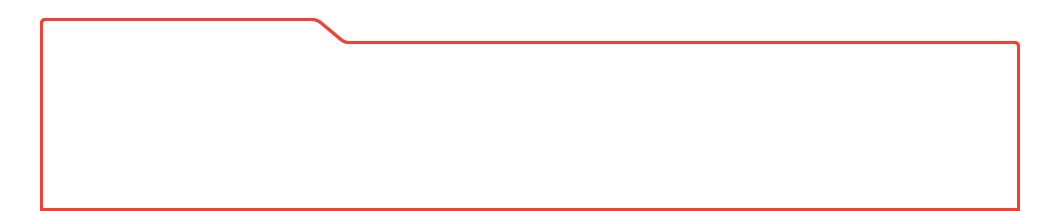
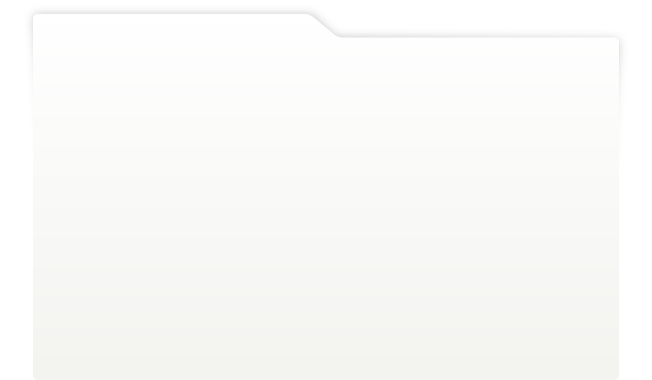
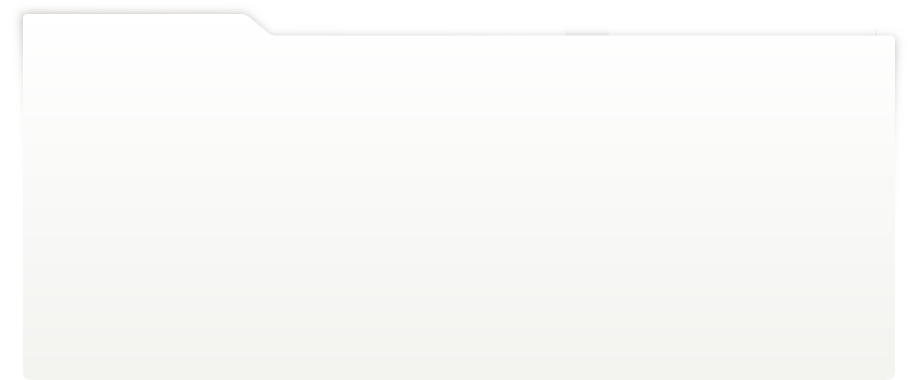
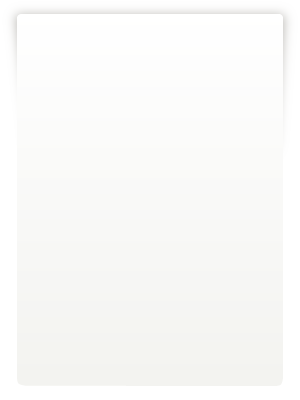
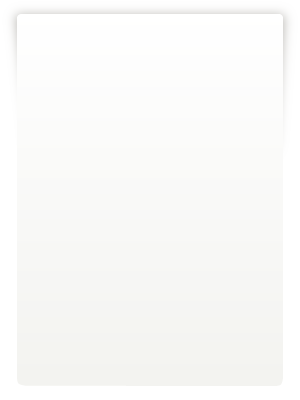
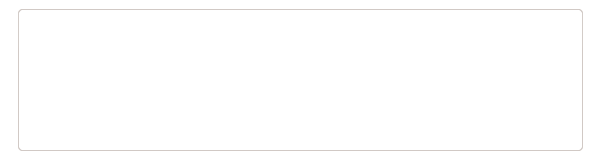
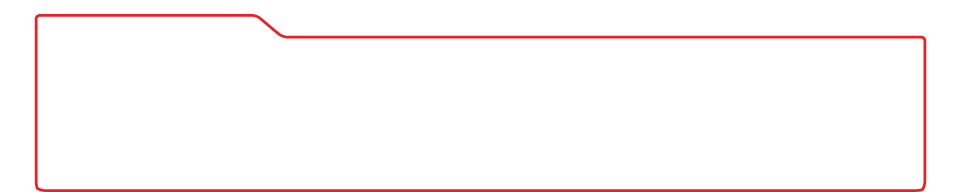
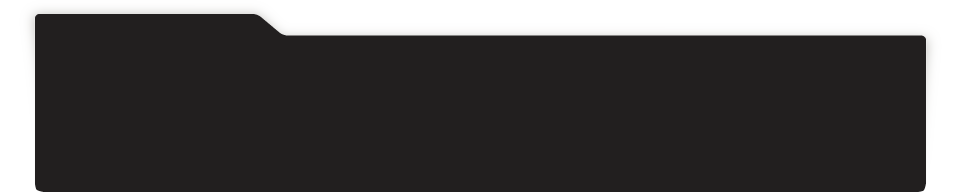
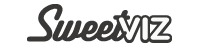
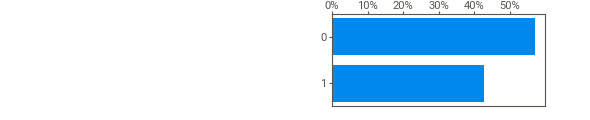
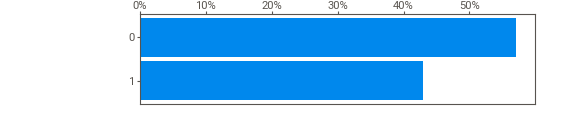
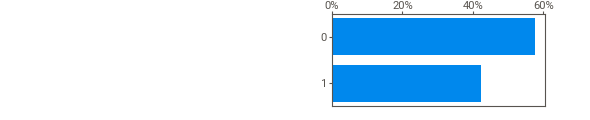
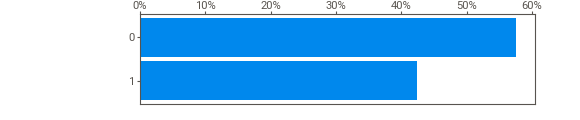
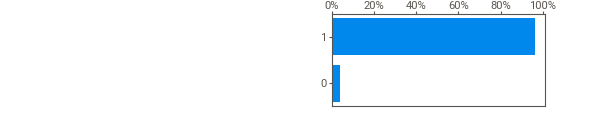
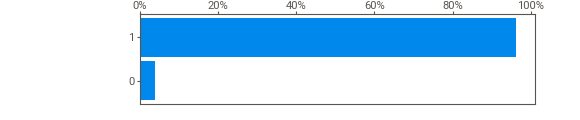
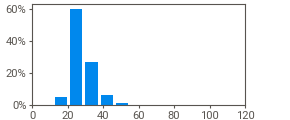
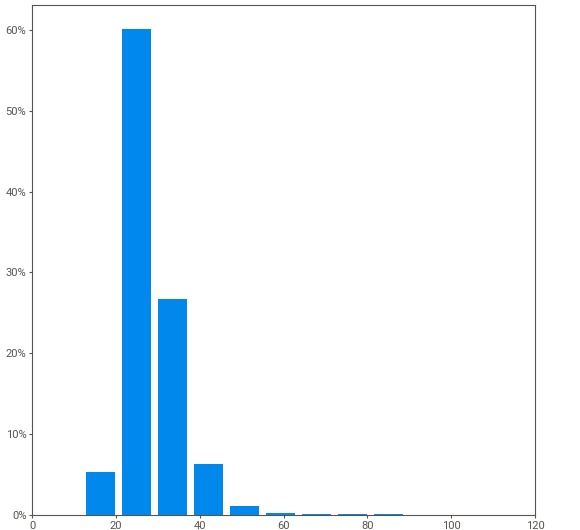
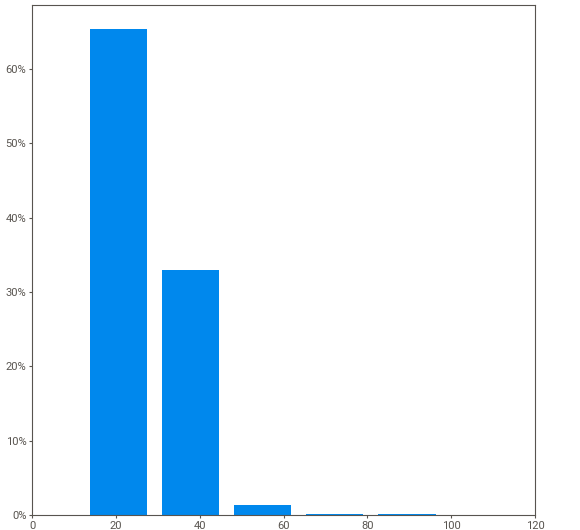
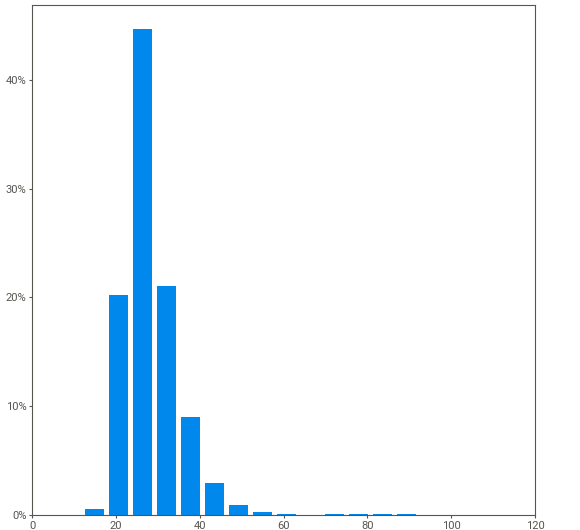
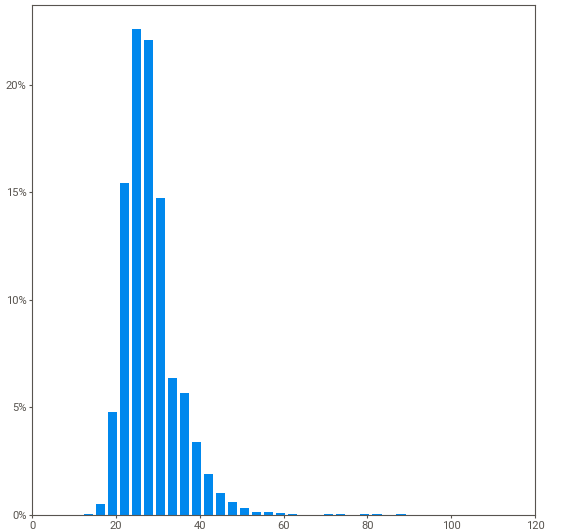
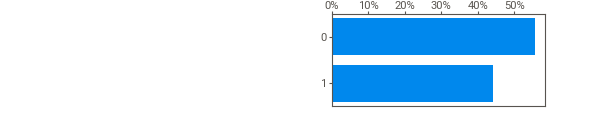
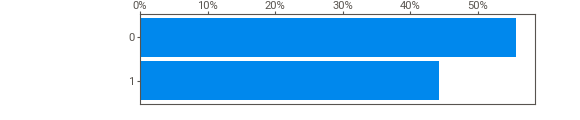
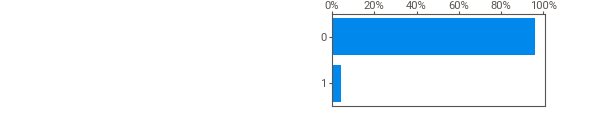
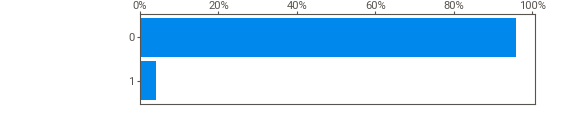
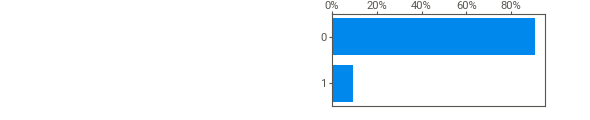
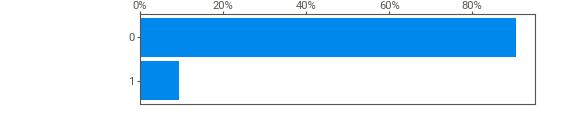
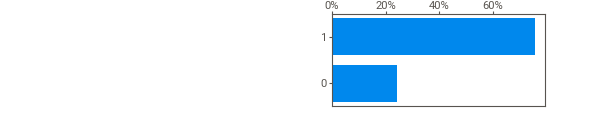
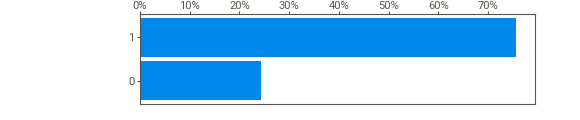
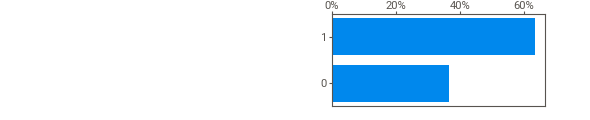
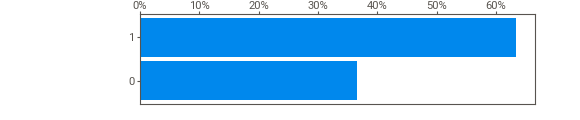
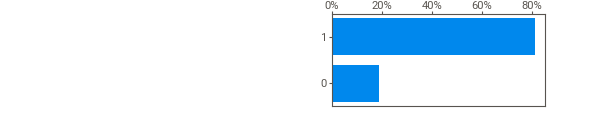
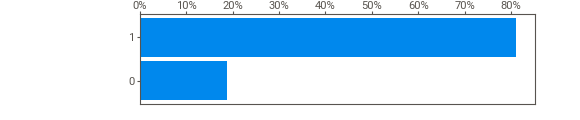
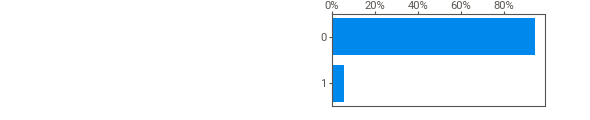
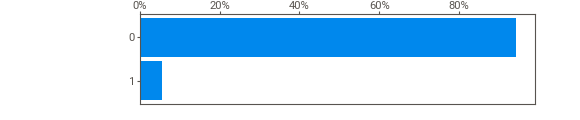
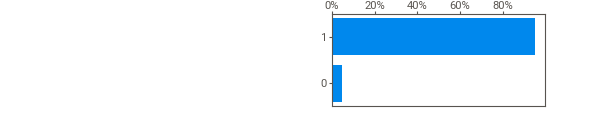
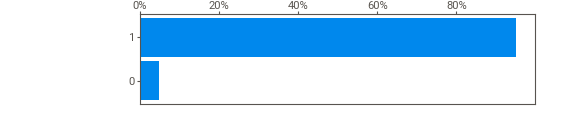
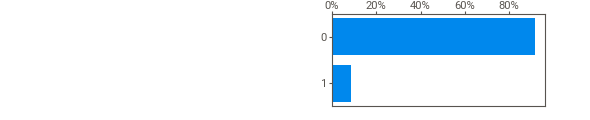
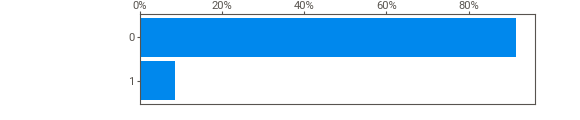
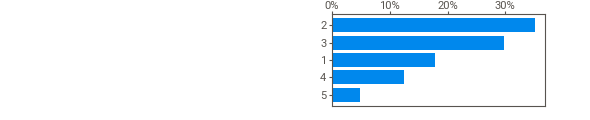
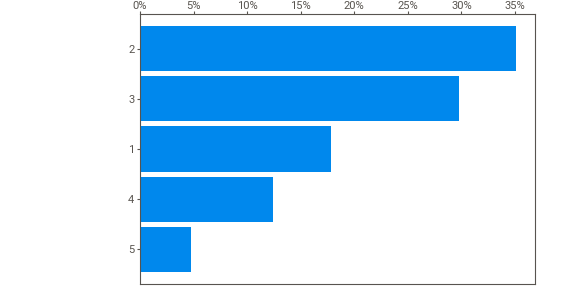
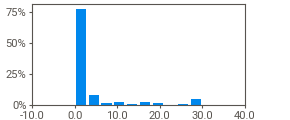
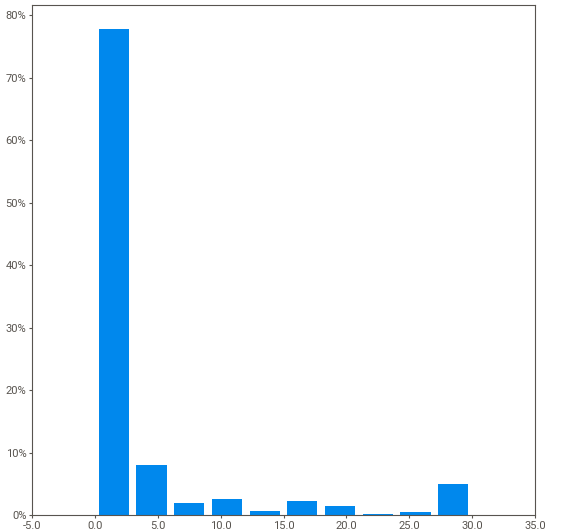
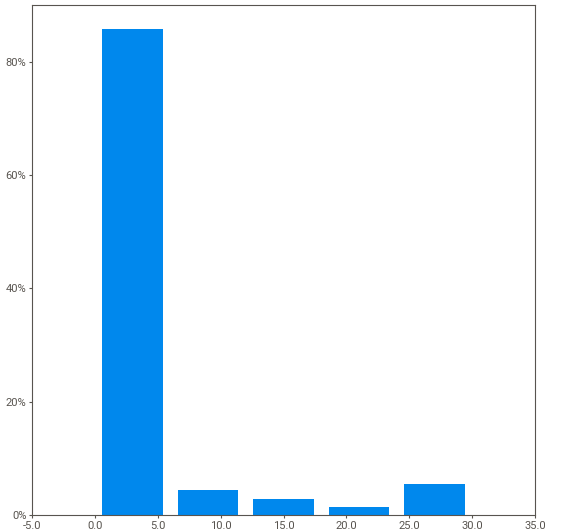
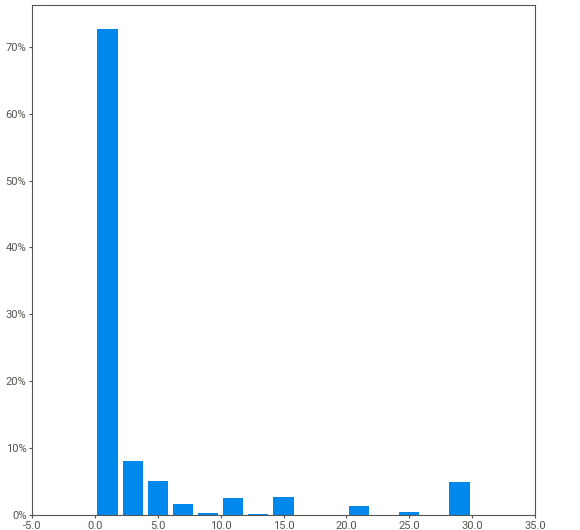
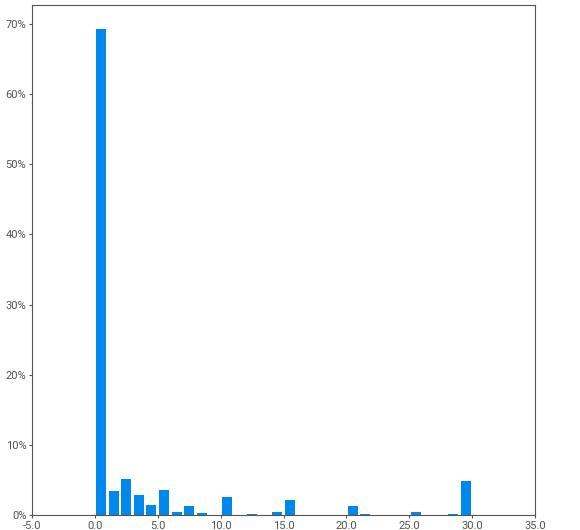
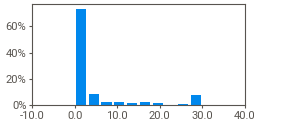
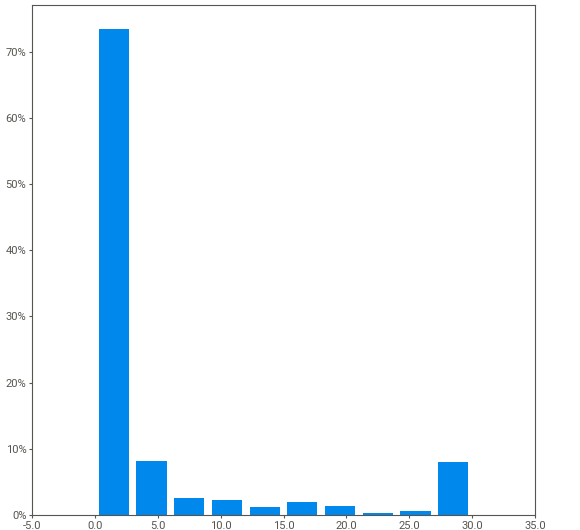
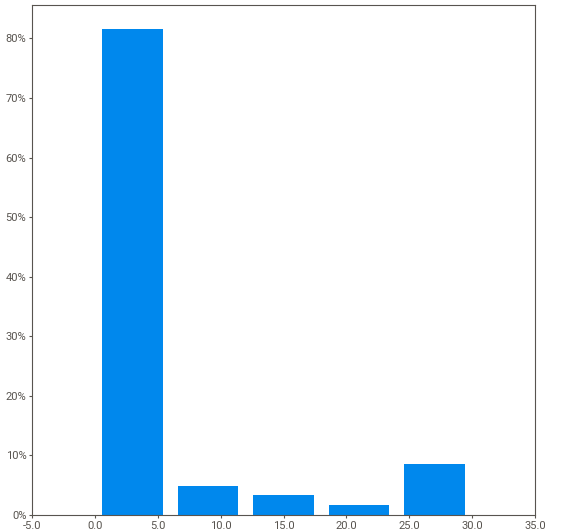
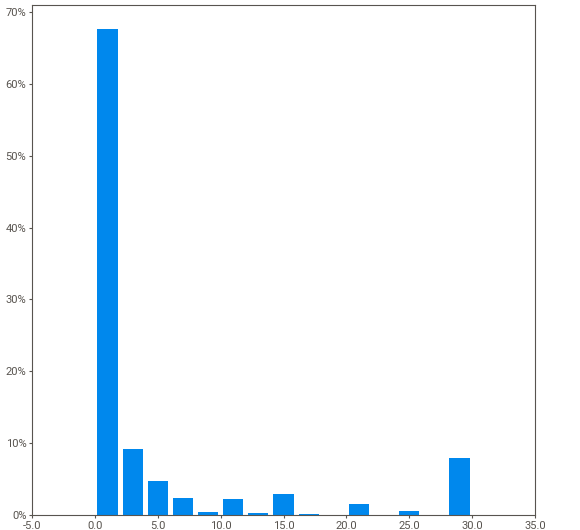
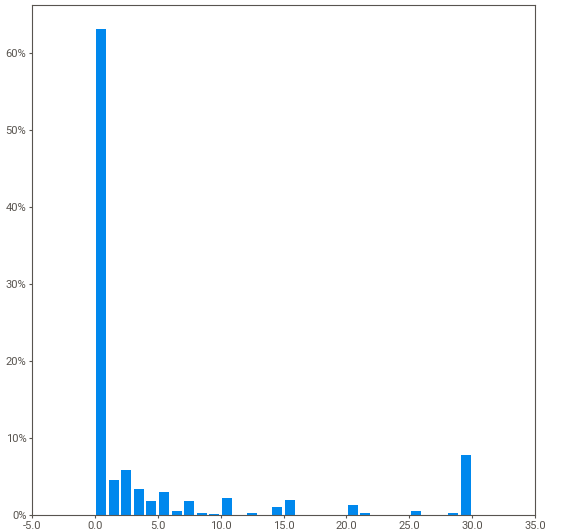
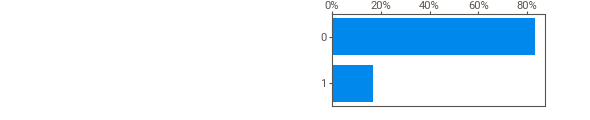
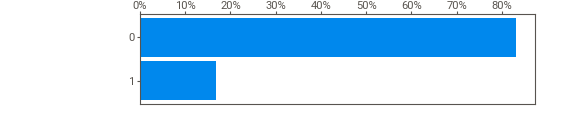
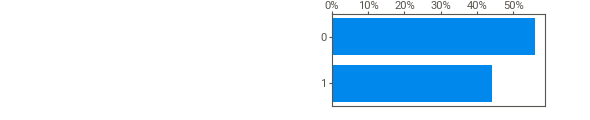
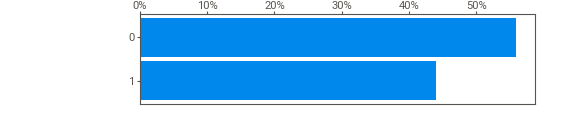
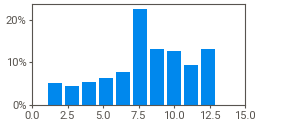
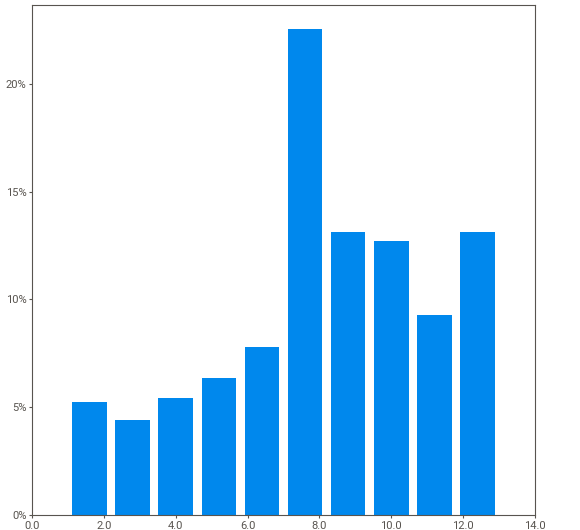
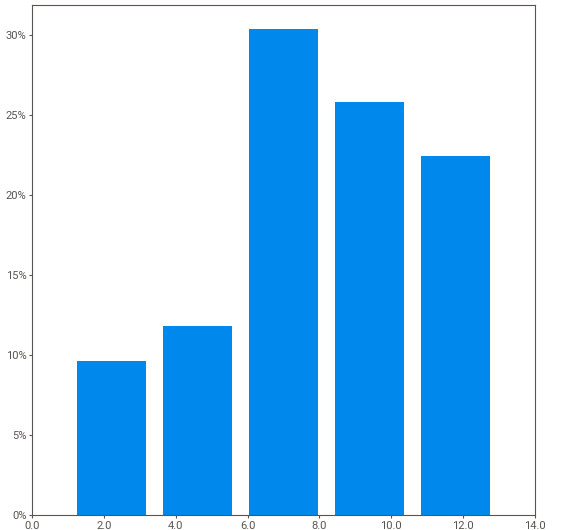
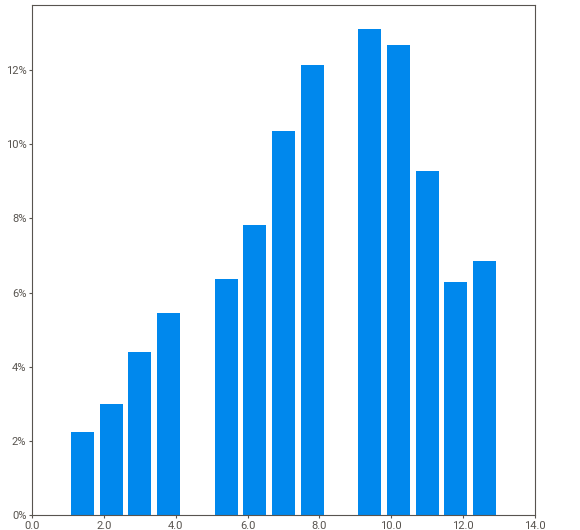
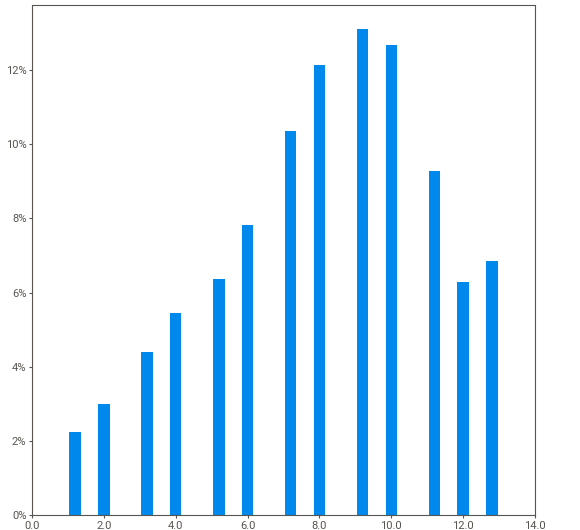
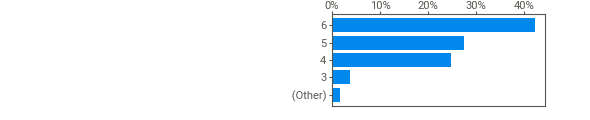
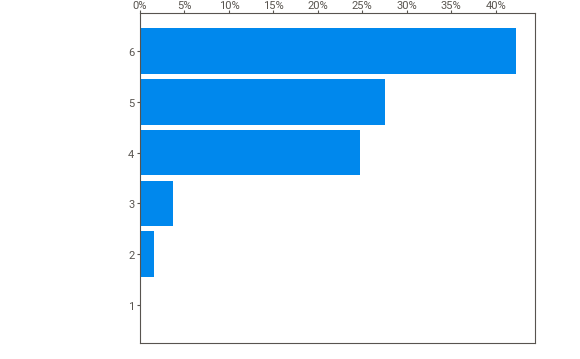
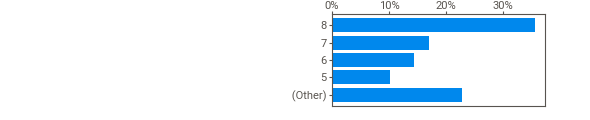
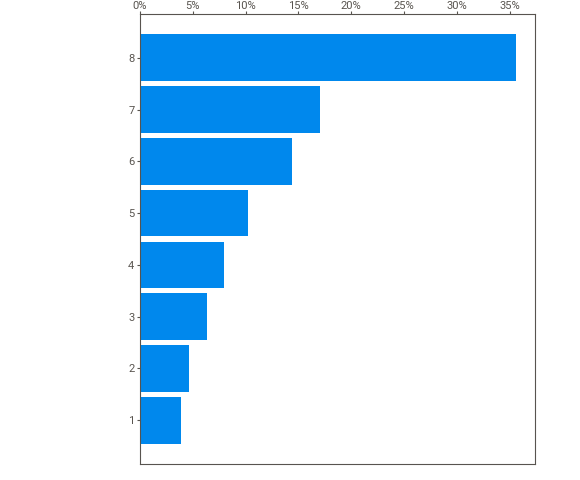
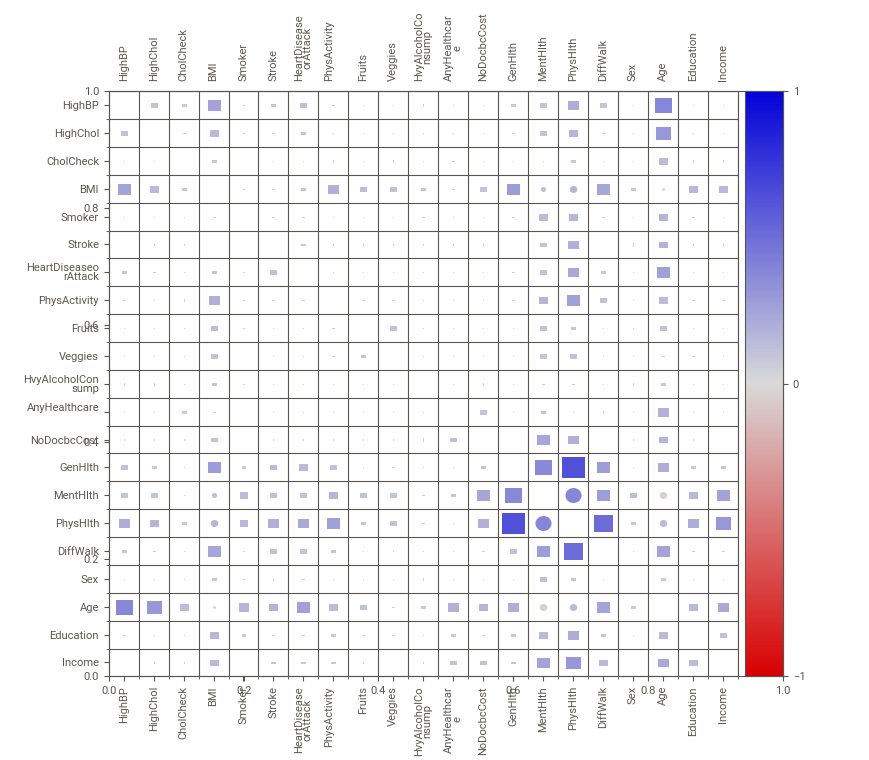
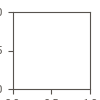

In [5]:
if 'report' not in globals():
    # Generate a Sweetviz report
    report = sv.analyze(X)

# Save the report to an HTML file
#report.show_html("sweetviz_report.html")
report.show_notebook()

# EDA and Data Prep


## Missing Values
There are no missing values!  This will save us a big headache.  

There are some that are less informative though.  (Other) exists in `Income` and `Education`

## Distinct and Data Types
Many values are binary.  Distinct also shows missingness isn't encoded for binary so the missing values really just don't exist.


### Binary
Since I verified they don't have missing this should be an easy check
`HighBP`,
 `HighChol`,
 `CholCheck`,
 `Smoker`,
 `Stroke`,
 `HeartDiseaseorAttack`,
 `PhysActivity`,
 `Fruits`,
 `Veggies`,
 `HvyAlcoholConsump`,
 `AnyHealthcare`,
 `NoDocbcCost`,
 `DiffWalk`,
 `Sex`
 are the binary columns

In [6]:
unique_counts = X.nunique()
bin_cols = unique_counts[unique_counts == 2].index.tolist()
bin_cols

['HighBP',
 'HighChol',
 'CholCheck',
 'Smoker',
 'Stroke',
 'HeartDiseaseorAttack',
 'PhysActivity',
 'Fruits',
 'Veggies',
 'HvyAlcoholConsump',
 'AnyHealthcare',
 'NoDocbcCost',
 'DiffWalk',
 'Sex']

### Continuous

`BMI`, `PhysHlth`, `MentHlth`
These columns can't be encoded as anything they just are what they are.

In [7]:
cont_cols = ['BMI','PhysHlth','MentHlth']
cont_cols

['BMI', 'PhysHlth', 'MentHlth']

### Discrete
`GenHlth`, `Age`, `Education`, `Income`
Age was binned so it is discrete here.  Education and Income are categories already encoded.

In [8]:
disc_cols = ['GenHtlh','Age','Education','Income']

### Validate Cols 

In [9]:
all_cols = bin_cols + disc_cols + cont_cols
display(len(all_cols))
if all_cols.sort() == X.columns.to_list().sort():
    print("\n All Columns Categorized")

21


 All Columns Categorized


## Duplicates
Why are there so many duplicate rows?

In [10]:
X[X.duplicated()]

HighBP  HighChol  CholCheck  BMI  Smoker  Stroke  \
1242         1         1          1   27       1       0   
1563         0         0          1   21       1       0   
2700         0         0          1   32       0       0   
3027         1         0          1   38       0       0   
3160         0         0          1   21       0       0   
...        ...       ...        ...  ...     ...     ...   
253492       1         1          1   33       0       0   
253550       0         0          1   25       0       0   
253563       0         1          1   24       1       0   
253597       0         0          1   24       0       0   
253638       0         0          1   24       0       0   

        HeartDiseaseorAttack  PhysActivity  Fruits  Veggies  ...  \
1242                       0             0       0        1  ...   
1563                       0             1       1        1  ...   
2700                       0             1       1        1  ...   
3027                       0             1       1        1  ...   
3160                       0             1       1        1  ...   
...                      ...           ...     ...      ...  ...   
253492                     0             1       1        1  ...   
253550                     0             1       1        1  ...   
253563                     0             1       1        1  ...   
253597                     0             1       1        1  ...   
253638                     0             1       1        1  ...   

        AnyHealthcare  NoDocbcCost  GenHlth  MentHlth  PhysHlth  DiffWalk  \
1242                1            0        5         0        30         1   
1563                1            0        1         0         0         0   
2700                1            0        2         0         0         0   
3027                1            0        3         0         0         0   
3160                1            0        1         0         0         0   
...               ...          ...      ...       ...       ...       ...   
253492              1            0        3         0         0         0   
253550              1            0        1         0         0         0   
253563              1            0        2         0         0         0   
253597              1            0        2         0         0         0   
253638              1            0        2         0         0         0   

        Sex  Age  Education  Income  
1242      0   10          4       5  
1563      0    4          6       8  
2700      0    5          6       8  
3027      1    7          6       8  
3160      0    4          6       8  
...     ...  ...        ...     ...  
253492    1    9          6       6  
253550    0    7          6       8  
253563    1    8          6       8  
253597    0    5          6       8  
253638    1    1          4       6  

[25772 rows x 21 columns]

### Statistically Likely?

In [11]:
X.duplicated().sum() / len(X)

0.10159255755282245

10% of rows being duplicate among how many features is how likely?

Lets assume they are all binary to just make the math easy

### Broad Estimate

In [12]:
num_combinations = 1
for column in X.columns:
    distinct_values = X[column].nunique()
    num_combinations *= distinct_values

print(f"Total number of unique combinations possible: {num_combinations:,}")

Total number of unique combinations possible: 4,126,455,889,920


In [13]:
n = len(X)
# Calculating the expected number of duplicates
expected_duplicates = (n * (n - 1)) / (2 * num_combinations)
print(f"Expected number of duplicate rows: {expected_duplicates:,}")

Expected number of duplicate rows: 0.007797646507890773


### There shouldn't be any duplicates but 10% of the dataset has them
The expected duplicates being close to zero strongly indicates that having 10% of the dataset be duplicates is extremely unlikely by chance.  So there has to be another reason.

The duplicates could be for a slew of reasons, such as sampling strategies in surveys, repeated surveys including the same people or errors in aggergating surveys with scripts.

In any case, I should either delete all of them or keep only 1 of each.  Since their data integrity is in quesiton and there's so many rows I can just drop them.

In [14]:
drop_masq = X.duplicated()
y = y[~drop_masq]
X = X[~drop_masq]
X.duplicated().sum()

0

## Data Type Checking

In [15]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 227908 entries, 0 to 253679
Data columns (total 21 columns):
 #   Column                Non-Null Count   Dtype
---  ------                --------------   -----
 0   HighBP                227908 non-null  int64
 1   HighChol              227908 non-null  int64
 2   CholCheck             227908 non-null  int64
 3   BMI                   227908 non-null  int64
 4   Smoker                227908 non-null  int64
 5   Stroke                227908 non-null  int64
 6   HeartDiseaseorAttack  227908 non-null  int64
 7   PhysActivity          227908 non-null  int64
 8   Fruits                227908 non-null  int64
 9   Veggies               227908 non-null  int64
 10  HvyAlcoholConsump     227908 non-null  int64
 11  AnyHealthcare         227908 non-null  int64
 12  NoDocbcCost           227908 non-null  int64
 13  GenHlth               227908 non-null  int64
 14  MentHlth              227908 non-null  int64
 15  PhysHlth              227908 non-null  

Many of these are boolean but all are in int64 lets fix that

### Binary Cols Should be Boolean

In [16]:
X[bin_cols] = X[bin_cols].astype('bool')
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 227908 entries, 0 to 253679
Data columns (total 21 columns):
 #   Column                Non-Null Count   Dtype
---  ------                --------------   -----
 0   HighBP                227908 non-null  bool 
 1   HighChol              227908 non-null  bool 
 2   CholCheck             227908 non-null  bool 
 3   BMI                   227908 non-null  int64
 4   Smoker                227908 non-null  bool 
 5   Stroke                227908 non-null  bool 
 6   HeartDiseaseorAttack  227908 non-null  bool 
 7   PhysActivity          227908 non-null  bool 
 8   Fruits                227908 non-null  bool 
 9   Veggies               227908 non-null  bool 
 10  HvyAlcoholConsump     227908 non-null  bool 
 11  AnyHealthcare         227908 non-null  bool 
 12  NoDocbcCost           227908 non-null  bool 
 13  GenHlth               227908 non-null  int64
 14  MentHlth              227908 non-null  int64
 15  PhysHlth              227908 non-null  

### max value of int64 checks
We can improve memory usage and computation speed if we lower the values to their sizes

In [17]:
int_cols = X.select_dtypes('int64').columns.to_list()
for col in int_cols:
    print(f"{col} range is {X[col].min()} - {X[col].max()}")

BMI range is 12 - 98
GenHlth range is 1 - 5
MentHlth range is 0 - 30
PhysHlth range is 0 - 30
Age range is 1 - 13
Education range is 1 - 6
Income range is 1 - 8


In [18]:
int_cols

['BMI', 'GenHlth', 'MentHlth', 'PhysHlth', 'Age', 'Education', 'Income']

### Cast to uint8
They are all less than 255 by a lot, which means uint8 is big enough for them.

In [19]:
cast_dict = {}
for col in int_cols:
    cast_dict[col] = 'uint8'
display(cast_dict)
X = X.astype(cast_dict)
X.info()

{'BMI': 'uint8',
 'GenHlth': 'uint8',
 'MentHlth': 'uint8',
 'PhysHlth': 'uint8',
 'Age': 'uint8',
 'Education': 'uint8',
 'Income': 'uint8'}

<class 'pandas.core.frame.DataFrame'>
Index: 227908 entries, 0 to 253679
Data columns (total 21 columns):
 #   Column                Non-Null Count   Dtype
---  ------                --------------   -----
 0   HighBP                227908 non-null  bool 
 1   HighChol              227908 non-null  bool 
 2   CholCheck             227908 non-null  bool 
 3   BMI                   227908 non-null  uint8
 4   Smoker                227908 non-null  bool 
 5   Stroke                227908 non-null  bool 
 6   HeartDiseaseorAttack  227908 non-null  bool 
 7   PhysActivity          227908 non-null  bool 
 8   Fruits                227908 non-null  bool 
 9   Veggies               227908 non-null  bool 
 10  HvyAlcoholConsump     227908 non-null  bool 
 11  AnyHealthcare         227908 non-null  bool 
 12  NoDocbcCost           227908 non-null  bool 
 13  GenHlth               227908 non-null  uint8
 14  MentHlth              227908 non-null  uint8
 15  PhysHlth              227908 non-null  

### Analysis of Casting
great! we went from `memory usage: 38.3 MB` to `memory usage: 6.3 MB` with zero information loss!  Feels great.  This should really help our model training and efficiency overall, as well as let models with special handling of booleans benefit from it!

## Int Cols Distributions and Class Imbalances
I need to analyze the distributions of all the int cols

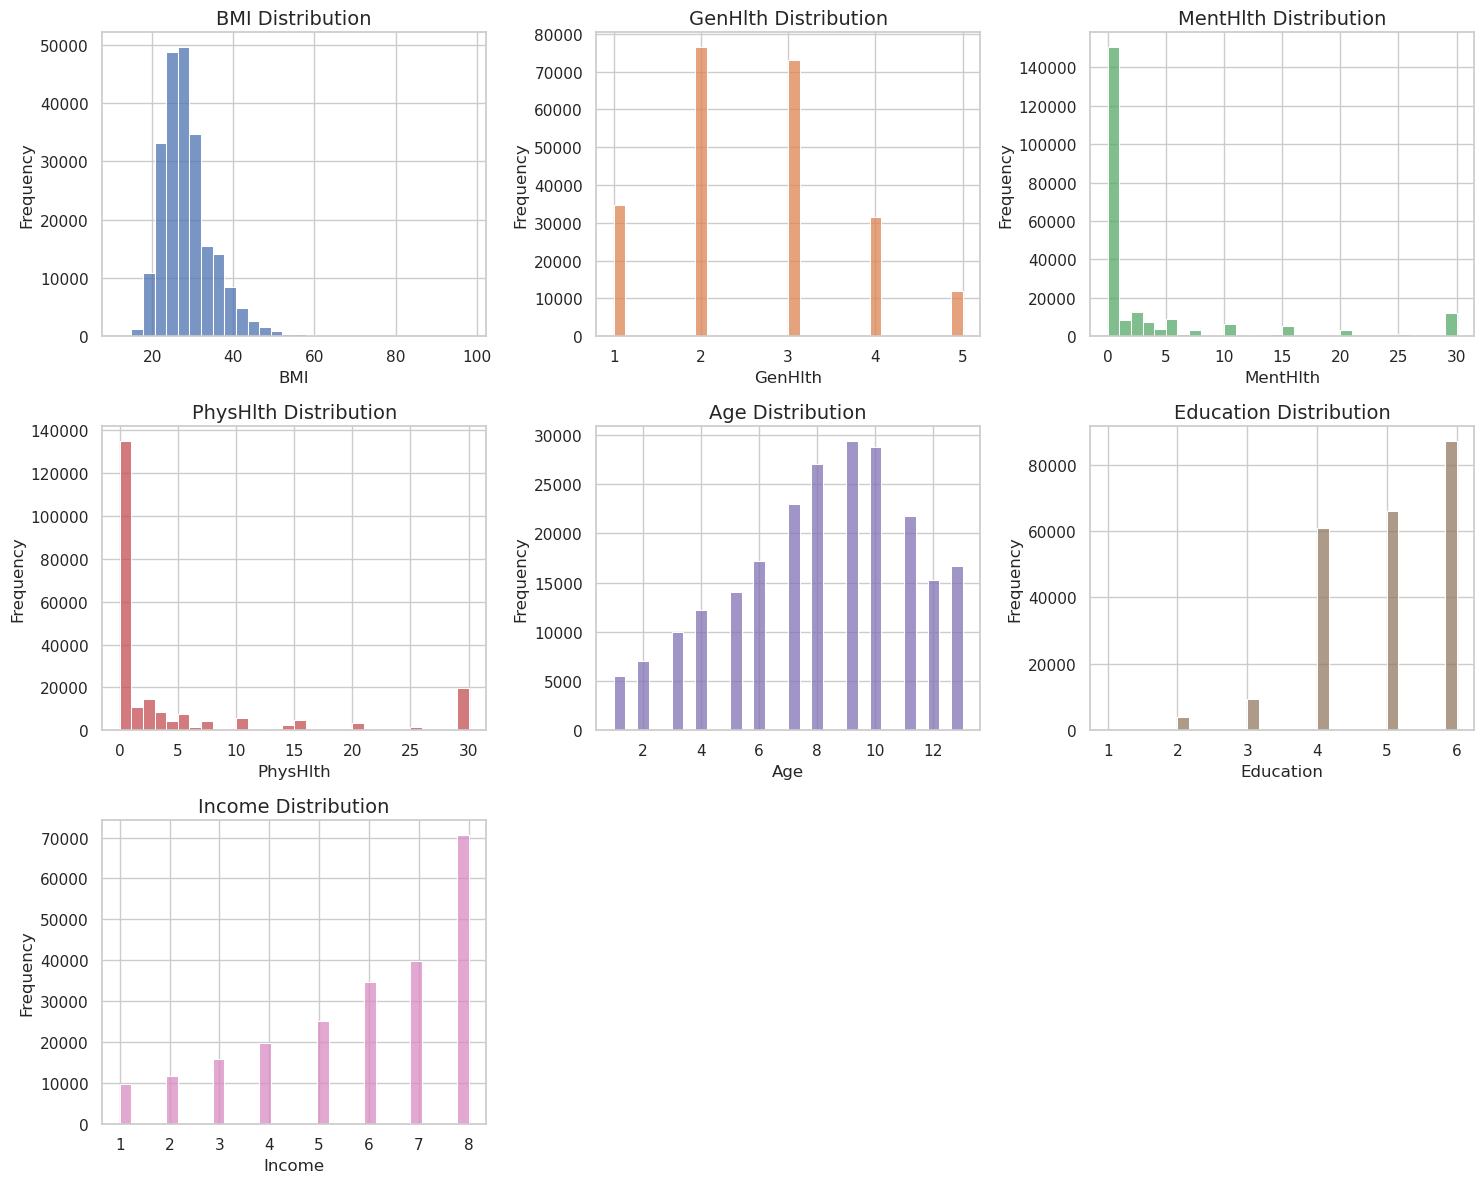

In [20]:
def hist_plot_cols(cols):
    # Set the style and color palette
    sns.set(style="whitegrid")
    palette = sns.color_palette("deep",n_colors=len(cols))

    # Create a grid of plots (3x3 grid to accommodate all the columns)
    n_rows = 3
    n_cols = 3

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 12))

    # Flatten the axes array for easy iteration
    axes = axes.flatten()

    # Plot histograms for each integer column with different colors
    for i, col in enumerate(cols):
        sns.histplot(X[col], ax=axes[i], kde=False, color=palette[i], bins=30)
        axes[i].set_title(f'{col} Distribution', fontsize=14)
        axes[i].set_xlabel(col, fontsize=12)
        axes[i].set_ylabel('Frequency', fontsize=12)
        axes[i].grid(True)

    # Remove any unused subplots (if any)
    for j in range(i + 1, n_rows * n_cols):
        fig.delaxes(axes[j])

    # Adjust layout to prevent overlapping
    plt.tight_layout()

    # Show the plots
    plt.show()
hist_plot_cols(int_cols)

In [21]:
do_rebins = True

#### BMI
BMI has a skewed distribution, the number of people really overweight are probably outliers.

#### GenHlth
Lets see what the encodings mean

In [22]:
def display_variable_desc(varname):
    # Extract the description of the 'GenHlth' variable
    vardesc = variables[variables['name'] == varname]['description'].values[0]
    # Display it nicely in a notebook using Markdown
    display(Markdown(f"**{varname} Description:**\n\n{vardesc}"))
display_variable_desc('GenHlth')

**GenHlth Description:**

Would you say that in general your health is: scale 1-5 1 = excellent 2 = very good 3 = good 4 = fair 5 = poor

It seems most people rate their health very good or good.  Since this is an encoding the distribution is more of a classification.

#### MentHlth

In [23]:
display_variable_desc('MentHlth')
X['MentHlth'].value_counts(normalize=True).head()

**MentHlth Description:**

Now thinking about your mental health, which includes stress, depression, and problems with emotions, for how many days during the past 30 days was your mental health not good? scale 1-30 days

MentHlth
0     0.661574
2     0.055650
30    0.052999
5     0.039090
1     0.036423
Name: proportion, dtype: float64

66% of people say 0 days of their mental health was not good in the last month.
So a pretty big imbalance.  Consider binning since there's so few people in each bin other than 0.

##### Bin MentHlth

In [24]:
if do_rebins:
    # Create the bins and labels
    bins = [-1, 0, 7, 30]  # -1 to include 0 in its own bin
    labels = [1, 2, 3]  # 1 for 0, then 2, 3, 4 for the other bins

    # Apply the binning to the MentHlth column
    X['MentHlth_binned'] = pd.cut(X['MentHlth'], bins=bins, labels=labels, include_lowest=True)

    # Display the resulting binned column
    print(X[['MentHlth', 'MentHlth_binned']].head())

   MentHlth MentHlth_binned
0        18               3
1         0               1
2        30               3
3         0               1
4         3               2


In [25]:
if do_rebins:
    X['MentHlth_binned'].value_counts(normalize=True).head()

I have binned it into 
1: people who have zero mental health issues
2: people who reported 1-7 days with mental health issues in a month
3: people who reported 8-30 days with mental health issues in a month

The reason for this is two fold.  One is class balance, the other is, it's basically very healthy, struggling, and miserable.


#### PhysHlth

In [26]:
display_variable_desc('PhysHlth')
X['PhysHlth'].value_counts(normalize=True).head()

**PhysHlth Description:**

Now thinking about your physical health, which includes physical illness and injury, for how many days during the past 30 days was your physical health not good? scale 1-30 days

PhysHlth
0     0.592599
30    0.085030
2     0.063495
1     0.048533
3     0.036989
Name: proportion, dtype: float64

#### Bin PhysHlth

In [27]:
if do_rebins:
    # Create the bins and labels
    bins = [-1, 0, 7, 30]  # -1 to include 0 in its own bin
    labels = [1, 2, 3]  # 1 for 0, then 2, 3, 4 for the other bins

    # Apply the binning to the PhysHlth column
    X['PhysHlth_binned'] = pd.cut(X['PhysHlth'], bins=bins, labels=labels, include_lowest=True)

    # Display the resulting binned column
    print(X[['PhysHlth', 'PhysHlth_binned']].head())

   PhysHlth PhysHlth_binned
0        15               3
1         0               1
2        30               3
3         0               1
4         0               1


In [28]:
if do_rebins:
    X['PhysHlth_binned'].value_counts(normalize=True).head()

Same reasoning as with Mental Health

#### Age

In [29]:
display_variable_desc('Age')
X['Age'].value_counts(normalize=True).head()

**Age Description:**

13-level age category (_AGEG5YR see codebook) 1 = 18-24 9 = 60-64 13 = 80 or older

Age
9     0.129004
10    0.126051
8     0.118807
7     0.100892
11    0.095464
Name: proportion, dtype: float64

Age looks great for our needs.  It is slightly not normal but it's ok.

#### Education

In [30]:
display_variable_desc('Education')
X['Education'].value_counts(normalize=True).head()

**Education Description:**

Education level (EDUCA see codebook) scale 1-6 1 = Never attended school or only kindergarten 2 = Grades 1 through 8 (Elementary) 3 = Grades 9 through 11 (Some high school) 4 = Grade 12 or GED (High school graduate) 5 = College 1 year to 3 years (Some college or technical school) 6 = College 4 years or more (College graduate)

Education
6    0.382611
5    0.290078
4    0.267283
3    0.041539
2    0.017726
Name: proportion, dtype: float64

1 is an empty class we can just get rid of it

2 and 3 are super small consider binning

4,5, and 6 are fine but we can make this a better encoding by rebinning

##### Rebinning Education

In [31]:
if do_rebins:
    education_mapping = {
        1: 1,  # Combine these three into a single bin
        2: 1,
        3: 1,
        4: 2,  # Keep the original class for 4, 5, and 6, but reassign them to new values
        5: 3,
        6: 4
    }

    # Apply the mapping to the Education column
    X['Education_binned'] = X['Education'].map(education_mapping)

    # Display the resulting binned column
    print(X[['Education', 'Education_binned']].head())

   Education  Education_binned
0          4                 2
1          6                 4
2          4                 2
3          3                 1
4          5                 3


That's better!

In [32]:
if do_rebins:
    X['Education_binned'].value_counts(normalize=True).head()

#### Income

In [33]:
display_variable_desc('Income')
X['Income'].value_counts(normalize=True)

**Income Description:**

Income scale (INCOME2 see codebook) scale 1-8 1 = less than $10,000 5 = less than $35,000 8 = $75,000 or more

Income
8    0.310046
7    0.174921
6    0.152588
5    0.110782
4    0.087377
3    0.069769
2    0.051560
1    0.042956
Name: proportion, dtype: float64

More imbalances and less meaningful categories.  Lets fix it.

##### Rebin Income

In [34]:
if do_rebins:
    income_mapping = {
        1: 1, 
        2: 1,
        3: 1,
        4: 1, 
        5: 2,
        6: 2,
        7: 3,
        8: 4,
    }

    # Apply the mapping to the income column
    X['Income_binned'] = X['Income'].map(income_mapping)

    # Display the resulting binned column
    print(X[['Income', 'Income_binned']].head())

   Income  Income_binned
0       3              1
1       1              1
2       8              4
3       6              2
4       4              1


##### Eval Rebin

In [35]:
if do_rebins:
    X['Income_binned'].value_counts(normalize=True)

This seems a better grouping, we can now categorize as:
* 1: poverty 
* 2: poor ($35,000)
* 3: mid income
* 4: high income ($75,000+)

### Fix Datatypes

In [36]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 227908 entries, 0 to 253679
Data columns (total 25 columns):
 #   Column                Non-Null Count   Dtype   
---  ------                --------------   -----   
 0   HighBP                227908 non-null  bool    
 1   HighChol              227908 non-null  bool    
 2   CholCheck             227908 non-null  bool    
 3   BMI                   227908 non-null  uint8   
 4   Smoker                227908 non-null  bool    
 5   Stroke                227908 non-null  bool    
 6   HeartDiseaseorAttack  227908 non-null  bool    
 7   PhysActivity          227908 non-null  bool    
 8   Fruits                227908 non-null  bool    
 9   Veggies               227908 non-null  bool    
 10  HvyAlcoholConsump     227908 non-null  bool    
 11  AnyHealthcare         227908 non-null  bool    
 12  NoDocbcCost           227908 non-null  bool    
 13  GenHlth               227908 non-null  uint8   
 14  MentHlth              227908 non-null  ui

In [37]:
if do_rebins:
    for col in X.columns:
        if "_binned" in col:
            X[col] = X[col].astype('uint8')
    X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 227908 entries, 0 to 253679
Data columns (total 25 columns):
 #   Column                Non-Null Count   Dtype
---  ------                --------------   -----
 0   HighBP                227908 non-null  bool 
 1   HighChol              227908 non-null  bool 
 2   CholCheck             227908 non-null  bool 
 3   BMI                   227908 non-null  uint8
 4   Smoker                227908 non-null  bool 
 5   Stroke                227908 non-null  bool 
 6   HeartDiseaseorAttack  227908 non-null  bool 
 7   PhysActivity          227908 non-null  bool 
 8   Fruits                227908 non-null  bool 
 9   Veggies               227908 non-null  bool 
 10  HvyAlcoholConsump     227908 non-null  bool 
 11  AnyHealthcare         227908 non-null  bool 
 12  NoDocbcCost           227908 non-null  bool 
 13  GenHlth               227908 non-null  uint8
 14  MentHlth              227908 non-null  uint8
 15  PhysHlth              227908 non-null  

### Lists of Feature Changes

In [38]:
# List of features that were re-binned
rebinned_features = [
    'PhysHlth_binned',
    'MentHlth_binned',
    'Income_binned',
    'Education_binned'
]

# List of original features that were not re-binned
unrebinned_features = [
    'PhysHlth',
    'MentHlth',
    'Income',
    'Education'
]

## Outliers
BMI is the only column I'm worried about outliers lets check it

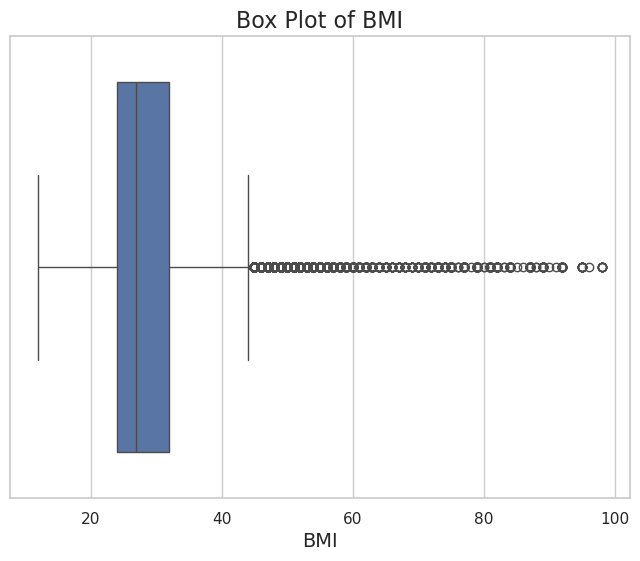

In [39]:
sns.set(style="whitegrid")
palette = sns.color_palette("deep")

# Create the box plot for the 'BMI' column
plt.figure(figsize=(8, 6))
sns.boxplot(x=X['BMI'], color=palette[0])

# Add title and labels for clarity
plt.title('Box Plot of BMI', fontsize=16)
plt.xlabel('BMI', fontsize=14)

# Show the plot
plt.show()

Well, I know from domain knowledge that heavy weights are actually pretty important for predicting diabetes so they must stay.

## Binary Class Imbalances

### Extract Labels for True/False Utility Function

In [40]:
# Function to extract labels for binary columns
def extract_labels_for_bin_cols(bin_cols):
    labels = {}
    for col in bin_cols:
        description = variables[variables['name'] == col]['description'].values[0]
        meanings = re.findall(r'(\d) = ([^\d]+?)(?= \d|$)', description)
        false_meaning = meanings[0][1].strip() if len(meanings) > 0 else "False"
        true_meaning = meanings[1][1].strip() if len(meanings) > 1 else "True"
        labels[col] = (false_meaning, true_meaning)
    return labels

In [41]:
binary_labels = extract_labels_for_bin_cols(bin_cols)

### Plot Binary Class Balances

In [42]:
def plot_binary_class_balances(bin_cols,dfX=X):
    # Set the style with a more widely available font and a light blue background
    sns.set(style="whitegrid", font="DejaVu Sans", rc={"axes.facecolor": "#EAF2F8", "figure.facecolor": "#EAF2F8"})
    custom_palette = ["#E1D7C6","#4A90E2"]  # Medical light blue and gray
    
    # Calculate the number of rows needed based on the number of columns
    n_cols = 3  # Three plots per row
    n_rows = (len(bin_cols) + n_cols - 1) // n_cols  # Ceiling division to determine rows
    
    # Create a figure to hold all subplots
    plt.figure(figsize=(18, n_rows * 6))
    
    # Iterate through each binary column
    for i, col in enumerate(bin_cols):
        plt.subplot(n_rows, n_cols, i + 1)  # Create a subplot for each binary column
        
        # Calculate the proportion of each class
        value_counts = dfX[col].value_counts(normalize=True).sort_index()
        
        # Get the actual labels from the global binary_labels variable
        false_label, true_label = binary_labels[col]
        labels = [false_label, true_label]
        
        # Create a DataFrame for plotting
        plot_data = pd.DataFrame({
            'Label': labels,
            'Proportion': value_counts.values,
            'Category': labels
        })
        
        # Create a bar plot with the actual labels using hue and palette
        sns.barplot(x='Label', y='Proportion', hue='Category', data=plot_data,
                    palette=custom_palette, dodge=False, edgecolor=".2", linewidth=1.5)
        
        # Add title and labels
        plt.title(f'Class Balance for {col}', fontsize=16, fontweight='bold')
        plt.xlabel('', fontsize=12)
        plt.ylabel('Proportion', fontsize=12)
        plt.ylim(0, 1.05)  # Set y-axis to go slightly above 1 to prevent percentage overlap
        # Adjust x-tick labels for size and weight
        plt.xticks(fontsize=12, fontweight='bold')
        
        # Display the percentages on the bars with padding to avoid bleeding
        for index, value in enumerate(value_counts.values):
            plt.text(index, value + 0.02, f'{value:.2%}', ha='center', fontsize=12, color='black', fontweight='bold')

    # Adjust layout to prevent overlap
    plt.tight_layout(pad=2.0)  # Add padding around the subplots

    # Show the plot
    plt.show()

### Binary Class Balances

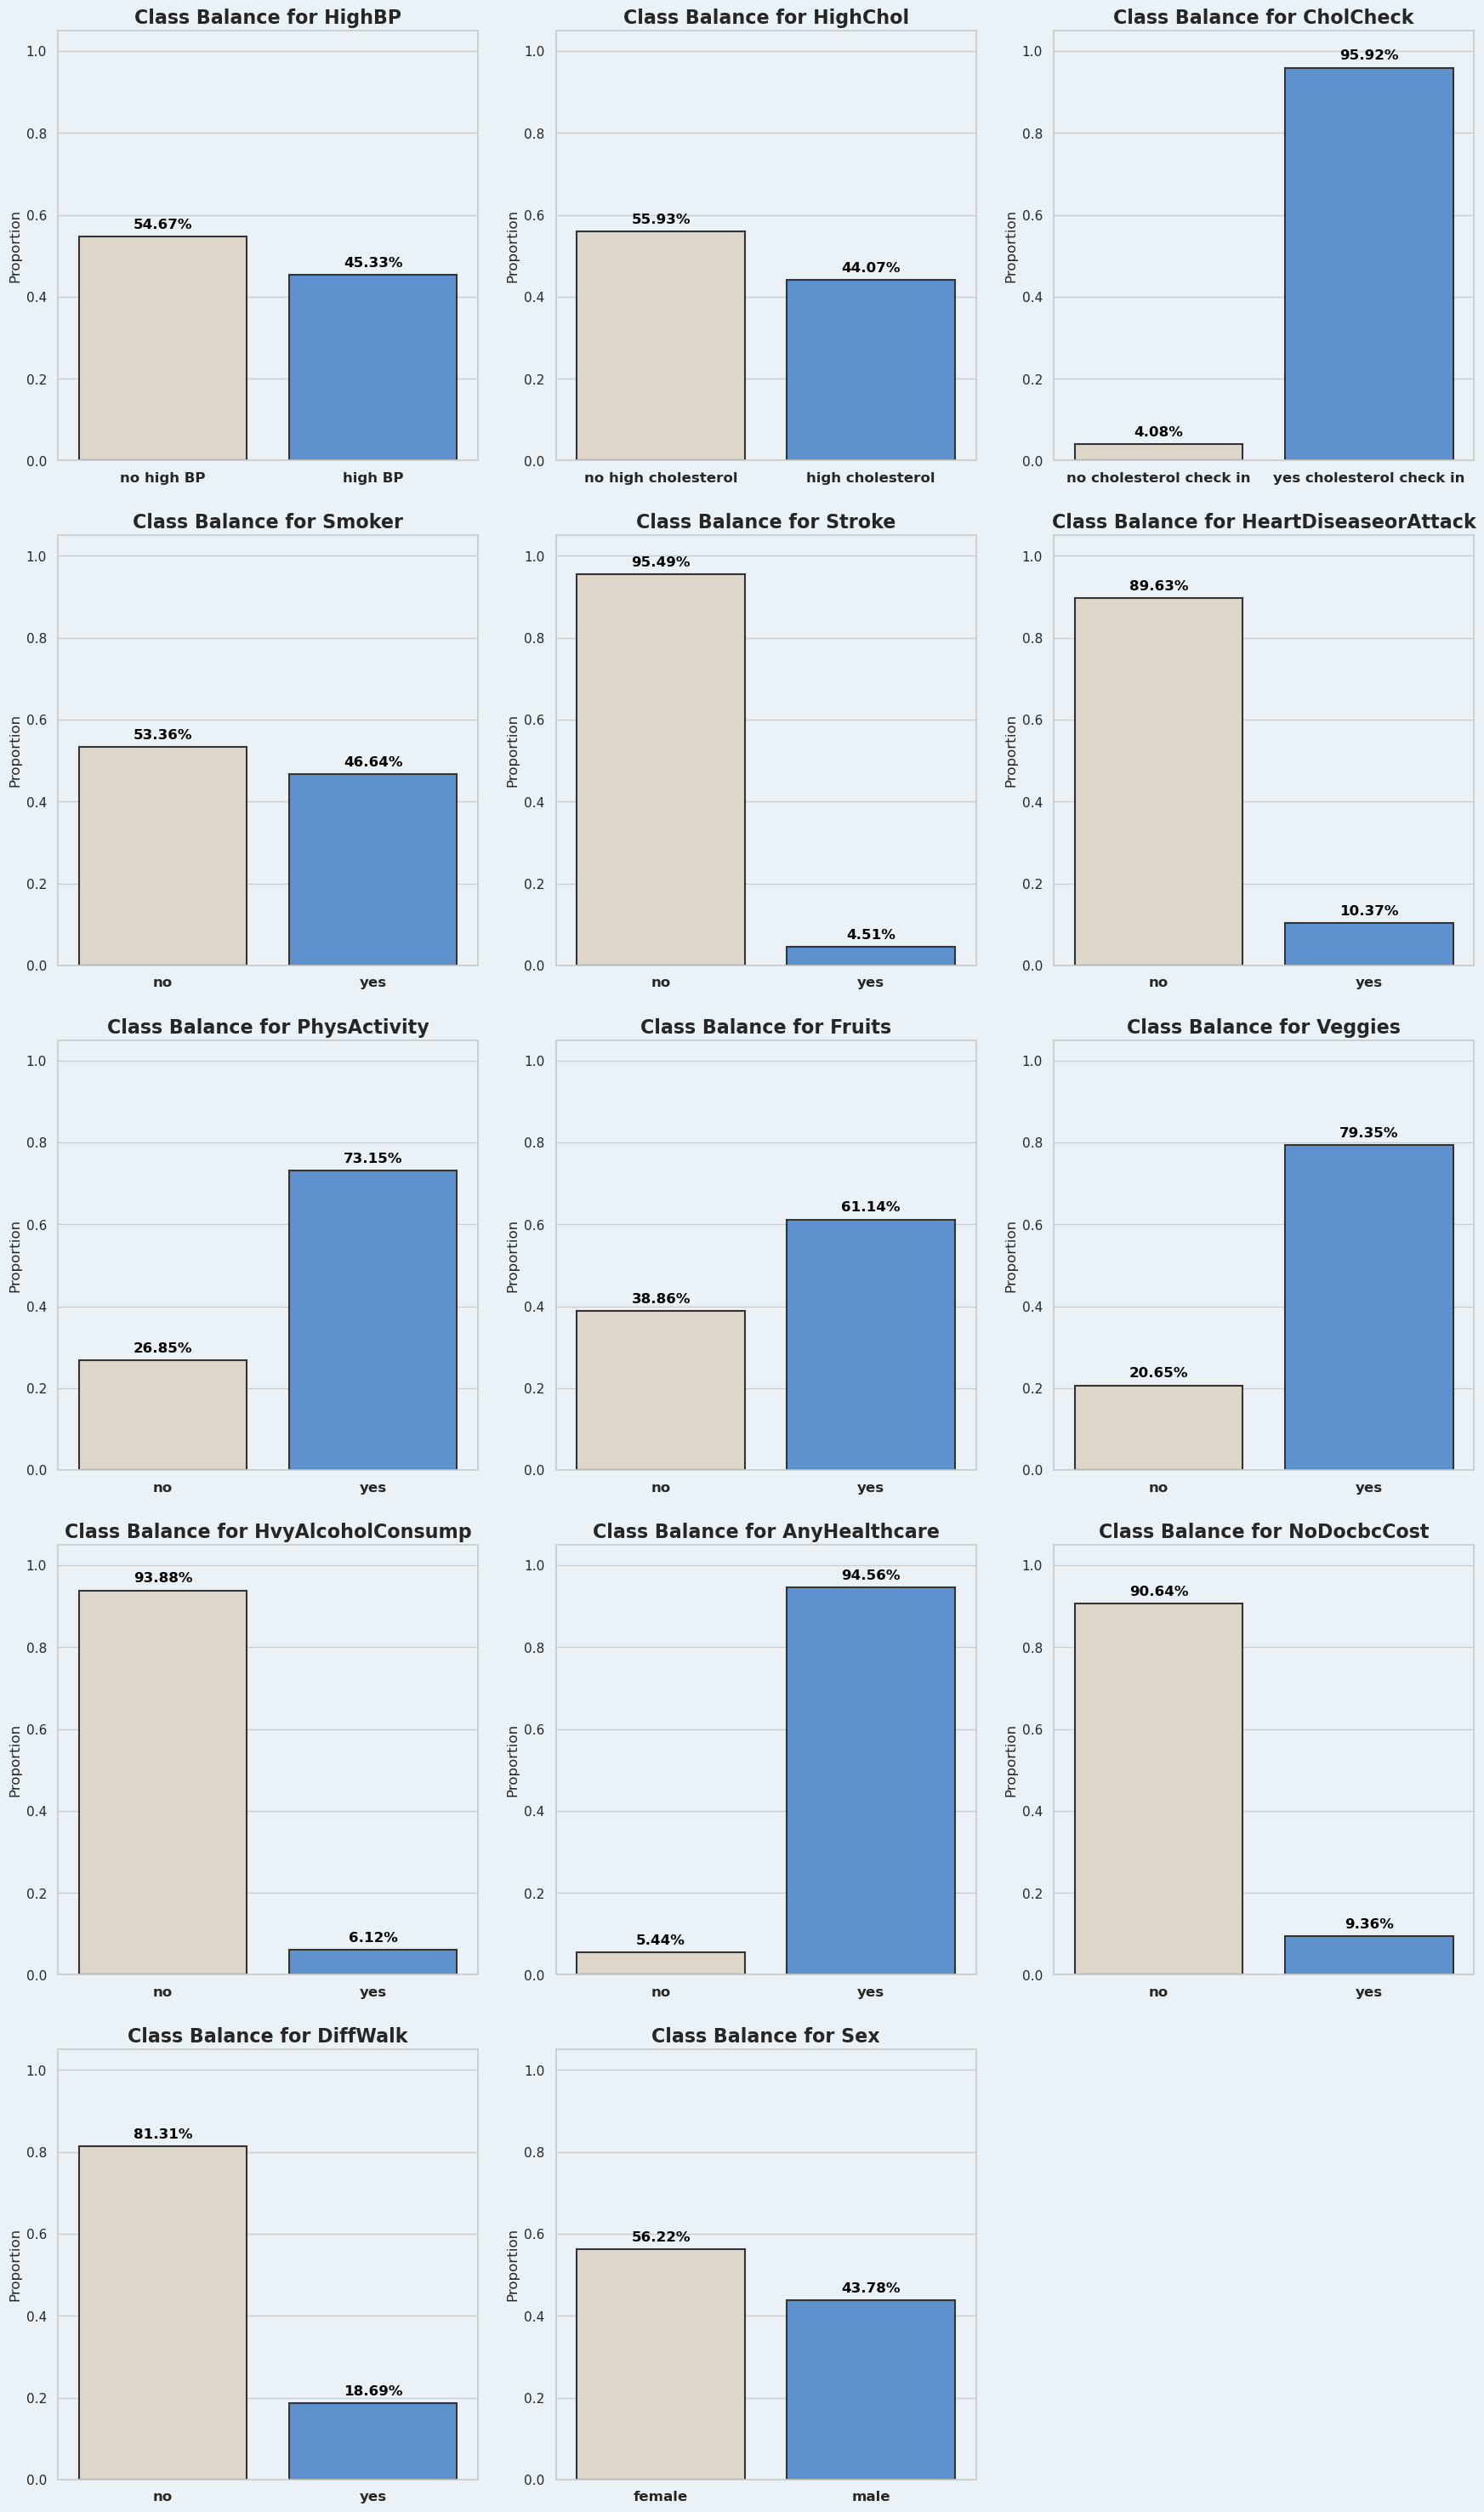

In [43]:
plot_binary_class_balances(bin_cols)

### Analysis of Class Balances

#### HighBP
HighBP shows a fairly even distribution. 

#### HighChol
HighChol shows a fairly even distribution.

#### CholCheck
CholCheck is highly imbalanced, with 95.92% having had a cholesterol check. Important but really hard to balance.

#### Smoker
Smoker is fairly balanced (53.36% no, 46.64% yes).

#### Stroke
Stroke is extremely imbalanced, with only 4.51% reporting a stroke. It is however really useful info.  Can try a drop possibly.

#### HeartDiseaseorAttack
HeartDiseaseorAttack has a notable imbalance (89.63% no, 10.37% yes), but is a critical predictor.

#### PhysActivity
PhysActivity shows a slight imbalance with 73.15% reporting physical activity.  However it is critical.

#### Fruits
Fruits consumption is somewhat imbalanced, with 61.14% reporting daily consumption. Keep as is.

#### Veggies
Veggies consumption is more imbalanced (79.35% yes, 20.65% no). Still critical to keep.

#### HvyAlcoholConsump
Heavy alcohol consumption is highly imbalanced, with only 6.12% reporting it. It is however important to keep.

#### AnyHealthcare
AnyHealthcare is imbalanced, with 94.56% having healthcare coverage. This is a really hard one to call, it could be an indicator for sure though.

#### NoDocbcCost
NoDocbcCost indicates a strong imbalance, with only 9.36% reporting inability to see a doctor due to cost. This is still maybe important but it and AnyHealthCare may be candidates for dropping if model performance is in question.

#### DiffWalk
DiffWalk shows an imbalance where 18.69% report difficulty walking. This is an important feature.

#### Sex
Sex is relatively balanced (56.22% female, 43.78% male), we'll have to see how much of a predictor it is, some diseases are more common in one sex or the other.

## Feature Importance and Correlations

### Target to Features Correlations

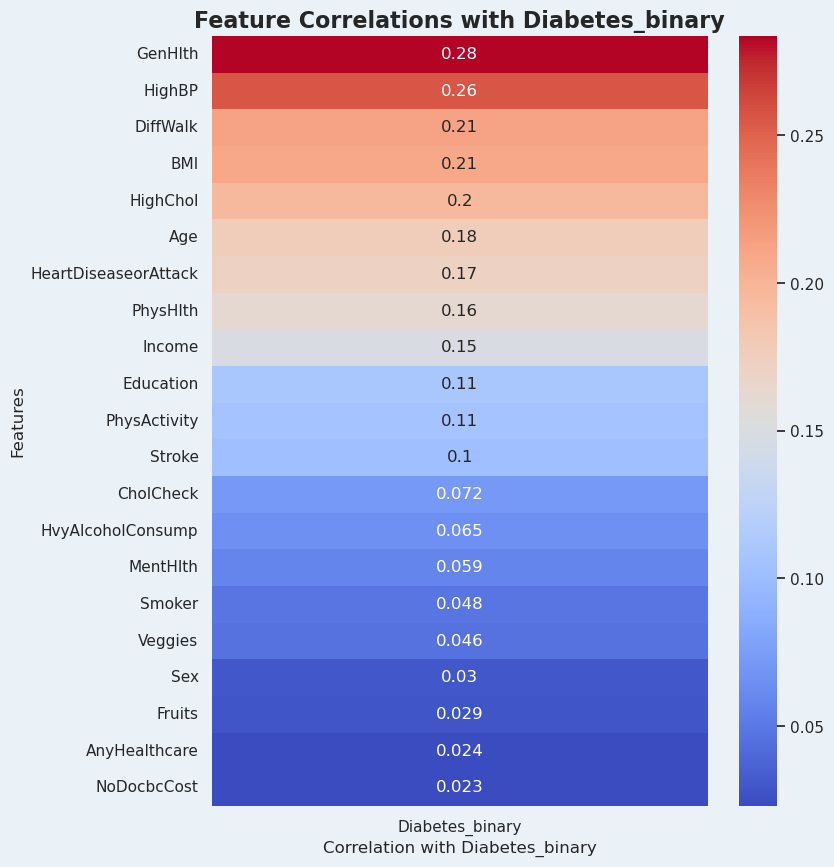

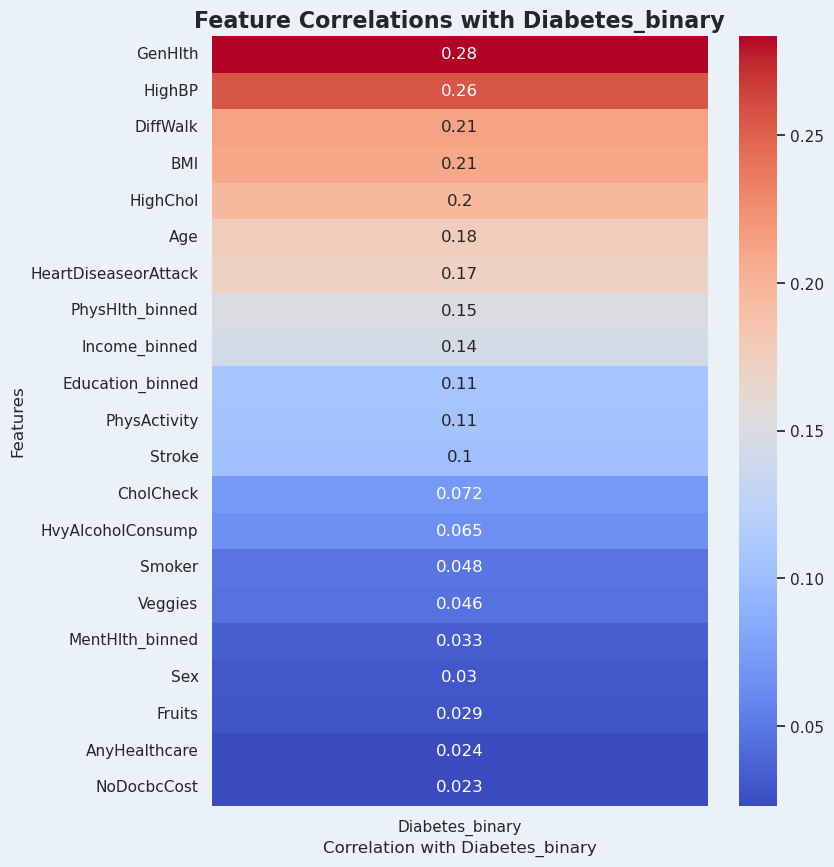

In [44]:
def feature_to_target_correlation_heatmap(X, y):
    # Combine X and y into a single DataFrame
    df = pd.concat([X, y], axis=1)
    
    # Calculate the correlation matrix
    corr_matrix = df.corr()
    
    # Select the correlation of features with the target variable 'Diabetes_binary'
    target_corr = corr_matrix['Diabetes_binary']
    
    # Drop the target itself from the correlation list
    target_corr = target_corr.drop(index='Diabetes_binary')
    
    # Sort the correlations by absolute value
    target_corr_sorted = target_corr.abs().sort_values(ascending=False)
    
    # Plot the heatmap
    plt.figure(figsize=(8, 10))
    sns.heatmap(target_corr_sorted.to_frame(), annot=True, cmap='coolwarm', cbar=True)
    plt.title('Feature Correlations with Diabetes_binary', fontsize=16, fontweight='bold')
    plt.xlabel('Correlation with Diabetes_binary')
    plt.ylabel('Features')
    plt.show()

# Assuming X is your features DataFrame and y is your target variable
feature_to_target_correlation_heatmap(X.drop(columns=rebinned_features), y)
feature_to_target_correlation_heatmap(X.drop(columns=unrebinned_features), y)

### Feature Importance

/tmp/ipykernel_481449/136790084.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette="deep", legend=False)


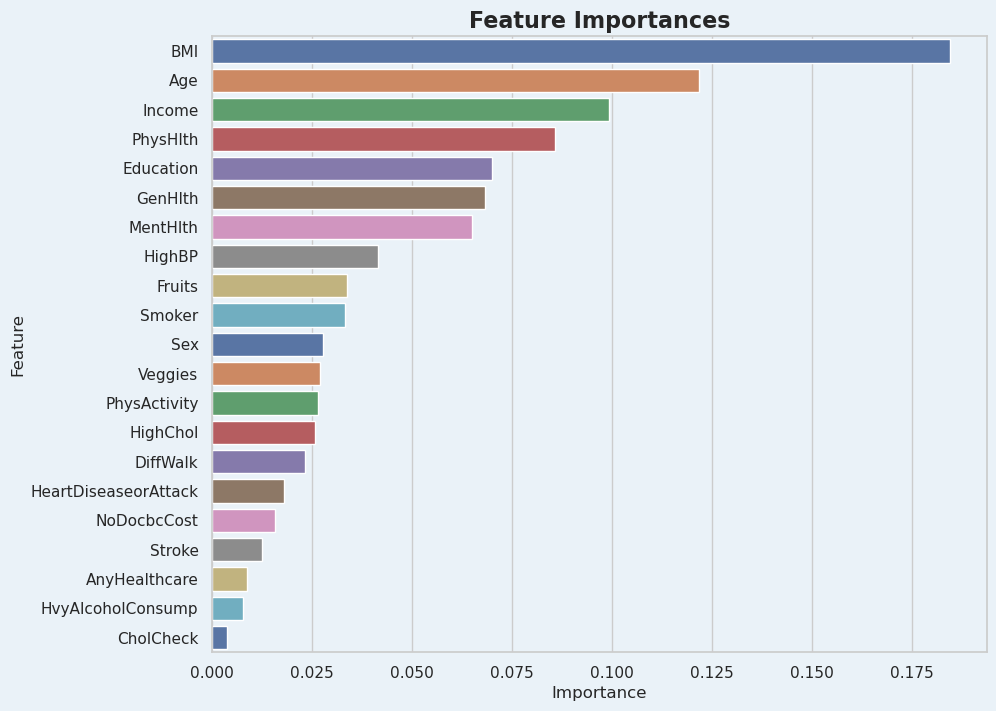

/tmp/ipykernel_481449/136790084.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette="deep", legend=False)


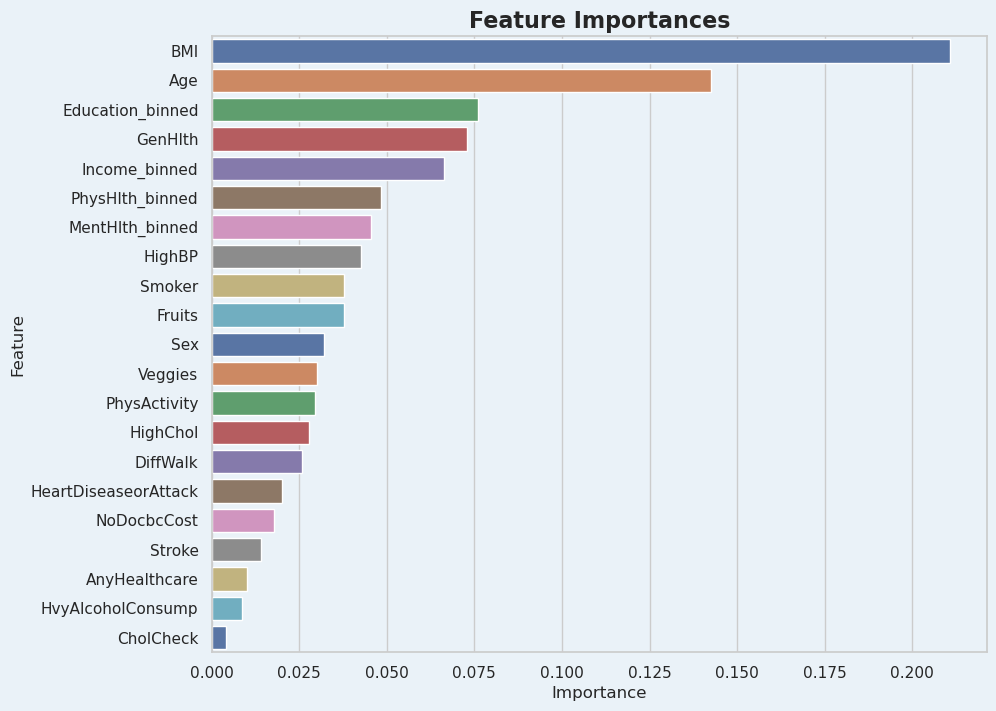

In [45]:
def calculate_feature_importance(X, y):
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Initialize and train the model
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    # Calculate feature importances
    importances = model.feature_importances_
    feature_importance_df = pd.DataFrame({
        'Feature': X.columns,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)
    
    # Plot the feature importances
    plt.figure(figsize=(10, 8))
    sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette="deep", legend=False)

    plt.title('Feature Importances', fontsize=16, fontweight='bold')
    plt.show()
    
    return feature_importance_df

# Calculate and display the feature importances
orig_feature_importances = calculate_feature_importance(X.drop(columns=rebinned_features), y)
feature_importances = calculate_feature_importance(X.drop(columns=unrebinned_features), y)

### Compare _binned to non binned

#### 1. **PhysHlth vs. PhysHlth_binned:**
   - **Correlation with Target:**
     - **PhysHlth**: 0.16
     - **PhysHlth_binned**: 0.15
   - **Feature Importance:**
     - **PhysHlth**: Higher in importance than `PhysHlth_binned`.

   **Conclusion:** **PhysHlth** is stronger.

#### 2. **MentHlth vs. MentHlth_binned:**
   - **Correlation with Target:**
     - **MentHlth**: 0.033
     - **MentHlth_binned**: 0.059
   - **Feature Importance:**
     - **MentHlth_binned**: Higher in importance than `MentHlth`.

   **Conclusion:** **MentHlth_binned** is stronger.

#### 3. **Income vs. Income_binned:**
   - **Correlation with Target:**
     - **Income**: 0.14
     - **Income_binned**: 0.14
   - **Feature Importance:**
     - **Income_binned**: Higher in importance than `Income`.

   **Conclusion:** **Income_binned** is stronger.

#### 4. **Education vs. Education_binned:**
   - **Correlation with Target:**
     - **Education**: 0.11
     - **Education_binned**: 0.11
   - **Feature Importance:**
     - **Education_binned**: Higher in importance than `Education`.

   **Conclusion:** **Education_binned** is stronger.

#### Overall Comparison:
- **Stronger When Binned**: `MentHlth`, `Income`, and `Education` have stronger predictive power when binned.
- **Stronger in Original Form**: `PhysHlth` is slightly stronger in its original form.

#### Summary:
Most of the binned features (`MentHlth_binned`, `Income_binned`, and `Education_binned`) perform better than being unbinned with the exception of `PhysHlth`.  Since the change to `PhysHlth` is small, and it helps class imbalance a lot, I will be using it binned too and drop the original columns.

### Drop unrebinned


In [46]:
X.drop(columns=unrebinned_features,inplace=True,errors='ignore')
X.columns.to_list()


['HighBP',
 'HighChol',
 'CholCheck',
 'BMI',
 'Smoker',
 'Stroke',
 'HeartDiseaseorAttack',
 'PhysActivity',
 'Fruits',
 'Veggies',
 'HvyAlcoholConsump',
 'AnyHealthcare',
 'NoDocbcCost',
 'GenHlth',
 'DiffWalk',
 'Sex',
 'Age',
 'MentHlth_binned',
 'PhysHlth_binned',
 'Education_binned',
 'Income_binned']

### Feature to Feature Correlations

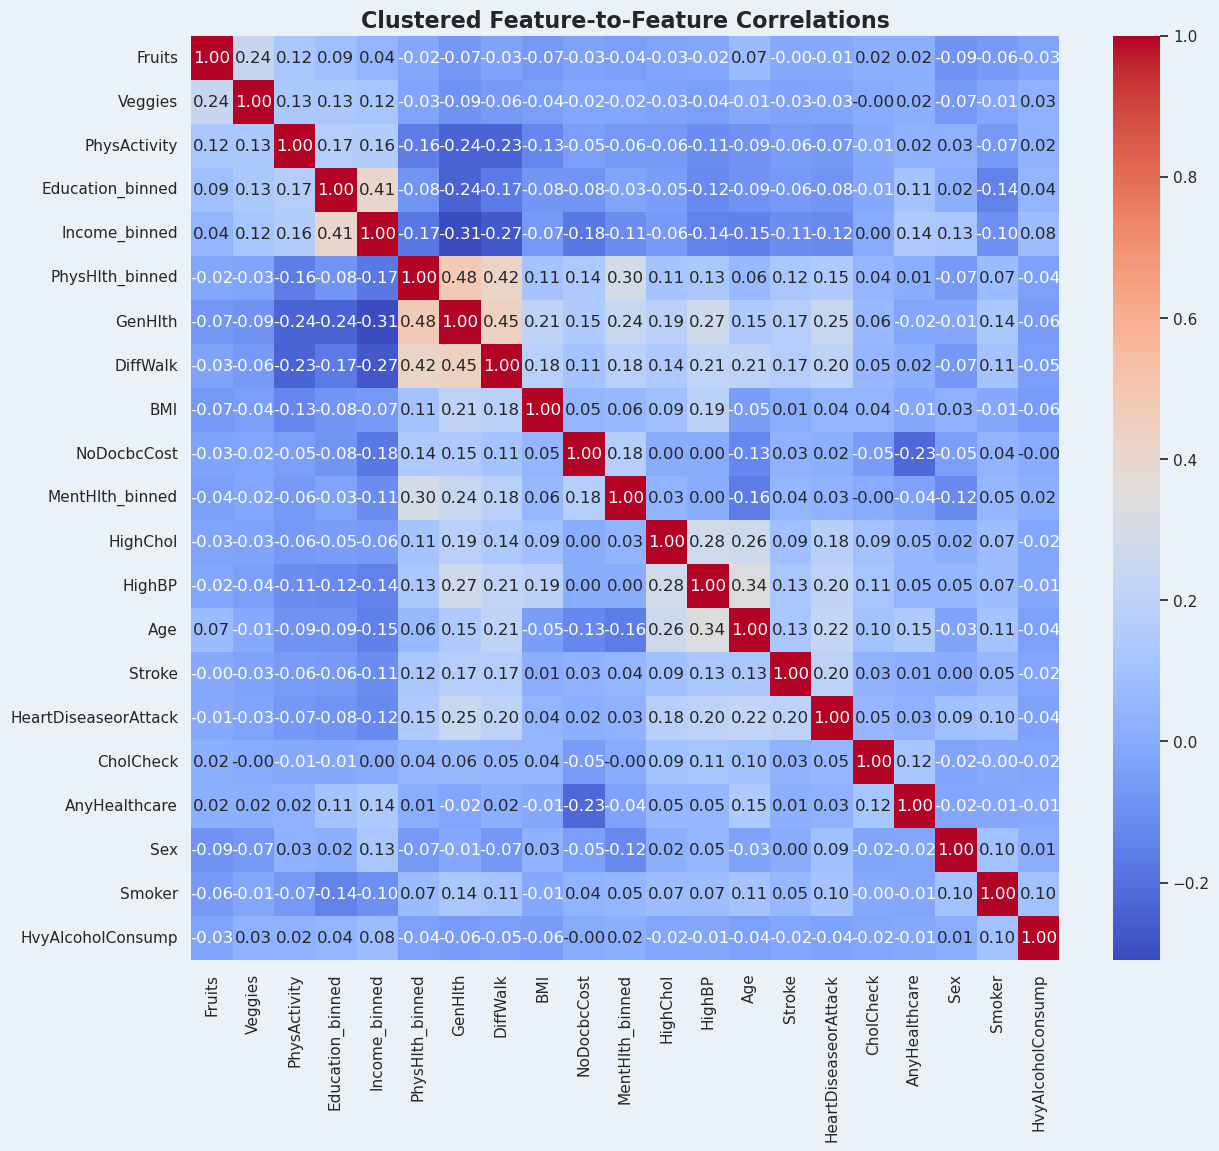

In [47]:
def feature_to_feature_correlations(X):
    # Calculate the correlation matrix
    corr_matrix = X.corr()
    
    # Perform hierarchical clustering on the correlation matrix
    linkage_matrix = linkage(corr_matrix, method='ward')  # You can also use other methods like 'average'
    
    # Get the order of the features after clustering
    ordered_indices = leaves_list(linkage_matrix)
    ordered_columns = corr_matrix.columns[ordered_indices]
    
    # Reorder the correlation matrix
    ordered_corr_matrix = corr_matrix.loc[ordered_columns, ordered_columns]
    
    # Use a heatmap to visualize the reordered correlations
    plt.figure(figsize=(14, 12))
    sns.heatmap(ordered_corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
    plt.title("Clustered Feature-to-Feature Correlations", fontsize=16, fontweight='bold')
    plt.show()
    
    return ordered_corr_matrix

# Calculate and display the feature to feature correlations
feature_correlations = feature_to_feature_correlations(X)

## Interaction Effects

In [48]:
# Define the dictionary with features to interact
interaction_dict = {
    'PhysHlth_binned': 'HighBP',
    'BMI': 'Age',
    'PhysActivity': 'BMI',
    'HighChol': 'HighBP',
    'MentHlth_binned': 'DiffWalk',
    'Income_binned': 'Education_binned',
    'Fruits': 'Veggies',
    'Smoker': 'HvyAlcoholConsump',
    'PhysHlth_binned': 'DiffWalk',
    'GenHlth': 'AnyHealthcare'
}

# Initialize an empty list to store the names of the interaction columns
interaction_cols = []

# Loop through the dictionary to create interaction features
for key, value in interaction_dict.items():
    interaction_name = f'{key}_{value}_interaction'
    X[interaction_name] = X[key] * X[value]
    interaction_cols.append(interaction_name)

# Display the list of created interaction columns
print(interaction_cols)

['PhysHlth_binned_DiffWalk_interaction', 'BMI_Age_interaction', 'PhysActivity_BMI_interaction', 'HighChol_HighBP_interaction', 'MentHlth_binned_DiffWalk_interaction', 'Income_binned_Education_binned_interaction', 'Fruits_Veggies_interaction', 'Smoker_HvyAlcoholConsump_interaction', 'GenHlth_AnyHealthcare_interaction']


### Interaction Importances

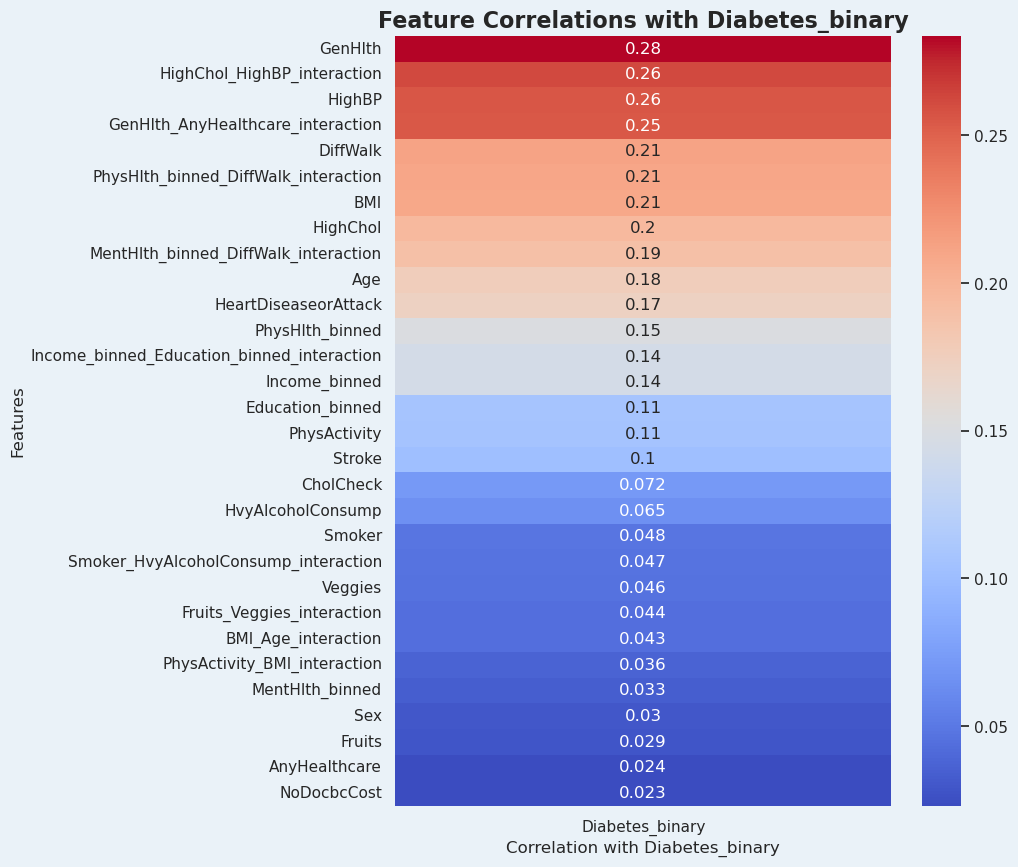

In [49]:
feature_to_target_correlation_heatmap(X,y)

/tmp/ipykernel_481449/136790084.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette="deep", legend=False)


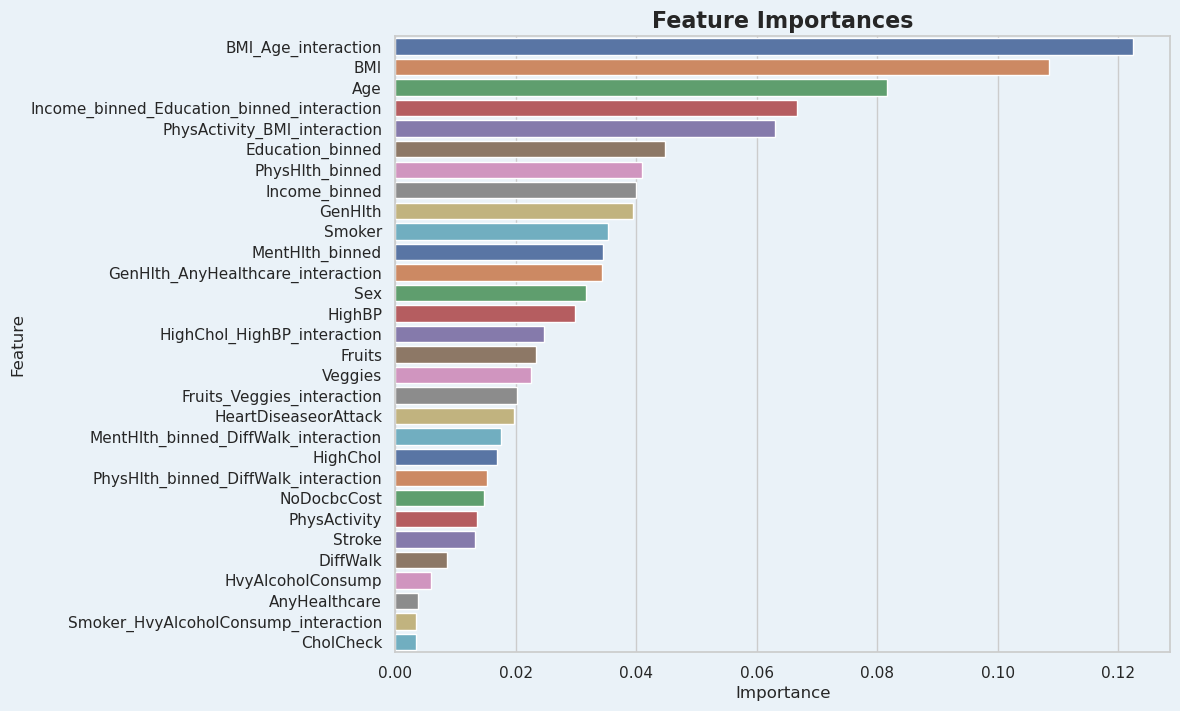

In [50]:
int_feature_importances = calculate_feature_importance(X, y)

# Sampling For Balance

## Initial Balance

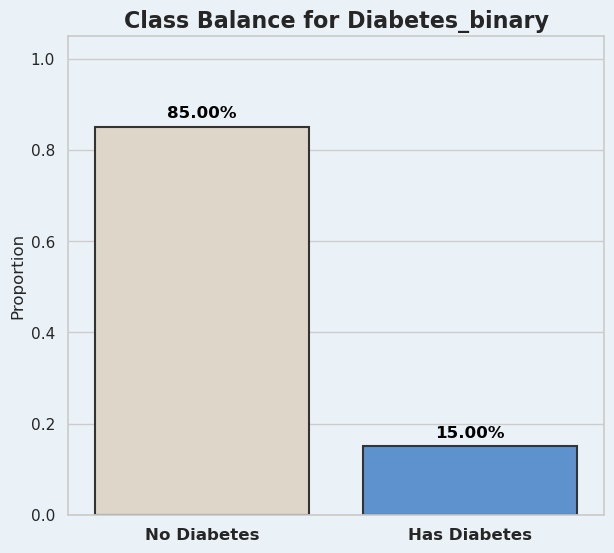

In [51]:

binary_labels['Diabetes_binary'] = ('No Diabetes','Has Diabetes')
plot_binary_class_balances(['Diabetes_binary'], y)


Great!  Now we are ready to split the data and then model

# Test Train Split on Full Data

In [52]:
#Split the full dataset into a temporary set and a holdout set
X_temp, X_holdout, y_temp, y_holdout = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

#Further split the temporary set into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp)

# Display the shape of the resulting splits
print("Train set size:", X_train.shape)
print("Test set size:", X_test.shape)
print("Holdout set size:", X_holdout.shape)

Train set size: (136744, 30)
Test set size: (45582, 30)
Holdout set size: (45582, 30)


In [53]:
y_train.value_counts(normalize=True)

Diabetes_binary
0                  0.850034
1                  0.149966
Name: proportion, dtype: float64

## Undersample Balance

Undersampled dataset size: (54686, 31)


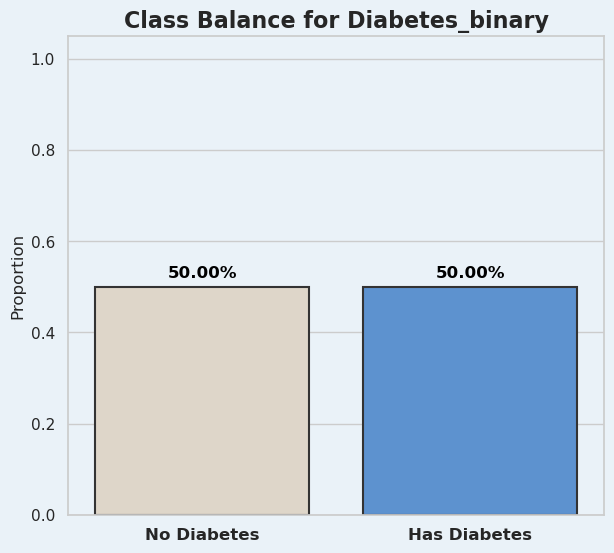

In [54]:
# First, combine X_temp and y_temp into a single DataFrame to make resampling easier
temp_df = pd.concat([X_temp, y_temp], axis=1)

# Separate the majority and minority classes
majority_class = temp_df[temp_df['Diabetes_binary'] == 0]
minority_class = temp_df[temp_df['Diabetes_binary'] == 1]

# Undersample the majority class to match the size of the minority class
majority_class_undersampled = resample(majority_class, 
                                       replace=False,  # sample without replacement
                                       n_samples=len(minority_class),  # match minority class
                                       random_state=42)  # reproducible results

# Combine the undersampled majority class with the minority class to create the undersampled dataset
undersampled_dataset = pd.concat([majority_class_undersampled, minority_class])

# Separate the features and target from the undersampled dataset
uX = undersampled_dataset.drop(columns=['Diabetes_binary'])
uy = undersampled_dataset['Diabetes_binary']

# Display the shape of the undersampled dataset
print("Undersampled dataset size:", undersampled_dataset.shape)

# Plot the class balance for the target variable
# Assuming plot_binary_class_balances is a function you have defined elsewhere
plot_binary_class_balances(['Diabetes_binary'], undersampled_dataset)

## Test Train Split Undersampled Set

In [55]:
# Split the undersampled dataset into training and test sets
uX_train, uX_test, uy_train, uy_test = train_test_split(uX, uy, test_size=0.2, random_state=42, stratify=uy)

# Display the shape of the resulting splits
print("uX_train set size:", uX_train.shape)
print("uX_test set size:", uX_test.shape)
print("uy_train set size:", uy_train.shape)
print("uy_test set size:", uy_test.shape)

# Check the class distribution in the training set
print(uy_train.value_counts(normalize=True))

uX_train set size: (43748, 30)
uX_test set size: (10938, 30)
uy_train set size: (43748,)
uy_test set size: (10938,)
Diabetes_binary
1    0.5
0    0.5
Name: proportion, dtype: float64


# Utility Functions

In [56]:
def display_classification_report(y_true, y_pred, title="Classification Report"):
    # Generate the classification report as a dictionary
    report = classification_report(y_true, y_pred, output_dict=True, target_names=["No Diabetes", "Diabetes"])
    
    # Convert the dictionary to a pandas DataFrame for nicer formatting
    report_df = pd.DataFrame(report).transpose()

    # Display the classification report
    print(title)
    display(report_df)

In [57]:
# Initialize a global dictionary to store scores for different models
model_performance = {}

In [58]:
def evaluate_model(model, X_train, y_train, X_test, y_test, title="Model Evaluation"):
    # Predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Probabilities for ROC AUC and Precision-Recall Curves
    y_train_prob = model.predict_proba(X_train)[:, 1]
    y_test_prob = model.predict_proba(X_test)[:, 1]
    
    # Scores
    train_auc = roc_auc_score(y_train, y_train_prob)
    test_auc = roc_auc_score(y_test, y_test_prob)
    
    # Classification reports
    train_report = classification_report(y_train, y_train_pred, output_dict=True, target_names=["Train Class 0", "Train Class 1"])
    test_report = classification_report(y_test, y_test_pred, output_dict=True, target_names=["Test Class 0", "Test Class 1"])

    
    # Store recall, precision, and AUC scores for the test set in the global dictionary
    model_performance[title] = {
        "Test Class 0 Precision": test_report["Test Class 0"]["precision"],
        "Test Class 0 Recall": test_report["Test Class 0"]["recall"],
        "Test Class 1 Precision": test_report["Test Class 1"]["precision"],
        "Test Class 1 Recall": test_report["Test Class 1"]["recall"],
        "Test AUC": test_auc,
        "Test Accuracy": test_report['accuracy'],
    }
    
    # Define colors based on Seaborn palettes
    train_color = sns.color_palette("deep")[0]  # Typically blue in deep palette
    test_color = sns.color_palette("deep")[2]   # Typically red in deep palette
    
    # Plotting
    fig = plt.figure(figsize=(14, 25))  # Increased height to accommodate extra row
    gs = fig.add_gridspec(4, 2, height_ratios=[1, 1, 1, 1])
    
    # ROC AUC Curve
    ax1 = fig.add_subplot(gs[0, 0])
    fpr_train, tpr_train, _ = roc_curve(y_train, y_train_prob)
    ax1.plot(fpr_train, tpr_train, label=f'Train ROC AUC: {train_auc:.4f}', color=train_color)
    ax1.plot([0, 1], [0, 1], 'k--', lw=2)
    ax1.set_title('ROC AUC Curve - Train', fontsize=16)
    ax1.set_xlabel('False Positive Rate', fontsize=12)
    ax1.set_ylabel('True Positive Rate', fontsize=12)
    ax1.legend(loc='lower right')

    ax2 = fig.add_subplot(gs[0, 1])
    fpr_test, tpr_test, _ = roc_curve(y_test, y_test_prob)
    ax2.plot(fpr_test, tpr_test, label=f'Test ROC AUC: {test_auc:.4f}', color=test_color)
    ax2.plot([0, 1], [0, 1], 'k--', lw=2)
    ax2.set_title('ROC AUC Curve - Test', fontsize=16)
    ax2.set_xlabel('False Positive Rate', fontsize=12)
    ax2.set_ylabel('True Positive Rate', fontsize=12)
    ax2.legend(loc='lower right')
    
    # Precision-Recall Curves
    ax3 = fig.add_subplot(gs[1, 0])
    precision_train, recall_train, _ = precision_recall_curve(y_train, y_train_prob)
    ax3.plot(recall_train, precision_train, label=f'Train PR AUC: {auc(recall_train, precision_train):.4f}', color=train_color)
    ax3.set_title('Precision-Recall Curve - Train', fontsize=16)
    ax3.set_xlabel('Recall', fontsize=12)
    ax3.set_ylabel('Precision', fontsize=12)
    ax3.legend(loc='lower left')

    ax4 = fig.add_subplot(gs[1, 1])
    precision_test, recall_test, _ = precision_recall_curve(y_test, y_test_prob)
    ax4.plot(recall_test, precision_test, label=f'Test PR AUC: {auc(recall_test, precision_test):.4f}', color=test_color)
    ax4.set_title('Precision-Recall Curve - Test', fontsize=16)
    ax4.set_xlabel('Recall', fontsize=12)
    ax4.set_ylabel('Precision', fontsize=12)
    ax4.legend(loc='lower left')
    
    # Confusion Matrices
    ax5 = fig.add_subplot(gs[2, 0])
    train_conf_matrix = confusion_matrix(y_train, y_train_pred)
    sns.heatmap(train_conf_matrix, annot=True, fmt="d", cmap=sns.light_palette(train_color, as_cmap=True), ax=ax5)
    ax5.set_title("Train Confusion Matrix", fontsize=16)
    ax5.set_xlabel("Predicted Label", fontsize=12)
    ax5.set_ylabel("True Label", fontsize=12)

    ax6 = fig.add_subplot(gs[2, 1])
    test_conf_matrix = confusion_matrix(y_test, y_test_pred)
    sns.heatmap(test_conf_matrix, annot=True, fmt="d", cmap=sns.light_palette(test_color, as_cmap=True), ax=ax6)
    ax6.set_title("Test Confusion Matrix", fontsize=16)
    ax6.set_xlabel("Predicted Label", fontsize=12)
    ax6.set_ylabel("True Label", fontsize=12)
    
    # Classification Report Plot
    ax7 = fig.add_subplot(gs[3, :])
    categories = ["precision", "recall", "f1-score", "accuracy"]
    train_metrics = [
        train_report["Train Class 0"]["precision"],
        train_report["Train Class 0"]["recall"],
        train_report["Train Class 0"]["f1-score"],
        train_report["Train Class 1"]["precision"],
        train_report["Train Class 1"]["recall"],
        train_report["Train Class 1"]["f1-score"],
        train_report["accuracy"]
    ]
    
    test_metrics = [
        test_report["Test Class 0"]["precision"],
        test_report["Test Class 0"]["recall"],
        test_report["Test Class 0"]["f1-score"],
        test_report["Test Class 1"]["precision"],
        test_report["Test Class 1"]["recall"],
        test_report["Test Class 1"]["f1-score"],
        test_report["accuracy"]
    ]
    
    bar_width = 0.35
    index = np.arange(len(train_metrics))
    
    ax7.bar(index, train_metrics, bar_width, label='Train', color=train_color)
    ax7.bar(index + bar_width, test_metrics, bar_width, label='Test', color=test_color)

    ax7.set_xticks(index + bar_width / 2)
    ax7.set_xticklabels(["0 Precision", "0 Recall", "0 F1", "1 Precision", "1 Recall", "1 F1", "Accuracy"], rotation=45)
    ax7.set_title("Classification Report Metrics", fontsize=16)
    ax7.legend()

    # Add the title to the entire figure
    fig.suptitle(title, fontsize=20, fontweight='bold')
    
    plt.tight_layout(rect=[0, 0, 1, 0.97])  # Adjust layout to make space for the suptitle
    plt.show()

    test_class_report = classification_report(y_test, y_test_pred, target_names=["Test Class 0", "Test Class 1"])
    print("Test Classification Report:\n", test_class_report)

# First Simple Model

In [59]:
# Initialize the Logistic Regression model
log_reg = LogisticRegression(random_state=42, max_iter=1000)

# Train the model on the training data
log_reg.fit(uX_train, uy_train)

/home/atrix/anaconda3/envs/pytorch-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=1000, random_state=42)

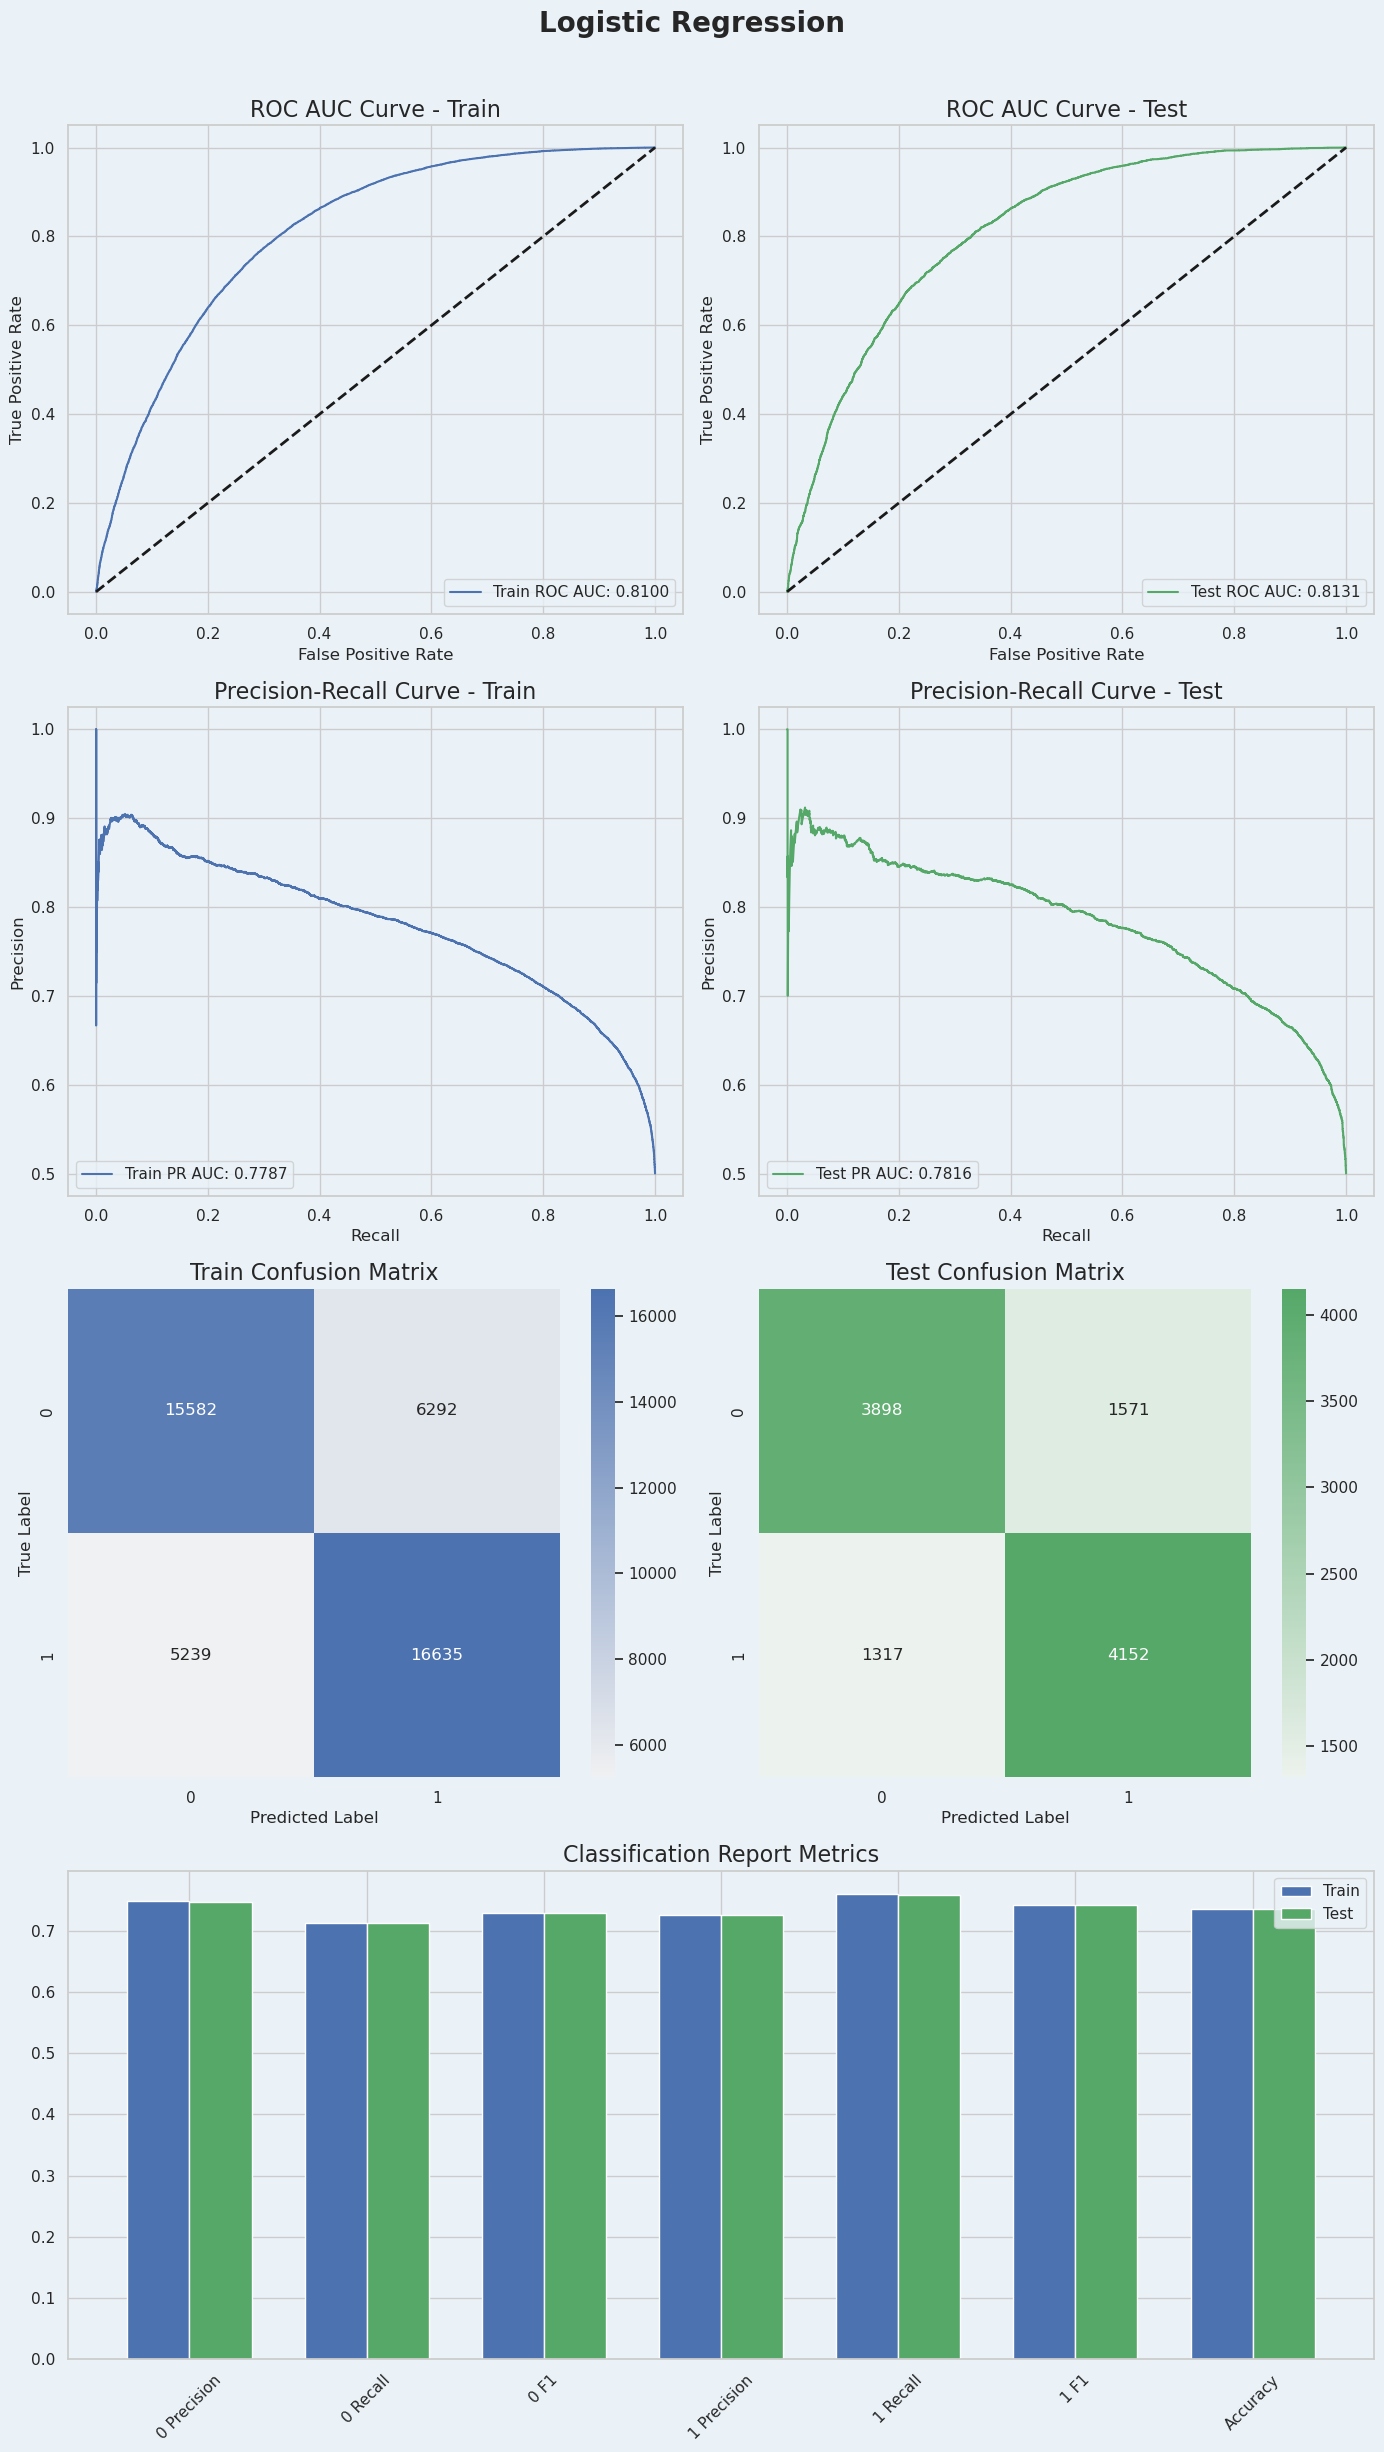

Test Classification Report:
               precision    recall  f1-score   support

Test Class 0       0.75      0.71      0.73      5469
Test Class 1       0.73      0.76      0.74      5469

    accuracy                           0.74     10938
   macro avg       0.74      0.74      0.74     10938
weighted avg       0.74      0.74      0.74     10938



In [60]:
# Evaluate the model
evaluate_model(log_reg, uX_train, uy_train, uX_test, uy_test,'Logistic Regression')

# Sample Models
Before spending a lot of time tuning models it's best to sample some promising ones for the data set and see which shows the best results before tuning.

## Random Forest

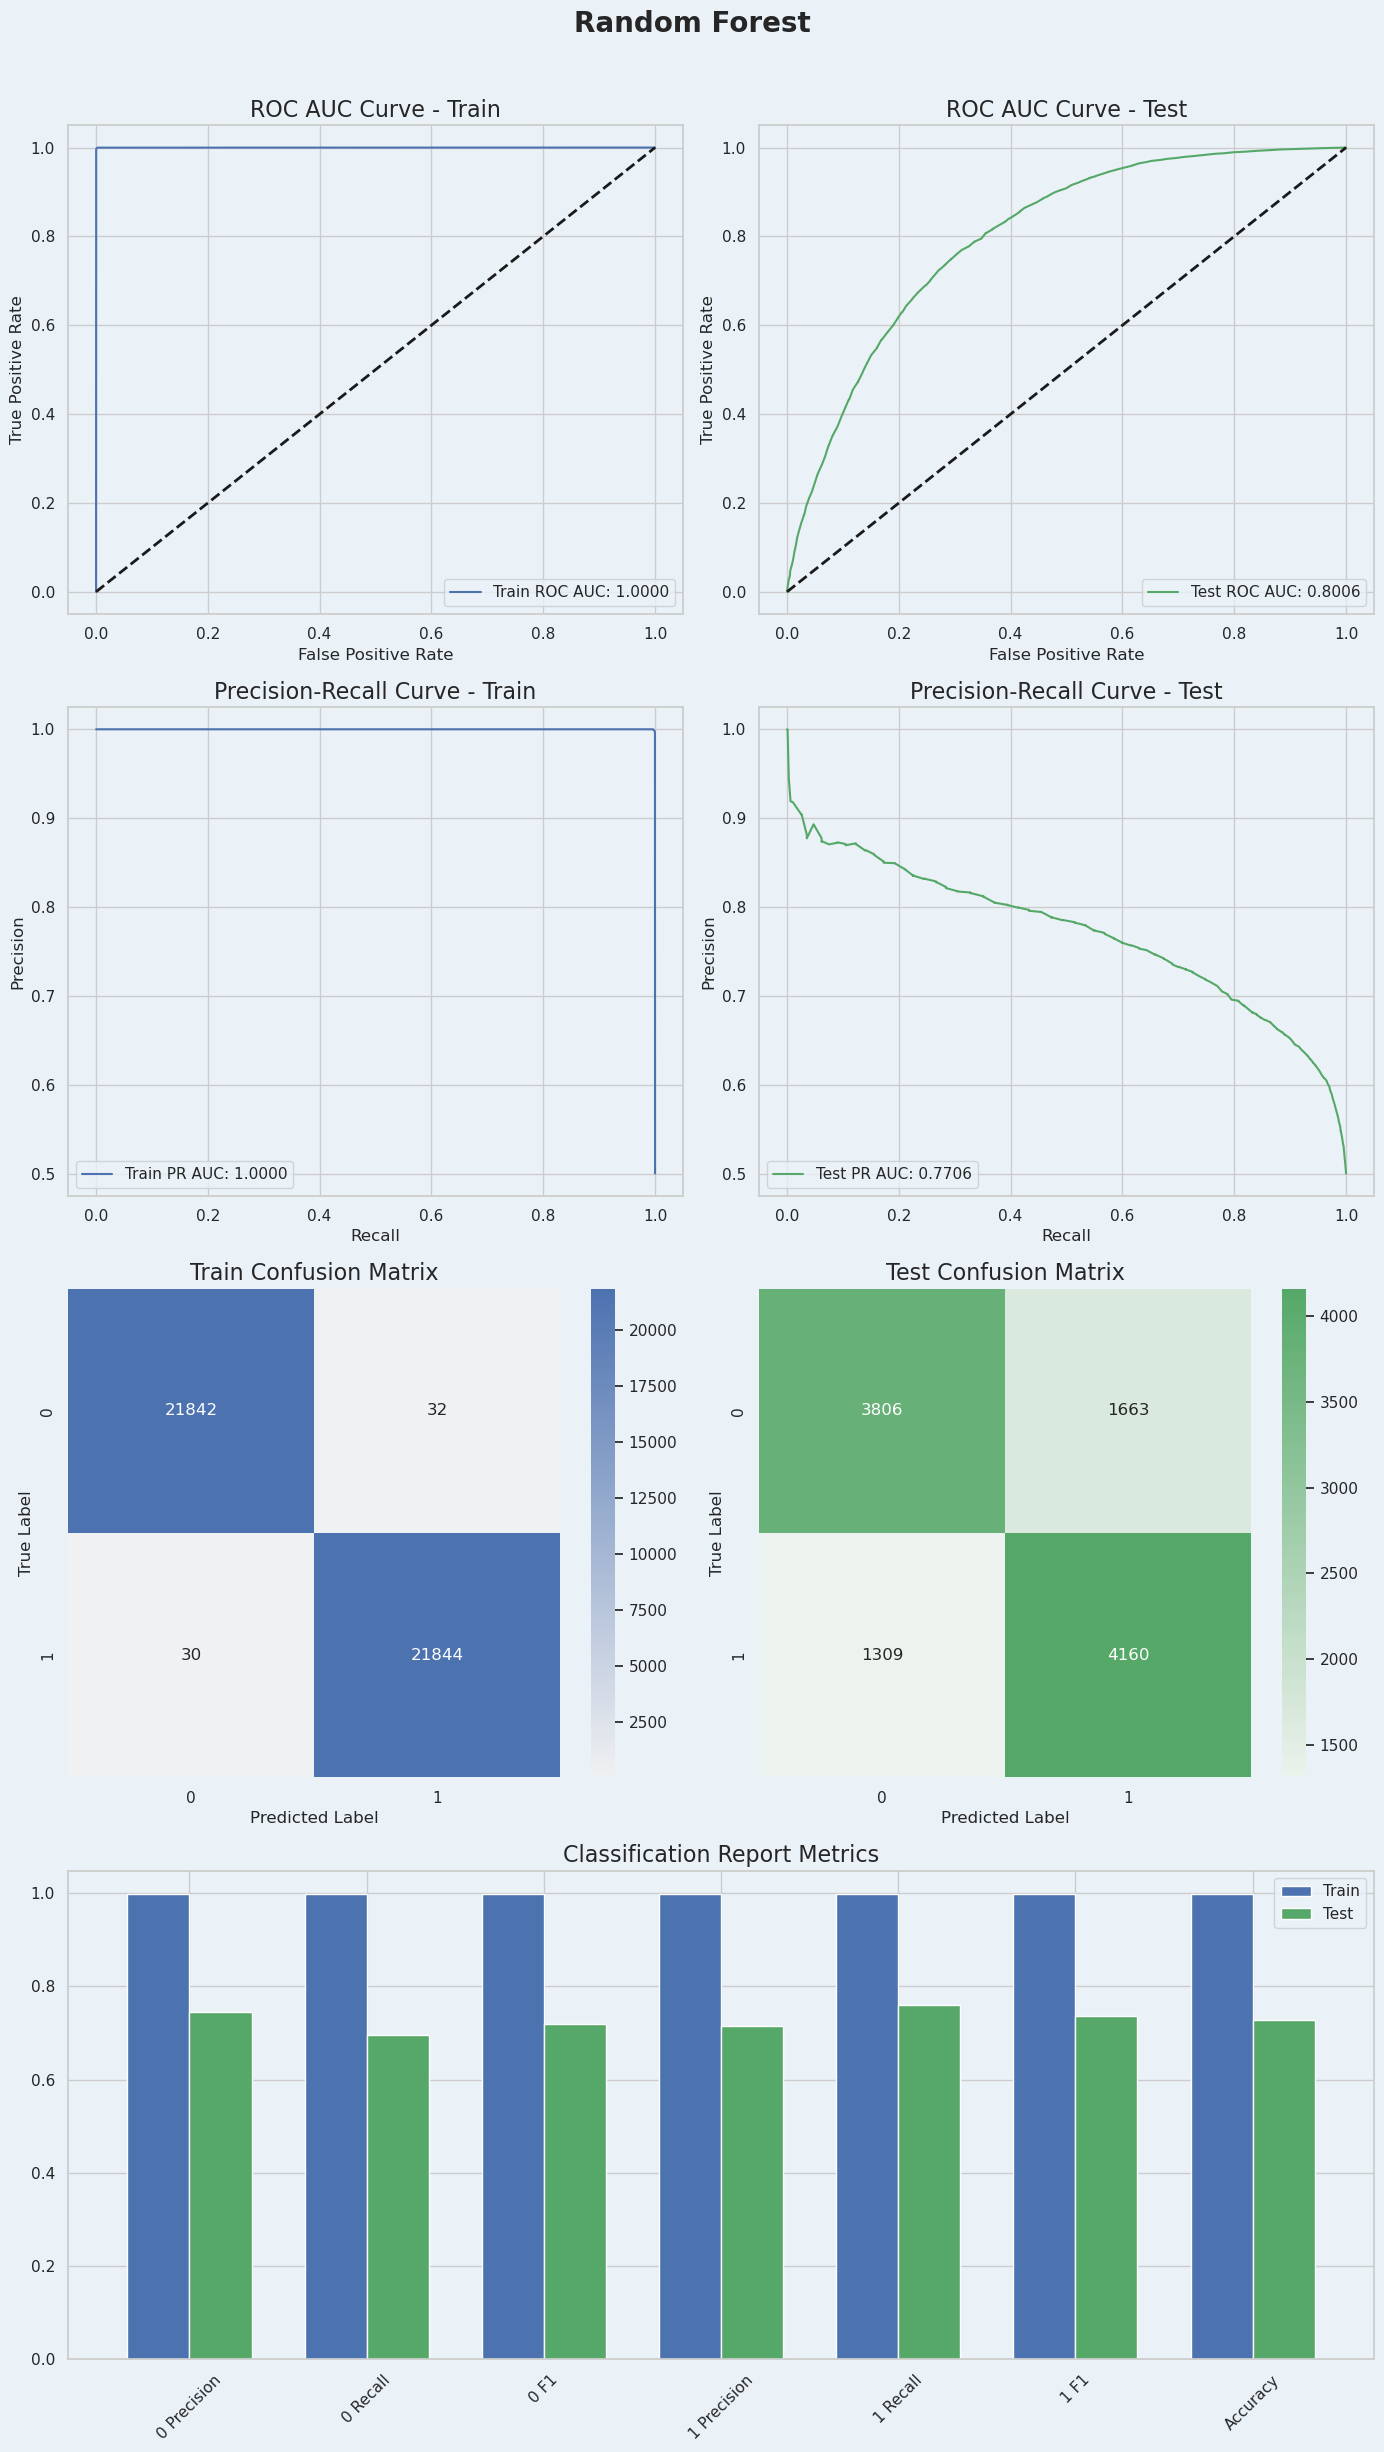

Test Classification Report:
               precision    recall  f1-score   support

Test Class 0       0.74      0.70      0.72      5469
Test Class 1       0.71      0.76      0.74      5469

    accuracy                           0.73     10938
   macro avg       0.73      0.73      0.73     10938
weighted avg       0.73      0.73      0.73     10938



In [61]:

# Initialize the Random Forest model
rf_model = RandomForestClassifier(random_state=42, n_estimators=100)

# Train the model on the training data
rf_model.fit(uX_train, uy_train)

# Evaluate the model
evaluate_model(rf_model, uX_train, uy_train, uX_test, uy_test,'Random Forest')


## XGBoost

In [62]:
# Initialize the XGBoost model with GPU support
xgb_model = xgb.XGBClassifier(
    random_state=42,
    eval_metric='logloss',
    tree_method='hist',  # Enable GPU support
    device='cuda'
)

# Train the model on the training data
xgb_model.fit(uX_train, uy_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device='cuda', early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

/home/atrix/anaconda3/envs/pytorch-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [12:45:45] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454449541/work/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


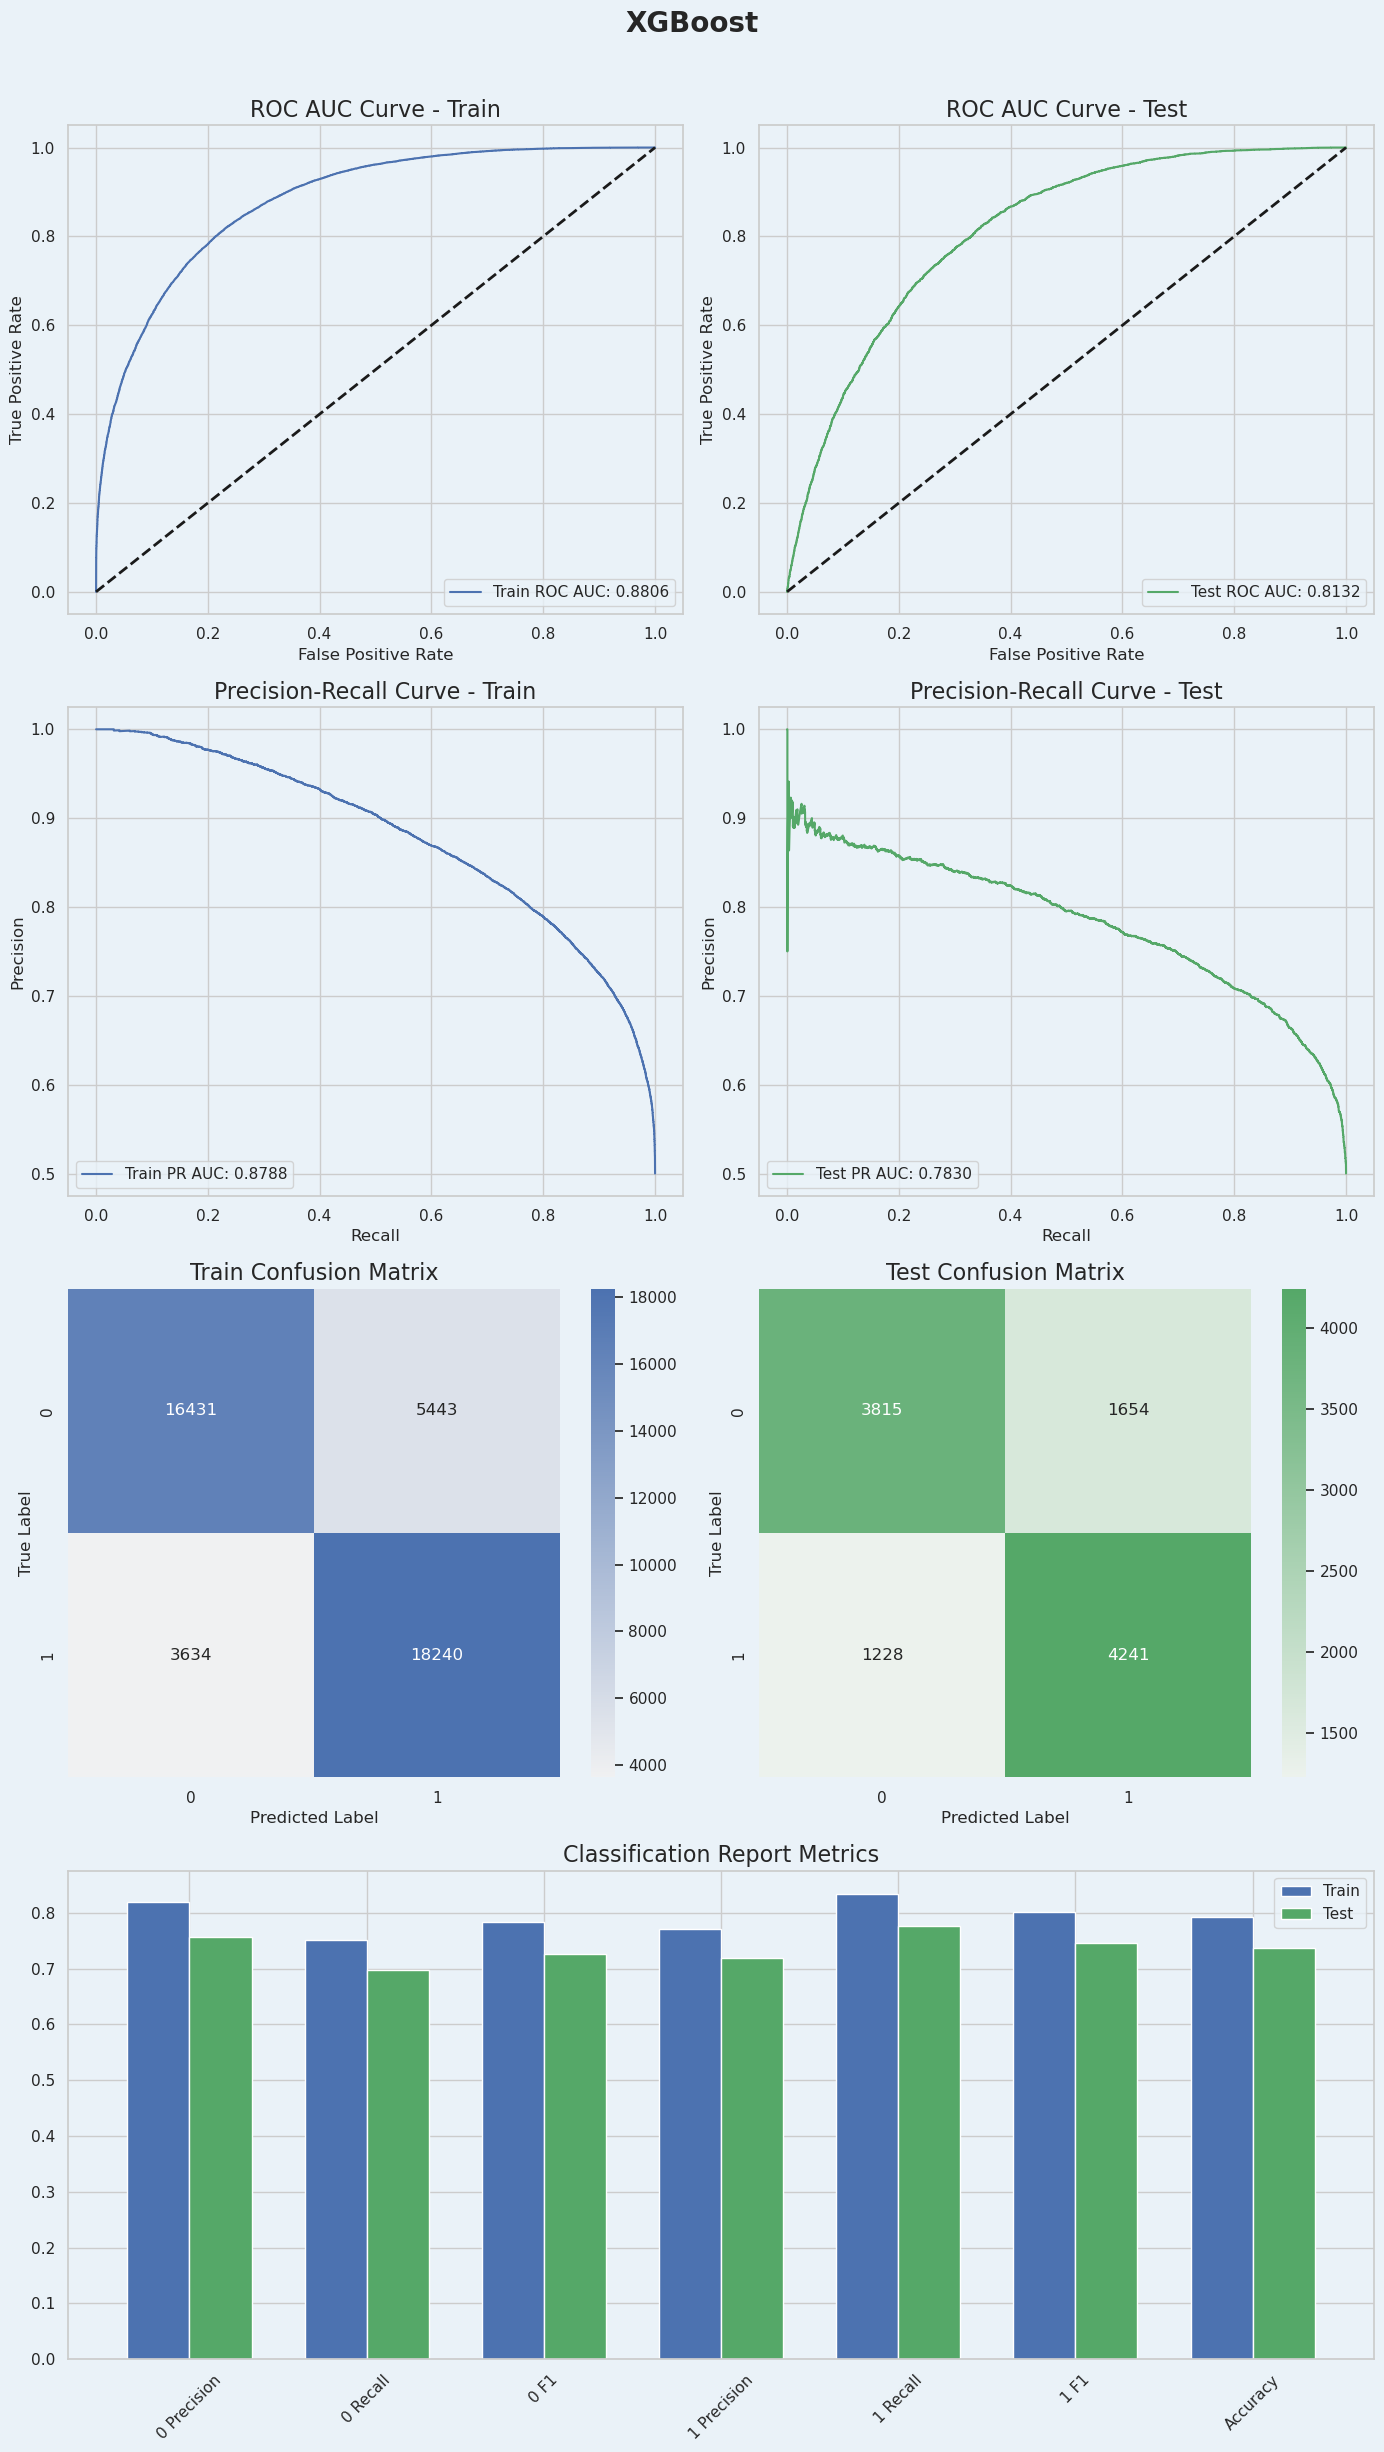

Test Classification Report:
               precision    recall  f1-score   support

Test Class 0       0.76      0.70      0.73      5469
Test Class 1       0.72      0.78      0.75      5469

    accuracy                           0.74     10938
   macro avg       0.74      0.74      0.74     10938
weighted avg       0.74      0.74      0.74     10938



In [63]:
# Evaluate the model
evaluate_model(xgb_model, uX_train, uy_train, uX_test, uy_test,'XGBoost')

## Catboost

In [64]:
# Initialize the CatBoost Classifier
catboost_model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.1,
    depth=6,
    eval_metric='Recall',
    random_seed=42,
    task_type="GPU"  # Ensures GPU usage
)

# Train the CatBoost model
catboost_model.fit(uX_train, uy_train, eval_set=(uX_test, uy_test), verbose=100, early_stopping_rounds=100)

0:	learn: 0.7530401	test: 0.7542512	best: 0.7542512 (0)	total: 50.5ms	remaining: 50.4s


100:	learn: 0.7913962	test: 0.7818614	best: 0.7849698 (47)	total: 2.22s	remaining: 19.8s
bestTest = 0.78496983
bestIteration = 47
Shrink model to first 48 iterations.


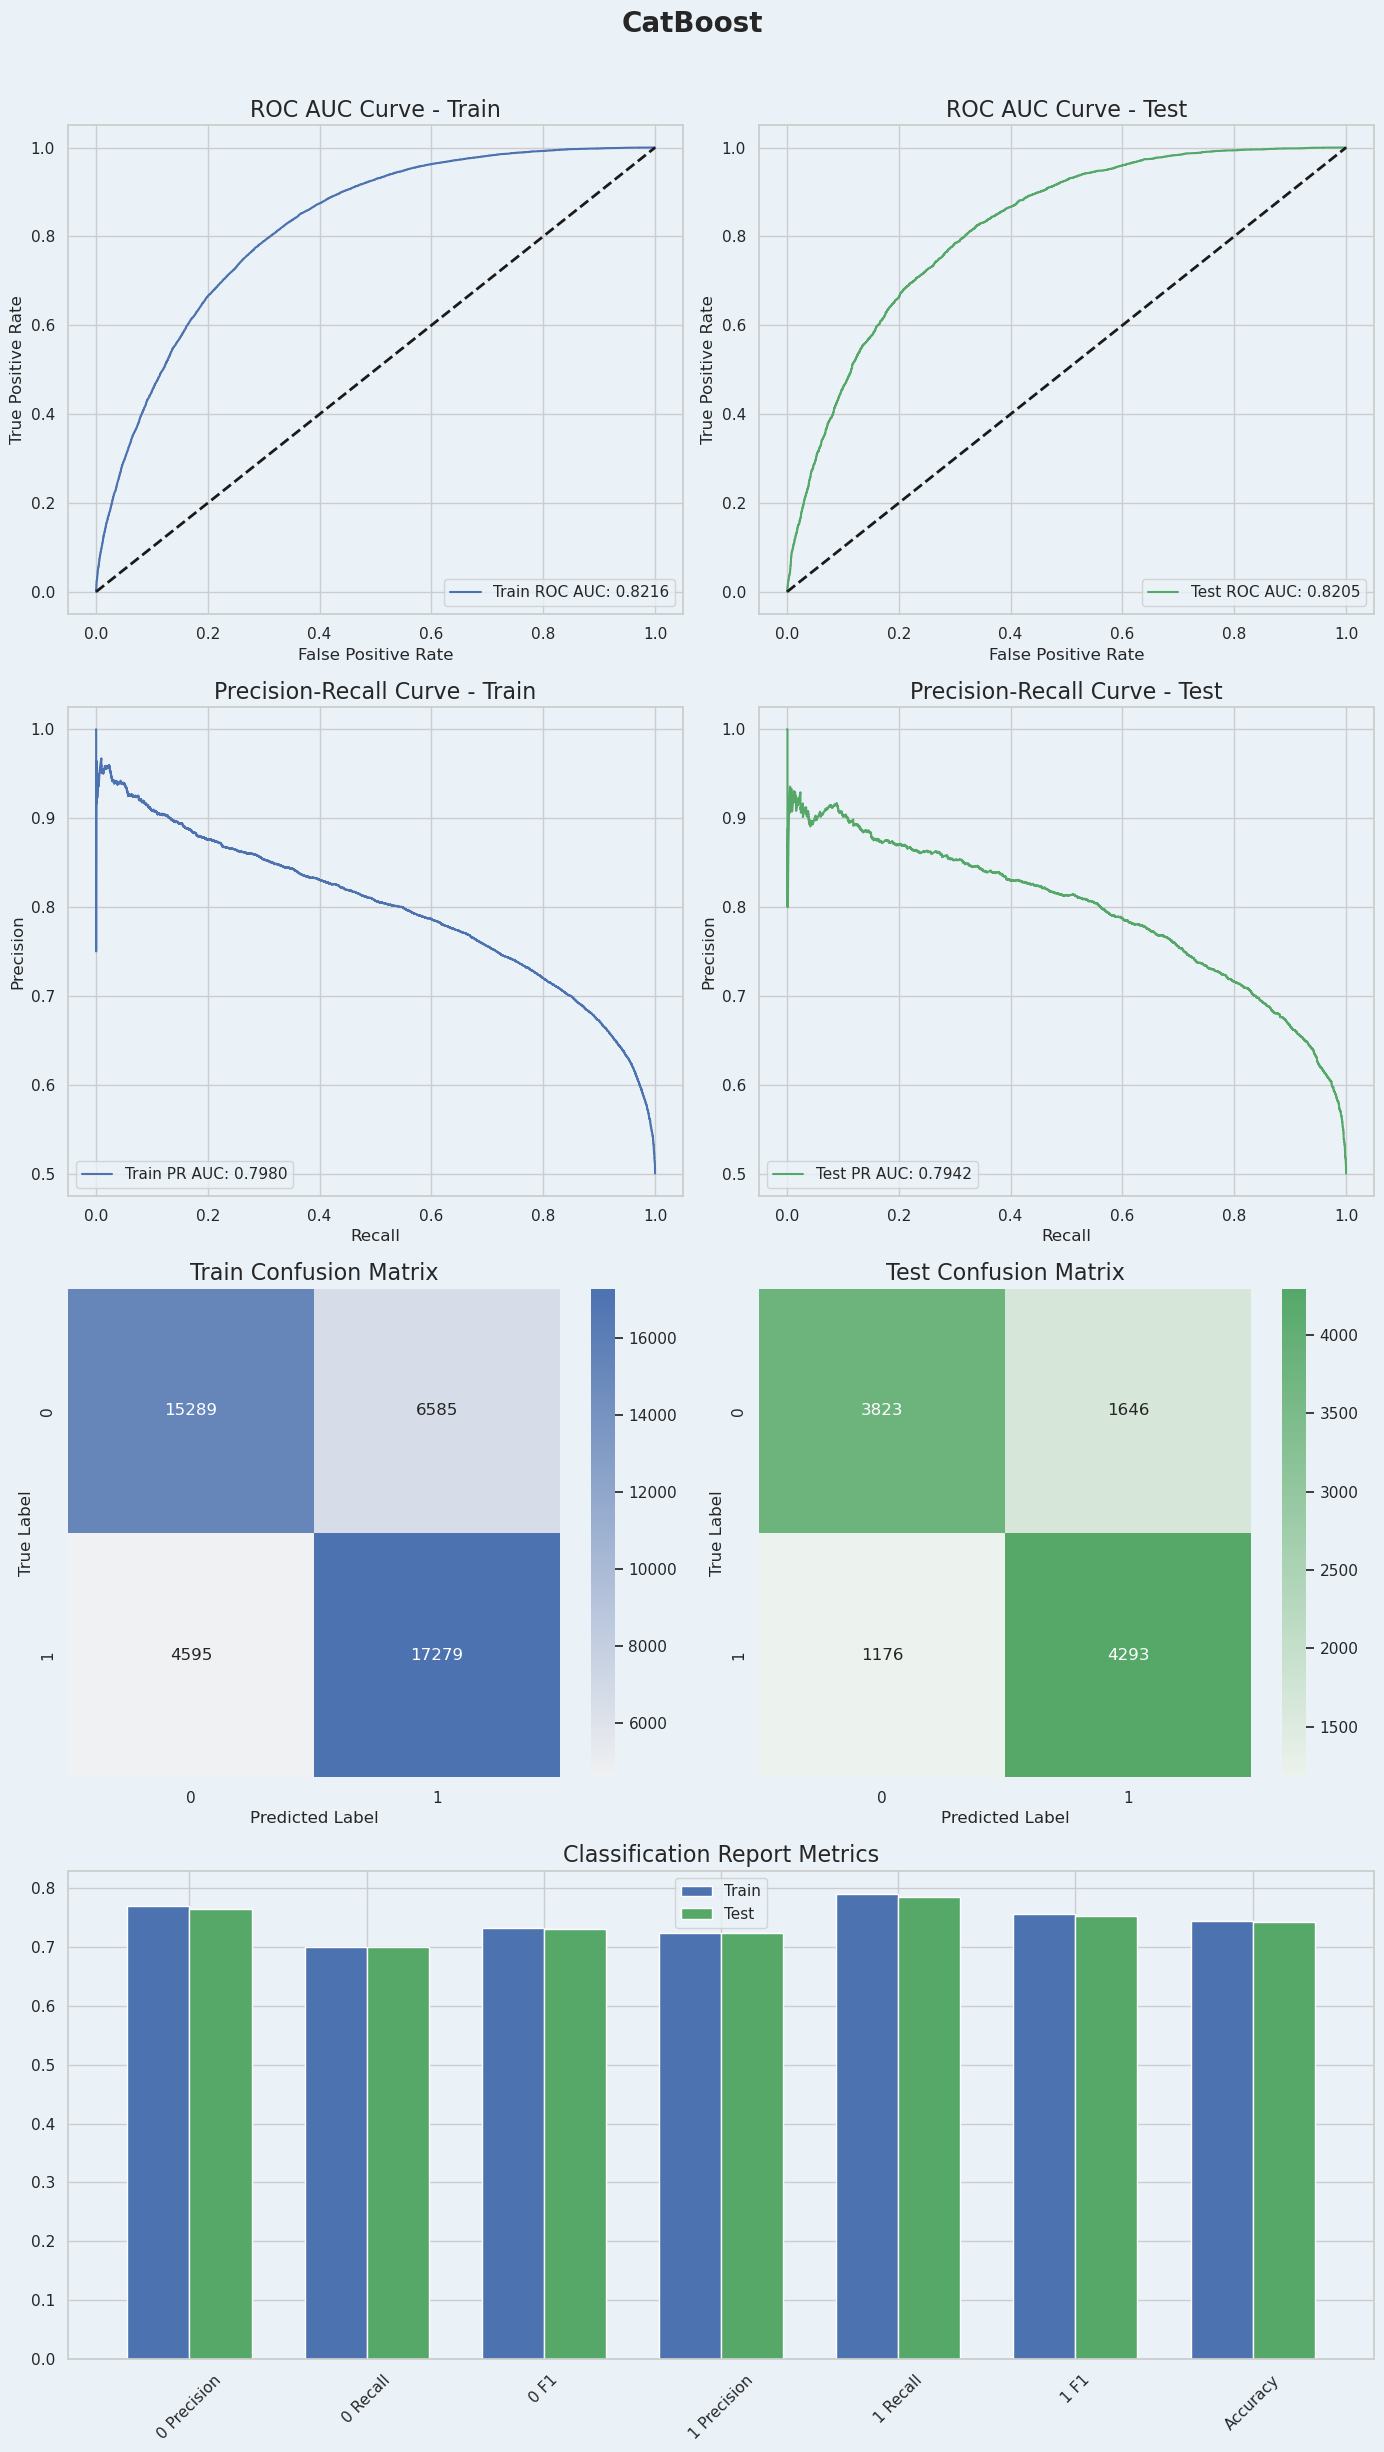

Test Classification Report:
               precision    recall  f1-score   support

Test Class 0       0.76      0.70      0.73      5469
Test Class 1       0.72      0.78      0.75      5469

    accuracy                           0.74     10938
   macro avg       0.74      0.74      0.74     10938
weighted avg       0.74      0.74      0.74     10938



In [65]:
# Evaluate the model
evaluate_model(catboost_model, uX_train, uy_train, uX_test, uy_test,'CatBoost')

## Naive Bayes Gaussian 

In [66]:
# Initialize the Gaussian Naive Bayes model
gnb = GaussianNB()

# Train the model on the training data
gnb.fit(uX_train, uy_train)

GaussianNB()

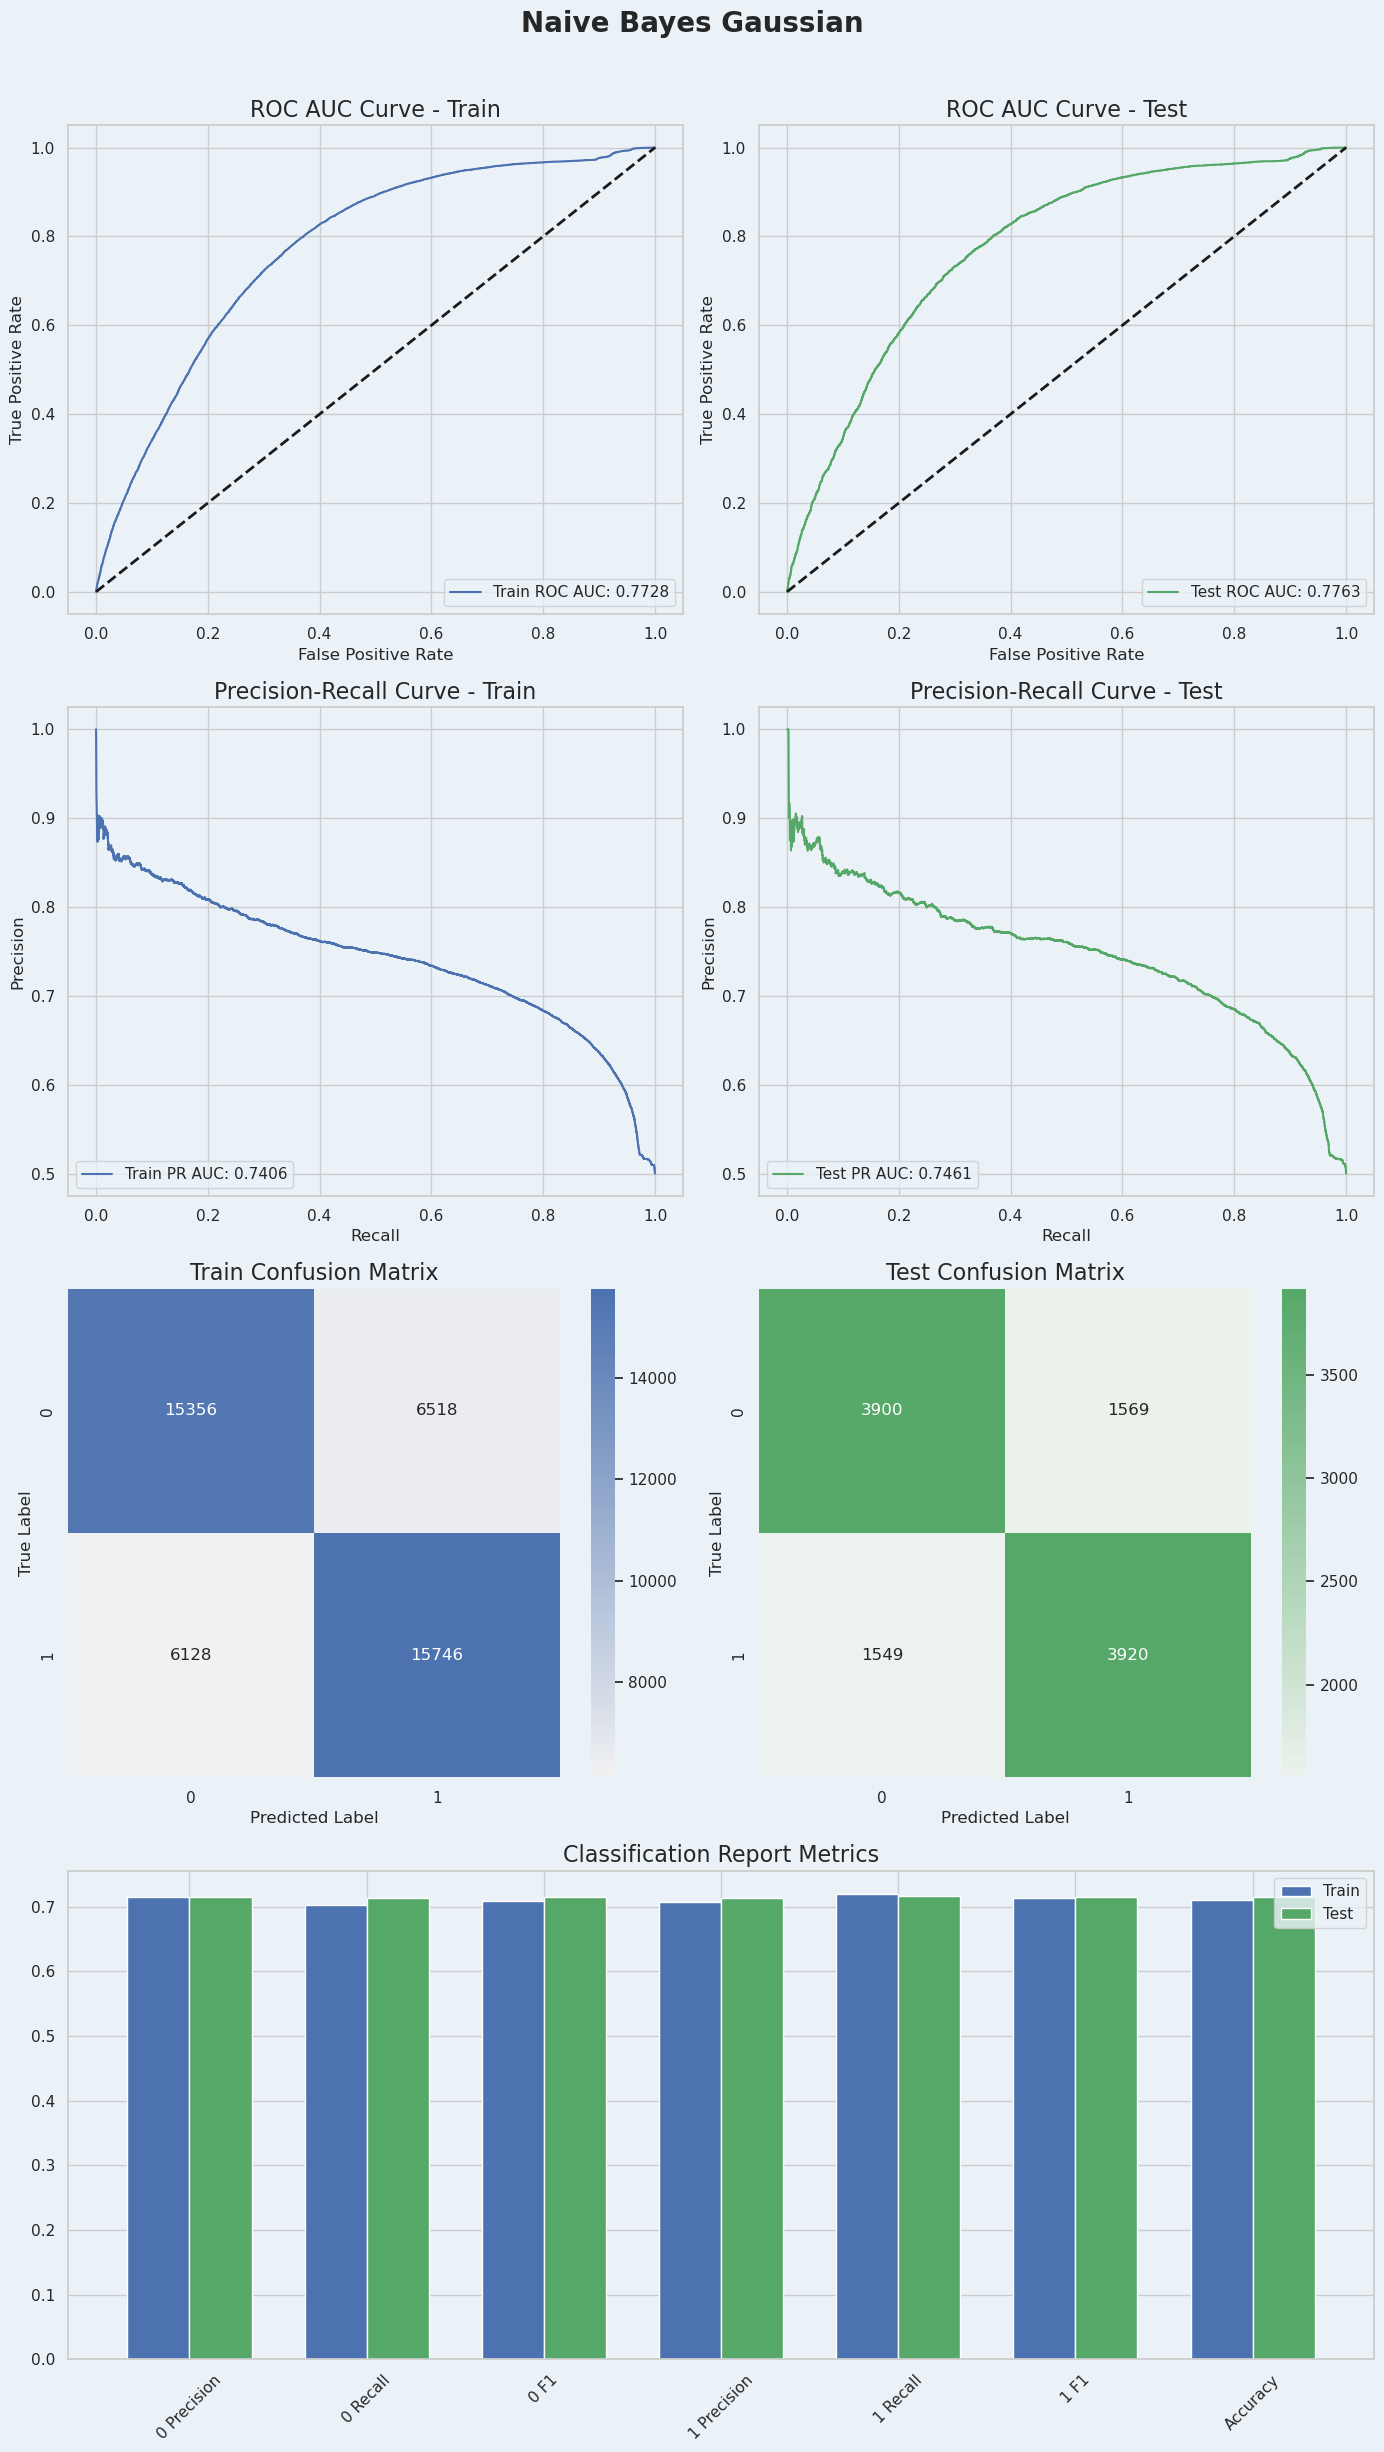

Test Classification Report:
               precision    recall  f1-score   support

Test Class 0       0.72      0.71      0.71      5469
Test Class 1       0.71      0.72      0.72      5469

    accuracy                           0.71     10938
   macro avg       0.71      0.71      0.71     10938
weighted avg       0.71      0.71      0.71     10938



In [67]:
# Evaluate the model using your custom evaluate_model function
evaluate_model(gnb, uX_train, uy_train, uX_test, uy_test,'Naive Bayes Gaussian')

## Evaluation Summary

In [68]:
def evaluation_summary():
    # Extract and sort the keys (model names) by AUC score in ascending order
    model_names = sorted(model_performance.keys(), key=lambda x: model_performance[x]["Test AUC"])

    # Extracting the metrics for each model in the sorted order
    test_class_0_precision = [model_performance[model]["Test Class 0 Precision"] for model in model_names]
    test_class_0_recall = [model_performance[model]["Test Class 0 Recall"] for model in model_names]
    test_class_1_precision = [model_performance[model]["Test Class 1 Precision"] for model in model_names]
    test_class_1_recall = [model_performance[model]["Test Class 1 Recall"] for model in model_names]
    test_auc = [model_performance[model]["Test AUC"] for model in model_names]
    test_accuracy = [model_performance[model]["Test Accuracy"] for model in model_names]

    # Increase the bar height to make the bars taller
    bar_height = 0.18  # Adjusted for taller bars
    group_spacing = bar_height * 8  # Increase this value to add more space between groups
    index = np.arange(len(model_names))

    # Set the color palette to 'deep'
    sns.set_palette("deep")

    # Create a figure and axis with appropriate size for full-width plotting
    fig, ax = plt.subplots(figsize=(18, 18))  # Adjusting size for large monitors

    # Plotting the bars for each metric in the correct order
    plt.barh(index * group_spacing + 3 * bar_height, test_auc, bar_height, label="Test AUC")
    plt.barh(index * group_spacing + 2 * bar_height, test_class_1_recall, bar_height, label="Test Class 1 Recall")
    plt.barh(index * group_spacing + 1 * bar_height, test_class_0_recall, bar_height, label="Test Class 0 Recall")
    plt.barh(index * group_spacing + 0 * bar_height, test_class_1_precision, bar_height, label="Test Class 1 Precision")
    plt.barh(index * group_spacing - 1 * bar_height, test_class_0_precision, bar_height, label="Test Class 0 Precision")
    plt.barh(index * group_spacing - 2 * bar_height, test_accuracy, bar_height, label="Test Accuracy")

    # Adding labels, title, and ticks
    ax.set_ylabel('Model', fontsize=14)
    ax.set_xlabel('Score', fontsize=14)
    ax.set_title('Model Performance Summary', fontsize=20, fontweight='bold', pad=20,fontfamily='DejaVu Sans')

    # Setting y-ticks with model names, placing them in the center of the group
    ax.set_yticks(index * group_spacing)
    ax.set_yticklabels(model_names, fontsize=14, fontweight='bold',fontfamily='DejaVu Sans')

    # Adjusting x-axis limit assuming all scores are between 0 and 1
    ax.set_xlim(0, 1)

    # Adding the actual values on top of the bars with a font size of 10
    for i in range(len(model_names)):
        ax.text(test_auc[i] + 0.01, index[i] * group_spacing + 3 * bar_height, f'{test_auc[i]:.3f}', va='center', fontsize=12)
        ax.text(test_class_1_recall[i] + 0.01, index[i] * group_spacing + 2 * bar_height, f'{test_class_1_recall[i]:.3f}', va='center', fontsize=12)
        ax.text(test_class_0_recall[i] + 0.01, index[i] * group_spacing + 1 * bar_height, f'{test_class_0_recall[i]:.3f}', va='center', fontsize=12)
        ax.text(test_class_1_precision[i] + 0.01, index[i] * group_spacing + 0 * bar_height, f'{test_class_1_precision[i]:.3f}', va='center', fontsize=12)
        ax.text(test_class_0_precision[i] + 0.01, index[i] * group_spacing - 1 * bar_height, f'{test_class_0_precision[i]:.3f}', va='center', fontsize=12)
        ax.text(test_accuracy[i] + 0.01, index[i] * group_spacing - 2 * bar_height, f'{test_accuracy[i]:.3f}', va='center', fontsize=12)

    # Adjusting the legend to be below the title and span the full width, with 3 rows
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.005), ncol=3, fontsize=10, frameon=True, facecolor='white', edgecolor='black')

    # Adjust layout to minimize extra space
    plt.subplots_adjust(top=0.85, bottom=0.1, left=0.05, right=0.95, hspace=0.2)

    # Display the plot
    plt.show()


## MLP as RBFNN

In [69]:
from sklearn.neural_network import MLPClassifier

# Initialize the RBF Neural Network model
rbf_nn = MLPClassifier(hidden_layer_sizes=(100,), activation='tanh', solver='adam', random_state=42)

# Train the model on the training data
rbf_nn.fit(uX_train, uy_train)

/home/atrix/anaconda3/envs/pytorch-env/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(activation='tanh', random_state=42)

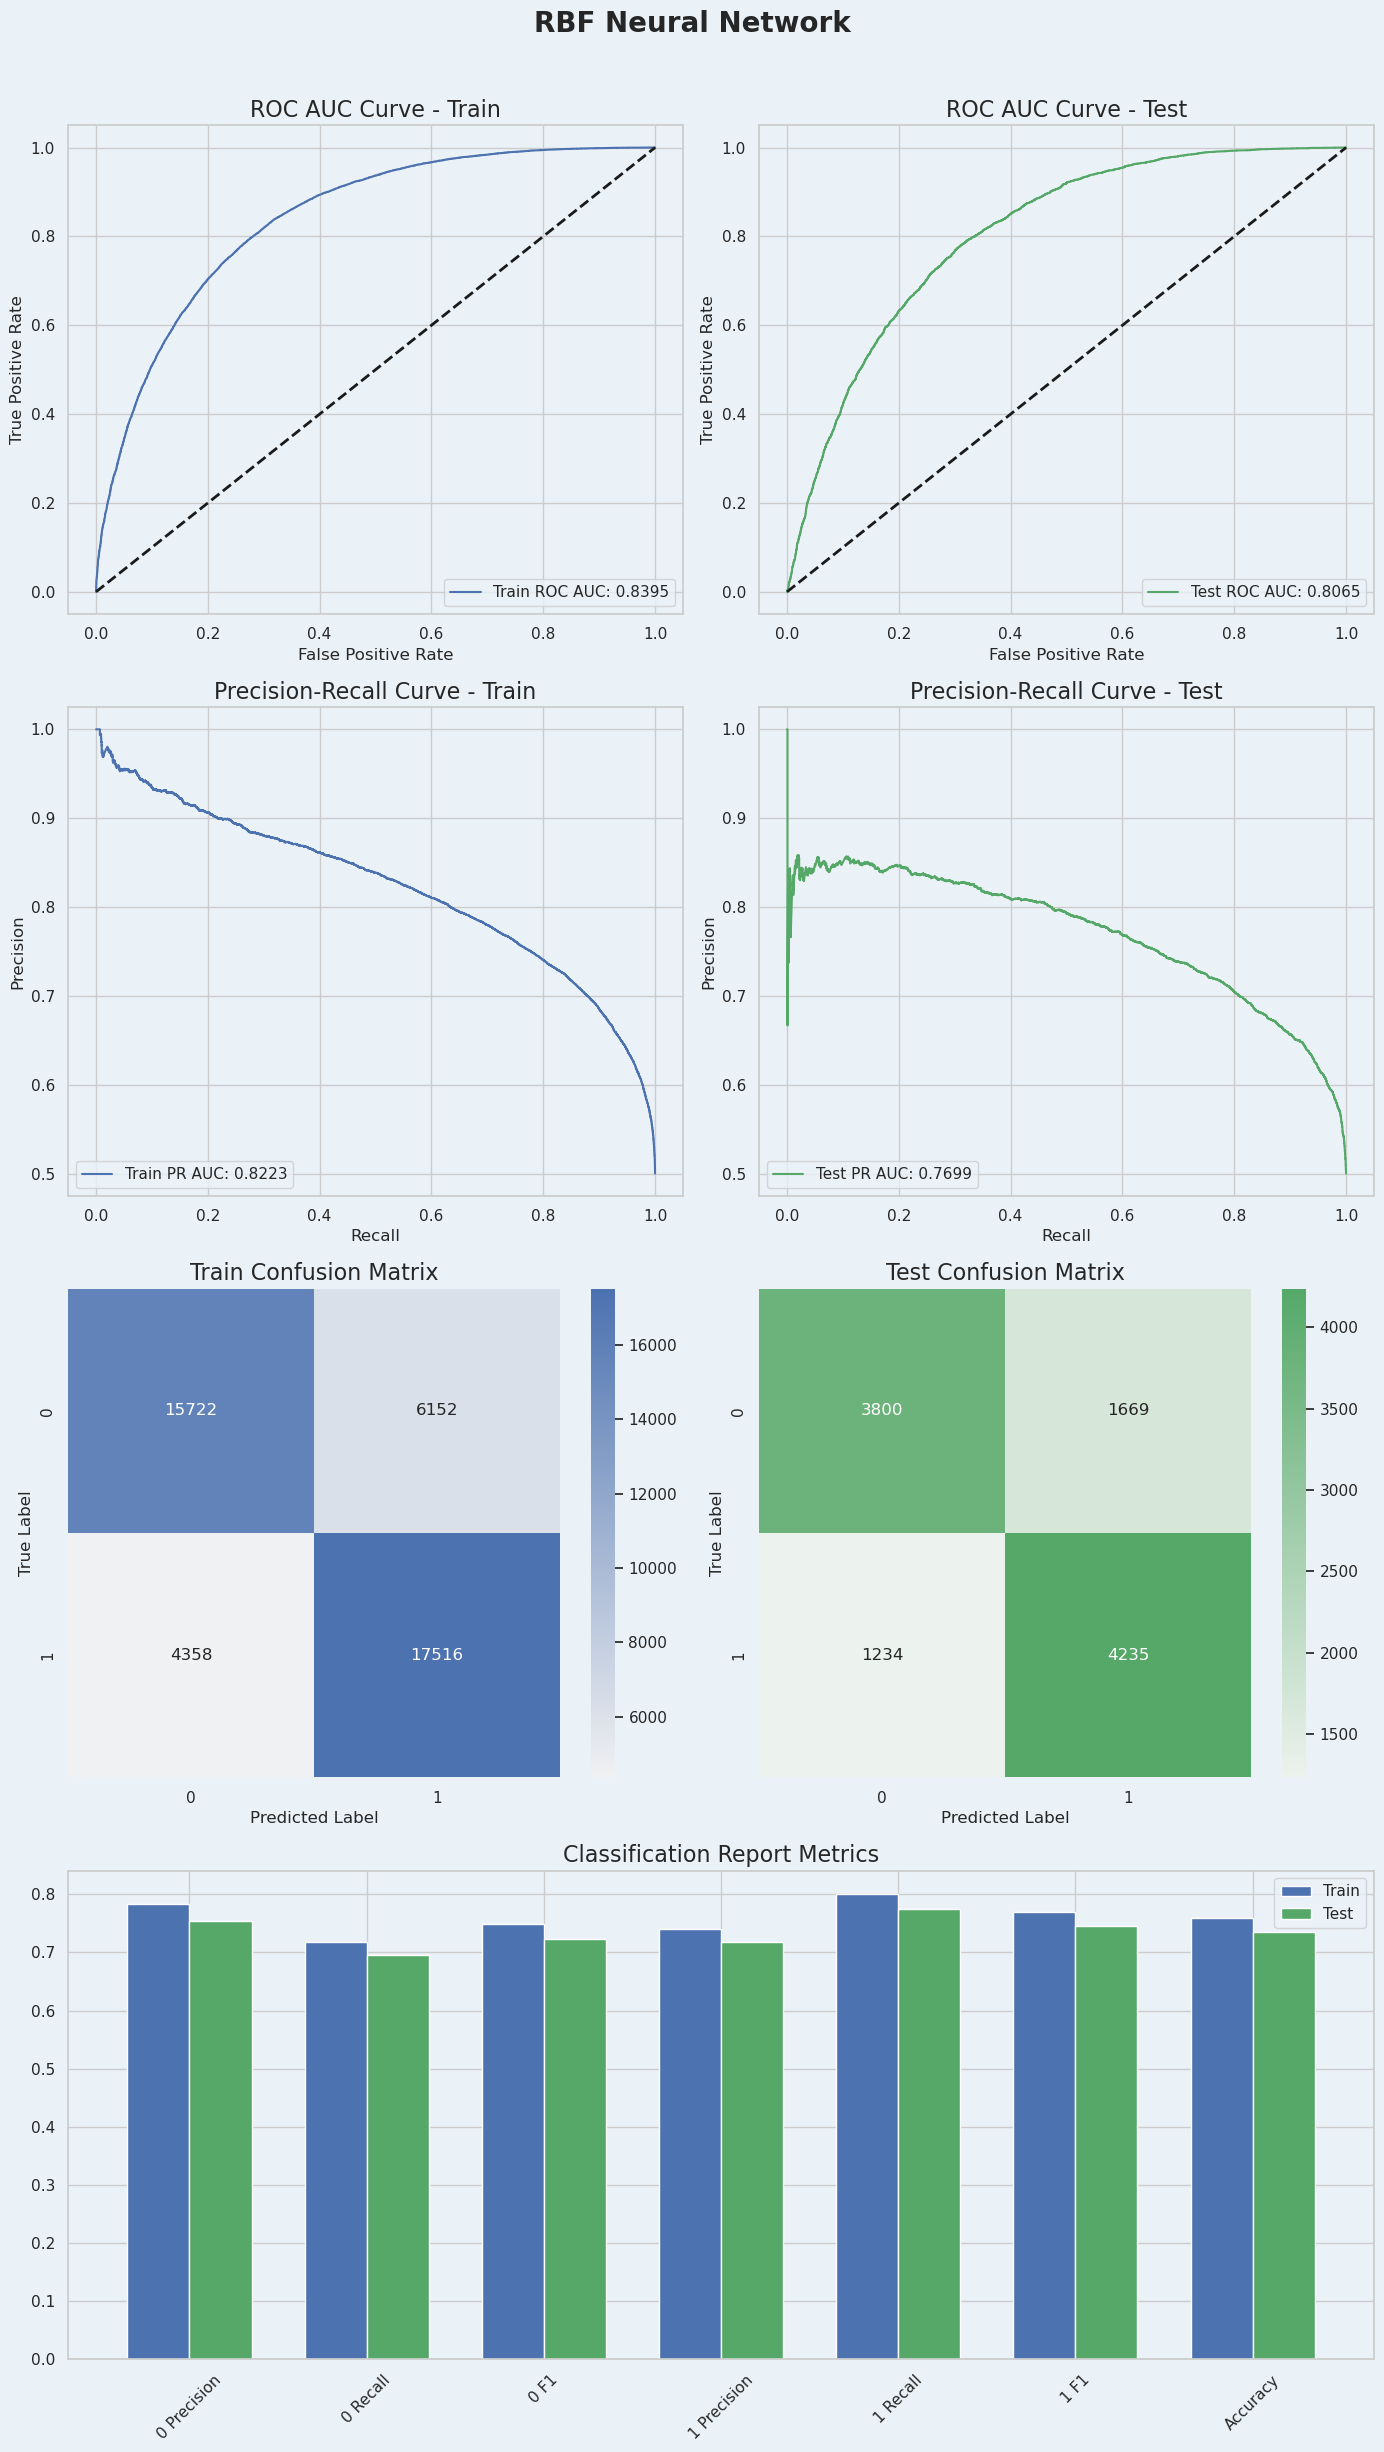

Test Classification Report:
               precision    recall  f1-score   support

Test Class 0       0.75      0.69      0.72      5469
Test Class 1       0.72      0.77      0.74      5469

    accuracy                           0.73     10938
   macro avg       0.74      0.73      0.73     10938
weighted avg       0.74      0.73      0.73     10938



In [70]:
# Evaluate the model
evaluate_model(rbf_nn, uX_train, uy_train, uX_test, uy_test, 'RBF Neural Network')

## SGDClassifier

In [71]:
from sklearn.linear_model import SGDClassifier

# Initialize the SGDClassifier with 'log_loss' (equivalent to Logistic Regression with SGD)
sgd_clf = SGDClassifier(loss='log_loss', penalty='l2', max_iter=1000, random_state=42)

# Train the model on the training data
sgd_clf.fit(uX_train, uy_train)


SGDClassifier(loss='log_loss', random_state=42)

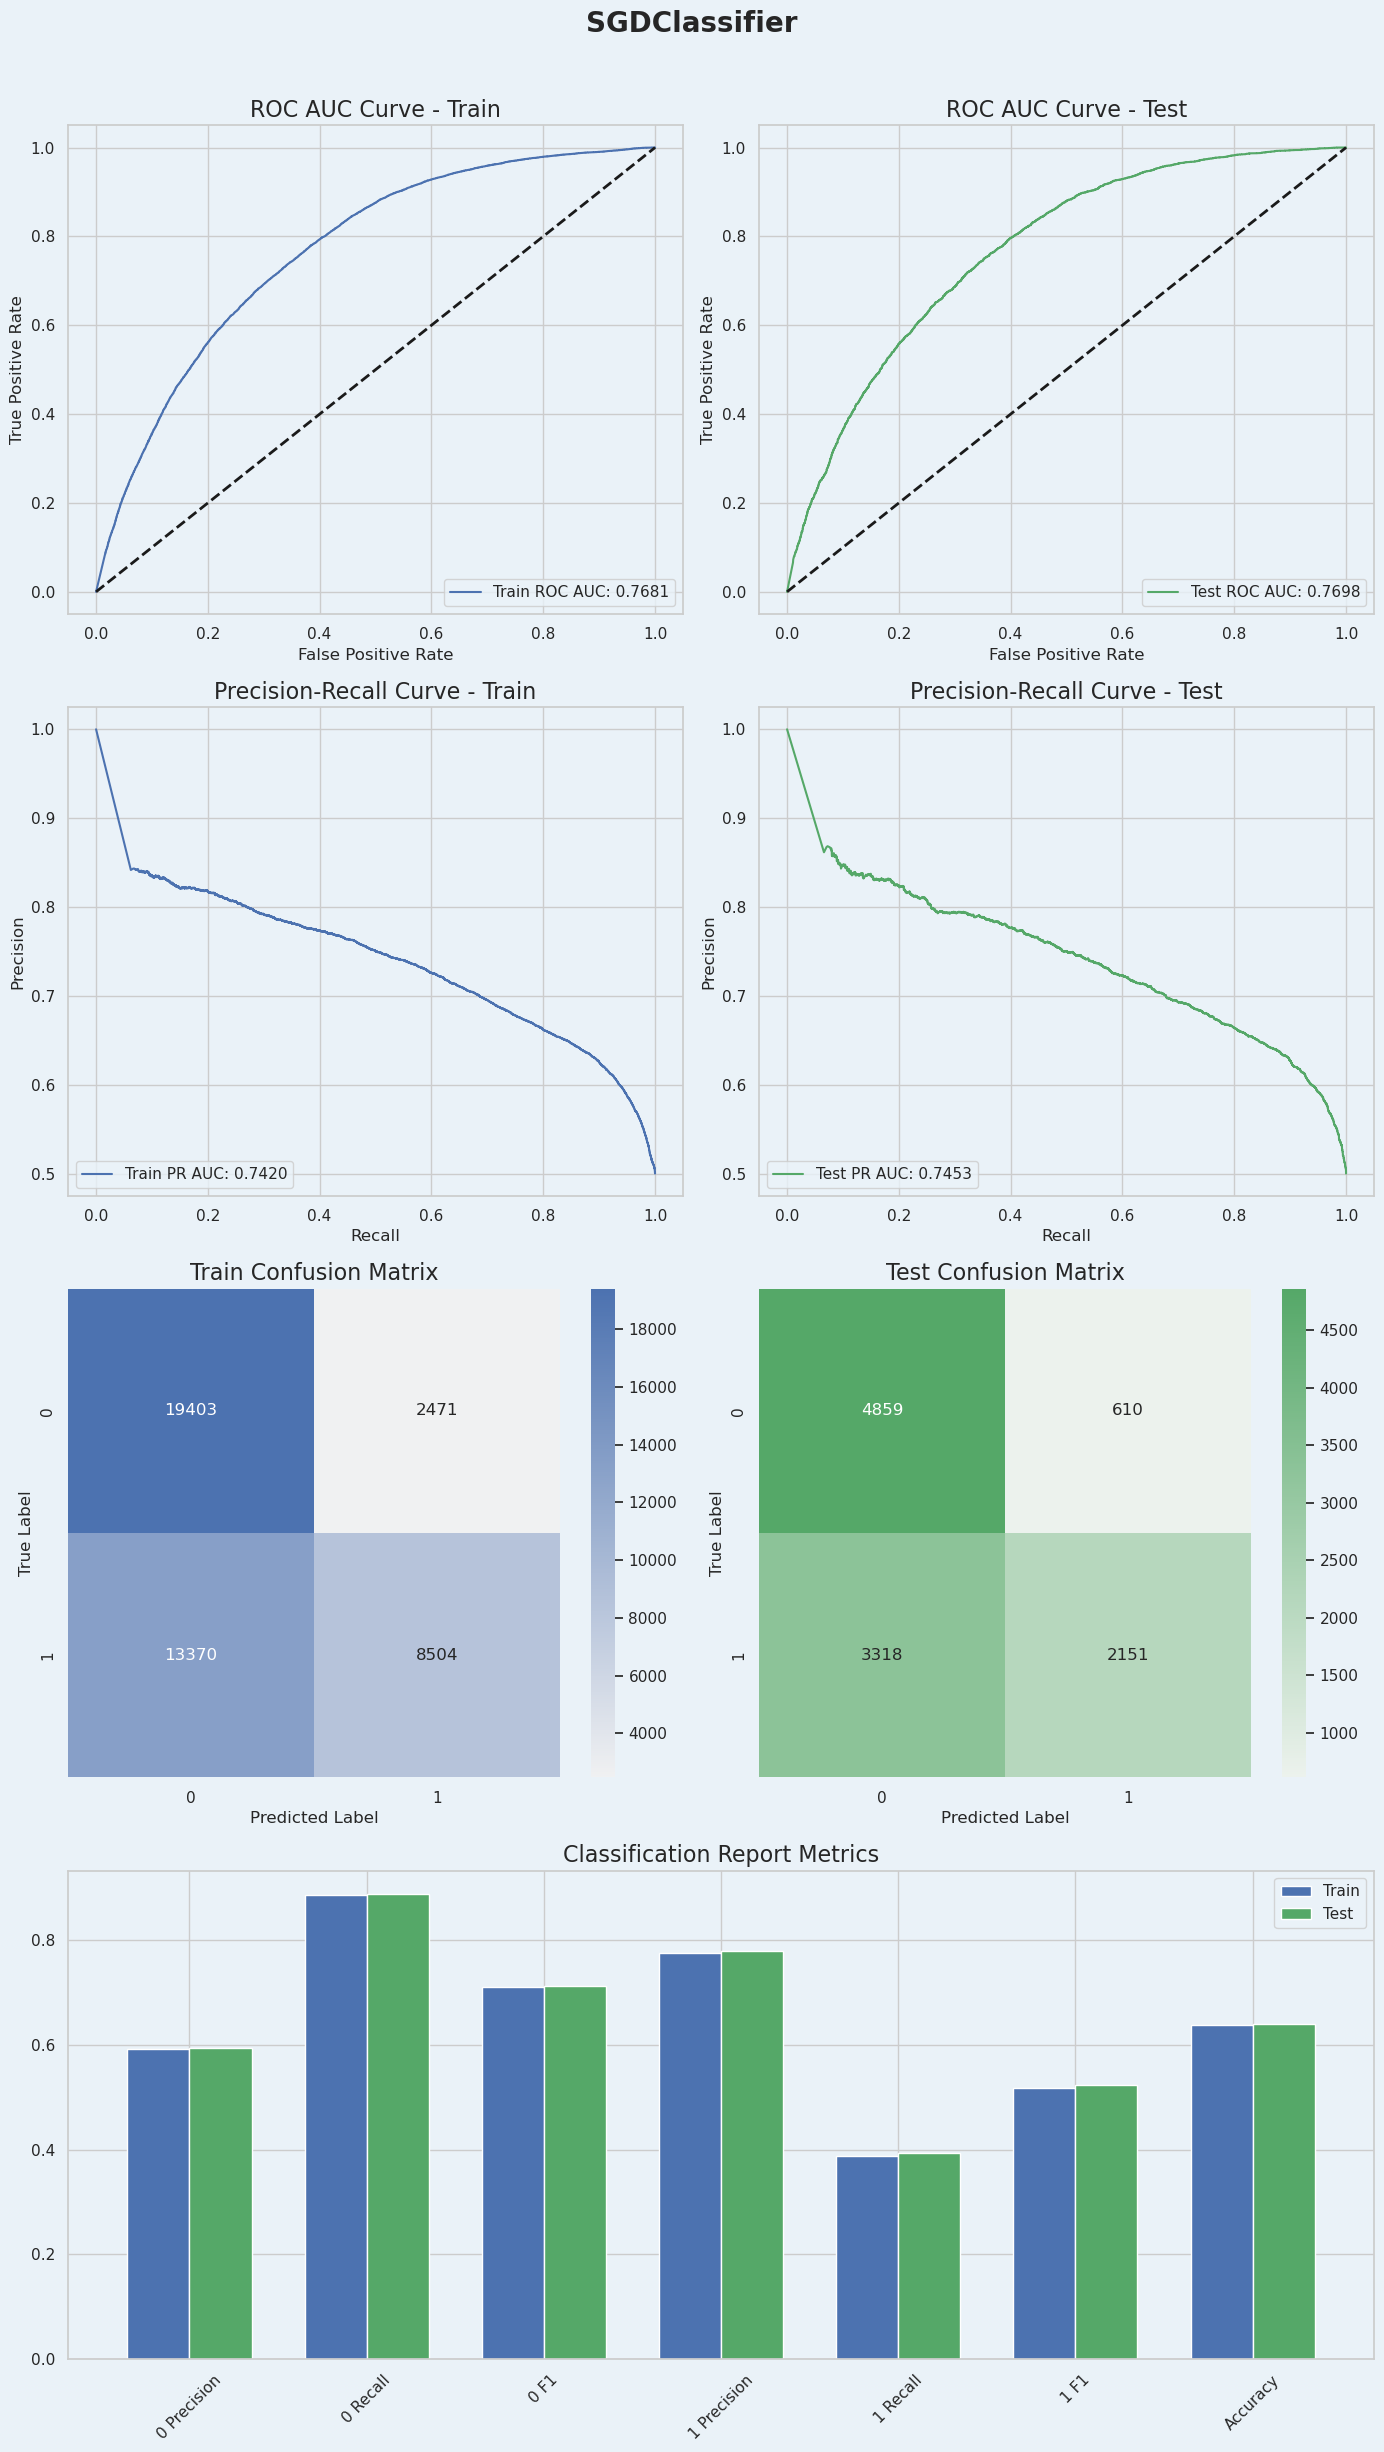

Test Classification Report:
               precision    recall  f1-score   support

Test Class 0       0.59      0.89      0.71      5469
Test Class 1       0.78      0.39      0.52      5469

    accuracy                           0.64     10938
   macro avg       0.69      0.64      0.62     10938
weighted avg       0.69      0.64      0.62     10938



In [72]:
# Evaluate the model
evaluate_model(sgd_clf, uX_train, uy_train, uX_test, uy_test, 'SGDClassifier')

## TabNet

In [73]:
run_tabnet = False
if run_tabnet:
    # Create copies of the original data frames for TabNet
    uX_train_tabnet = uX_train.copy()
    uX_test_tabnet = uX_test.copy()

    # Convert all boolean columns to integers in the copies
    uX_train_tabnet = uX_train_tabnet.astype({col: 'uint8' for col in uX_train_tabnet.select_dtypes('bool').columns})
    uX_test_tabnet = uX_test_tabnet.astype({col: 'uint8' for col in uX_test_tabnet.select_dtypes('bool').columns})

In [74]:
if run_tabnet:
    # Flatten the target arrays to make them 1-dimensional
    uy_train_tabnet = uy_train.values.ravel()
    uy_test_tabnet = uy_test.values.ravel()

    # Initialize the TabNet model
    tabnet_clf = TabNetClassifier()

    # Train the model on the training data
    tabnet_clf.fit(uX_train_tabnet.values, uy_train_tabnet, max_epochs=50, patience=5, batch_size=1024, virtual_batch_size=128)

    # Evaluate the model
    uy_test_pred = tabnet_clf.predict(uX_test_tabnet.values)
    uy_test_prob = tabnet_clf.predict_proba(uX_test_tabnet.values)[:, 1]

In [75]:
if run_tabnet:
    evaluate_model(tabnet_clf, uX_train_tabnet.values, uy_train_tabnet, uX_test_tabnet.values, uy_test_tabnet, 'TabNet')

## Stacking TabNet to CatBoost

In [76]:
run_stacked = False
if run_stacked:
    # Step 1: Train TabNet
    tabnet_clf = TabNetClassifier()
    tabnet_clf.fit(uX_train_tabnet.values, uy_train_tabnet, max_epochs=50, patience=20, batch_size=1024, virtual_batch_size=128)

    # Step 2: Generate TabNet predictions
    train_tabnet_preds = tabnet_clf.predict_proba(uX_train_tabnet.values)[:, 1]
    test_tabnet_preds = tabnet_clf.predict_proba(uX_test_tabnet.values)[:, 1]

    # Step 3: Add TabNet predictions as a new feature to the original features
    uX_train_stacked = pd.DataFrame(uX_train_tabnet)
    uX_train_stacked['TabNet_Preds'] = train_tabnet_preds

    uX_test_stacked = pd.DataFrame(uX_test_tabnet)
    uX_test_stacked['TabNet_Preds'] = test_tabnet_preds

    # Step 4: Train CatBoost on the stacked features
    catboost_clf = CatBoostClassifier(iterations=1000, depth=6, learning_rate=0.1, eval_metric='Recall', random_seed=42)
    catboost_clf.fit(uX_train_stacked, uy_train_tabnet, eval_set=(uX_test_stacked, uy_test_tabnet), verbose=100, early_stopping_rounds=100)

In [77]:
if run_stacked:
    # Step 5: Evaluate the stacked model
    evaluate_model(catboost_clf, uX_train_stacked, uy_train_tabnet, uX_test_stacked, uy_test_tabnet, 'Stacked TabNet to CatBoost')

## Evaluation Summary Visualizations

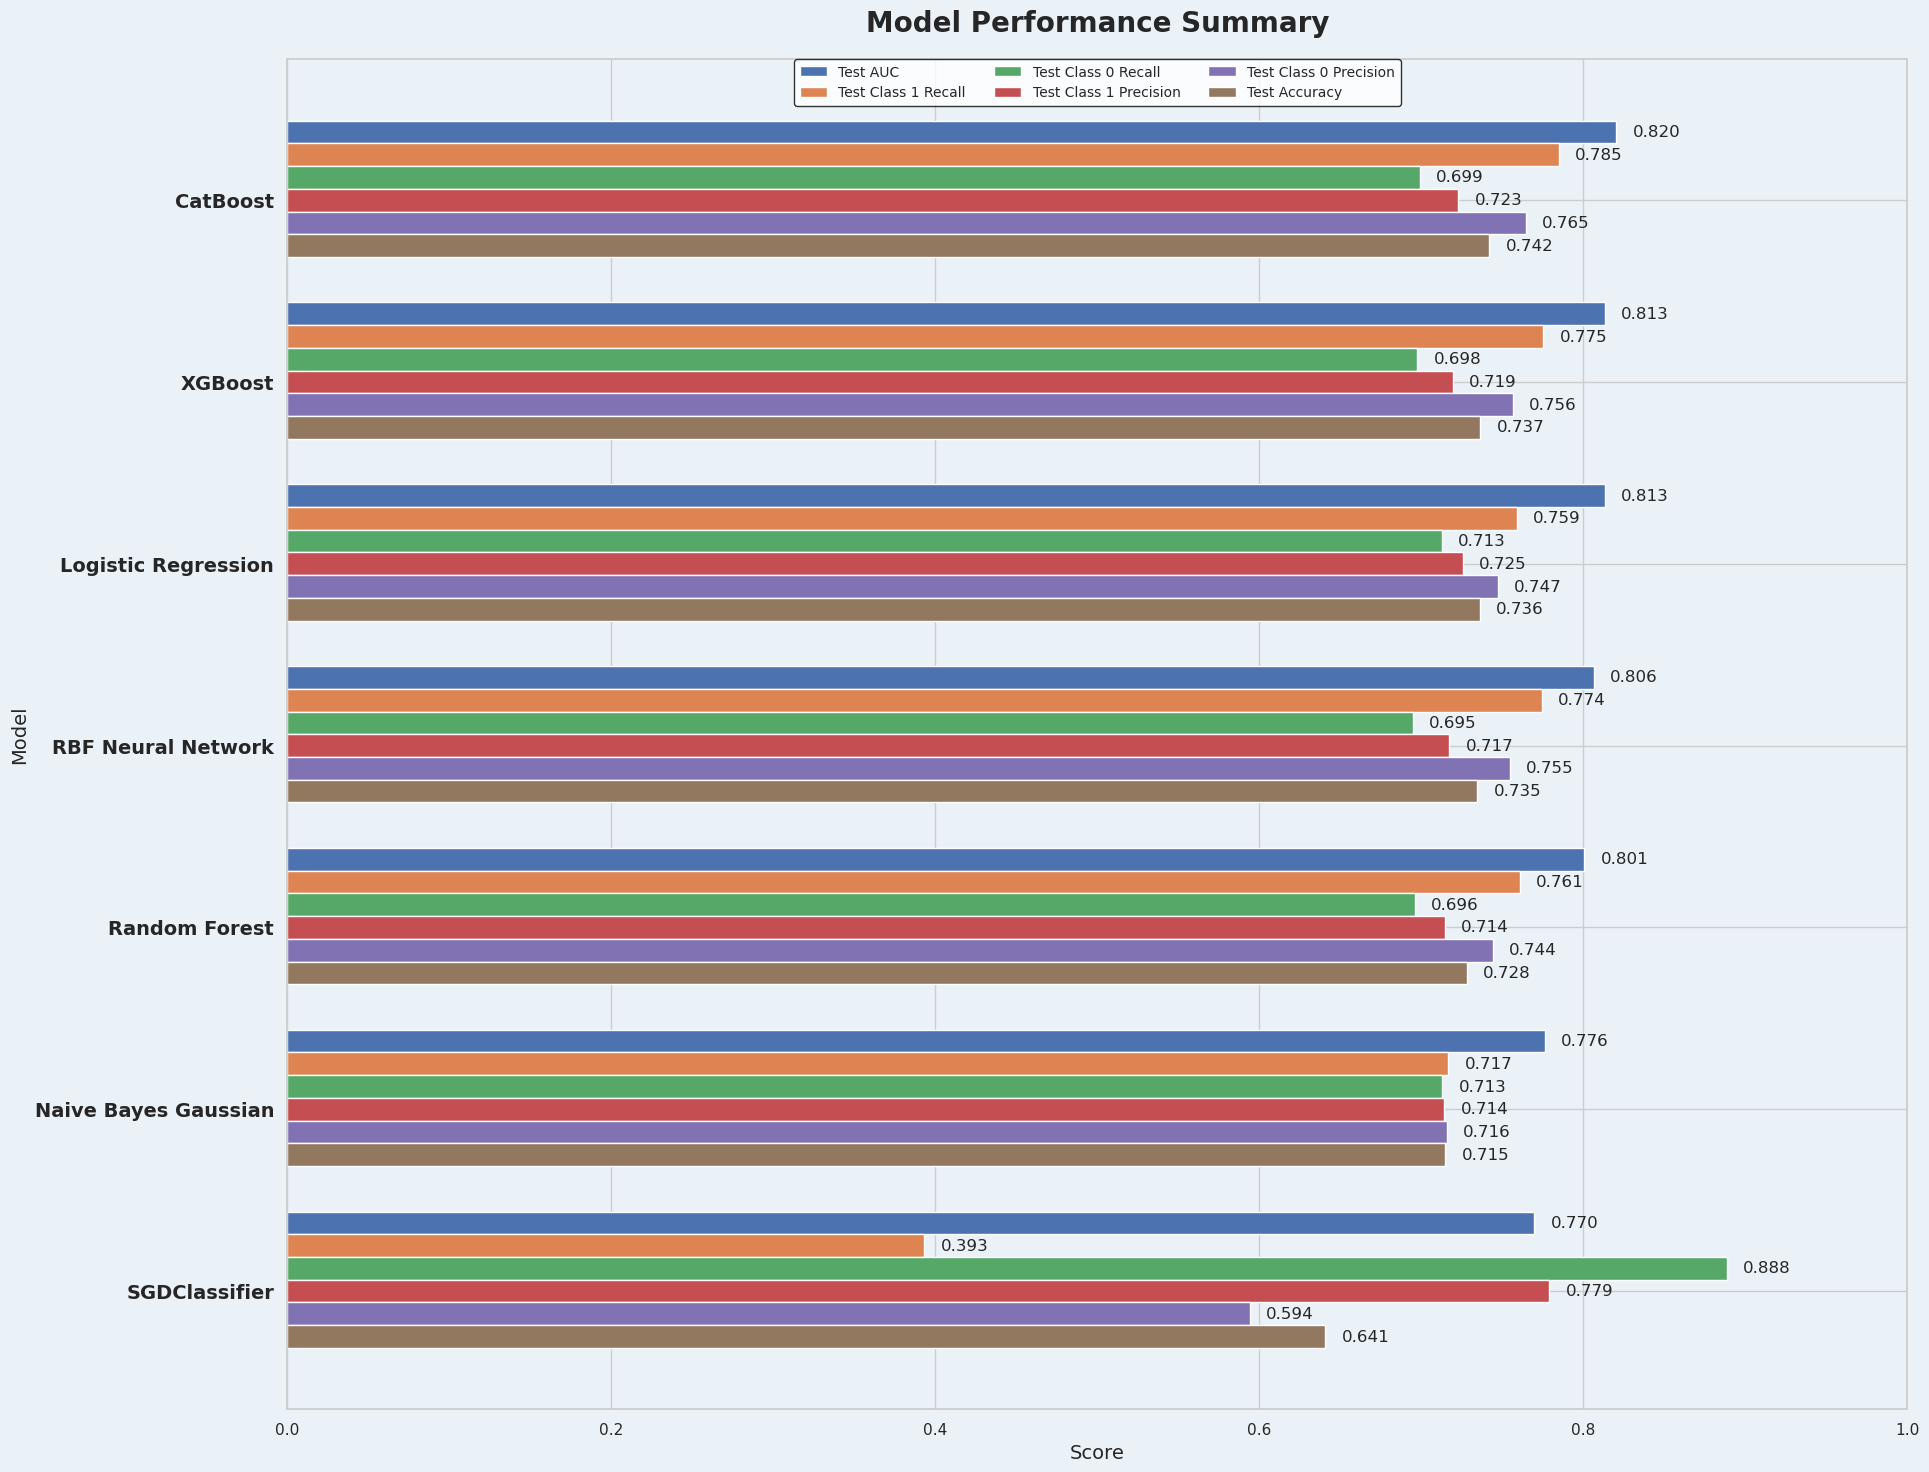

In [78]:
evaluation_summary()

# Hypertuned Models
Now that we know which models seem to fit the problem best from using a wide selection, lets pick the top 3: CatBoost, Logistic and TabNet.  Then we can try stacking them later to see if it improves things.

## Optuna Objective
I will use optuna to find the optimal params in a way GridSearchCV can't, it also usually finishes much quicker.  The only downside is sometimes it will miss things an exhaustive search doesn't.  However, Optuna can search over a wider range and find what is working and what isn't.  This makes it powerful to search over a much larger space than you could do with GridSearch in anywhere near the same time. 

Not every model is good with the optuna setup, and you can get a lot of convergence warnings.  Logistic tends to do poor with it for me, but Catboost is really easy.  I will use GridSearchCV Iteratively to find the best logistic params.

## CatBoost

### Flag

In [79]:
use_optimal_catboost = True

### Catboost Objective

In [80]:
def catboost_objective(trial):
    try:
        # Define the hyperparameter search space
        param = {
            'iterations': trial.suggest_int('iterations', 500, 2000),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
            'depth': trial.suggest_int('depth', 4, 10),
            'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-5, 10.0, log=True),
            'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),
            'border_count': trial.suggest_int('border_count', 32, 255),
            'random_strength': trial.suggest_float('random_strength', 1e-9, 10.0, log=True),
            'eval_metric': 'Recall',
            'loss_function': 'Logloss',  # Specify the loss function for cross-validation
            'task_type': "GPU",  # Ensures GPU usage
            'random_seed': 42,  # Ensures reproducibility
            'logging_level': 'Silent',  # Suppresses CatBoost output
            'early_stopping_rounds': 100  # Enable early stopping
        }

        # Create the CatBoost Pool object for training data
        train_pool = Pool(uX_train, uy_train)

        # Perform cross-validation using CatBoost's built-in function
        cv_results = cv(
            params=param,
            pool=train_pool,
            fold_count=5,  # Number of folds
            shuffle=True,  # Shuffle the dataset before splitting
            partition_random_seed=42,  # Ensures reproducibility
            stratified=True,  # For classification tasks
            verbose=False,  # Suppress output
            plot=False  # Disable plotting
        )

        # Get the mean of the cross-validated metric (in this case, recall)
        mean_recall = np.max(cv_results['test-Recall-mean'])

        return mean_recall

    except FloatingPointError:
        return float('nan')  # Return NaN to skip this trial


### Study

In [81]:
if use_optimal_catboost:
    best_params = {
        'iterations': 1935,
        'learning_rate': 0.2740784873133484,
        'depth': 10,
        'l2_leaf_reg': 8.289797674831085,
        'bagging_temperature': 0.28510805757273194,
        'border_count': 255,
        'random_strength': 0.000742088303479008,
    }
else:
    # Create an Optuna study to maximize the recall
    study = optuna.create_study(direction="maximize")
    #more than 30 gets a lot of errors
    study.optimize(catboost_objective, n_trials=30, timeout=3600)
    best_params = study.best_params

print("Best Hyperparameters: ", best_params)

Best Hyperparameters:  {'iterations': 1935, 'learning_rate': 0.2740784873133484, 'depth': 10, 'l2_leaf_reg': 8.289797674831085, 'bagging_temperature': 0.28510805757273194, 'border_count': 255, 'random_strength': 0.000742088303479008}


### Train Best

In [82]:
# Display the best hyperparameters
display(best_params)

# Note: Cross-validation has already been performed during hyperparameter tuning 
# to identify the best parameters. There's no need to perform CV again here.
# Instead, we will directly train the final model on the entire training dataset 
# using the best hyperparameters.

# Train the model on the full dataset using the best hyperparameters
best_catboost_model = CatBoostClassifier(
    **best_params,  # Unpack the best hyperparameters
    eval_metric='Recall',  # Evaluation metric
    loss_function='Logloss',  # Specify the loss function for cross-validation
    task_type="GPU",  # Ensures GPU usage
    random_seed=42,  # Ensures reproducibility
    logging_level='Silent',  # Suppresses CatBoost output
    early_stopping_rounds=100  # Enable early stopping
)

# Fit the model on the full training data
best_catboost_model.fit(uX_train, uy_train, eval_set=(uX_test, uy_test), verbose=100, early_stopping_rounds=100)


{'iterations': 1935,
 'learning_rate': 0.2740784873133484,
 'depth': 10,
 'l2_leaf_reg': 8.289797674831085,
 'bagging_temperature': 0.28510805757273194,
 'border_count': 255,
 'random_strength': 0.000742088303479008}

### Evaluate

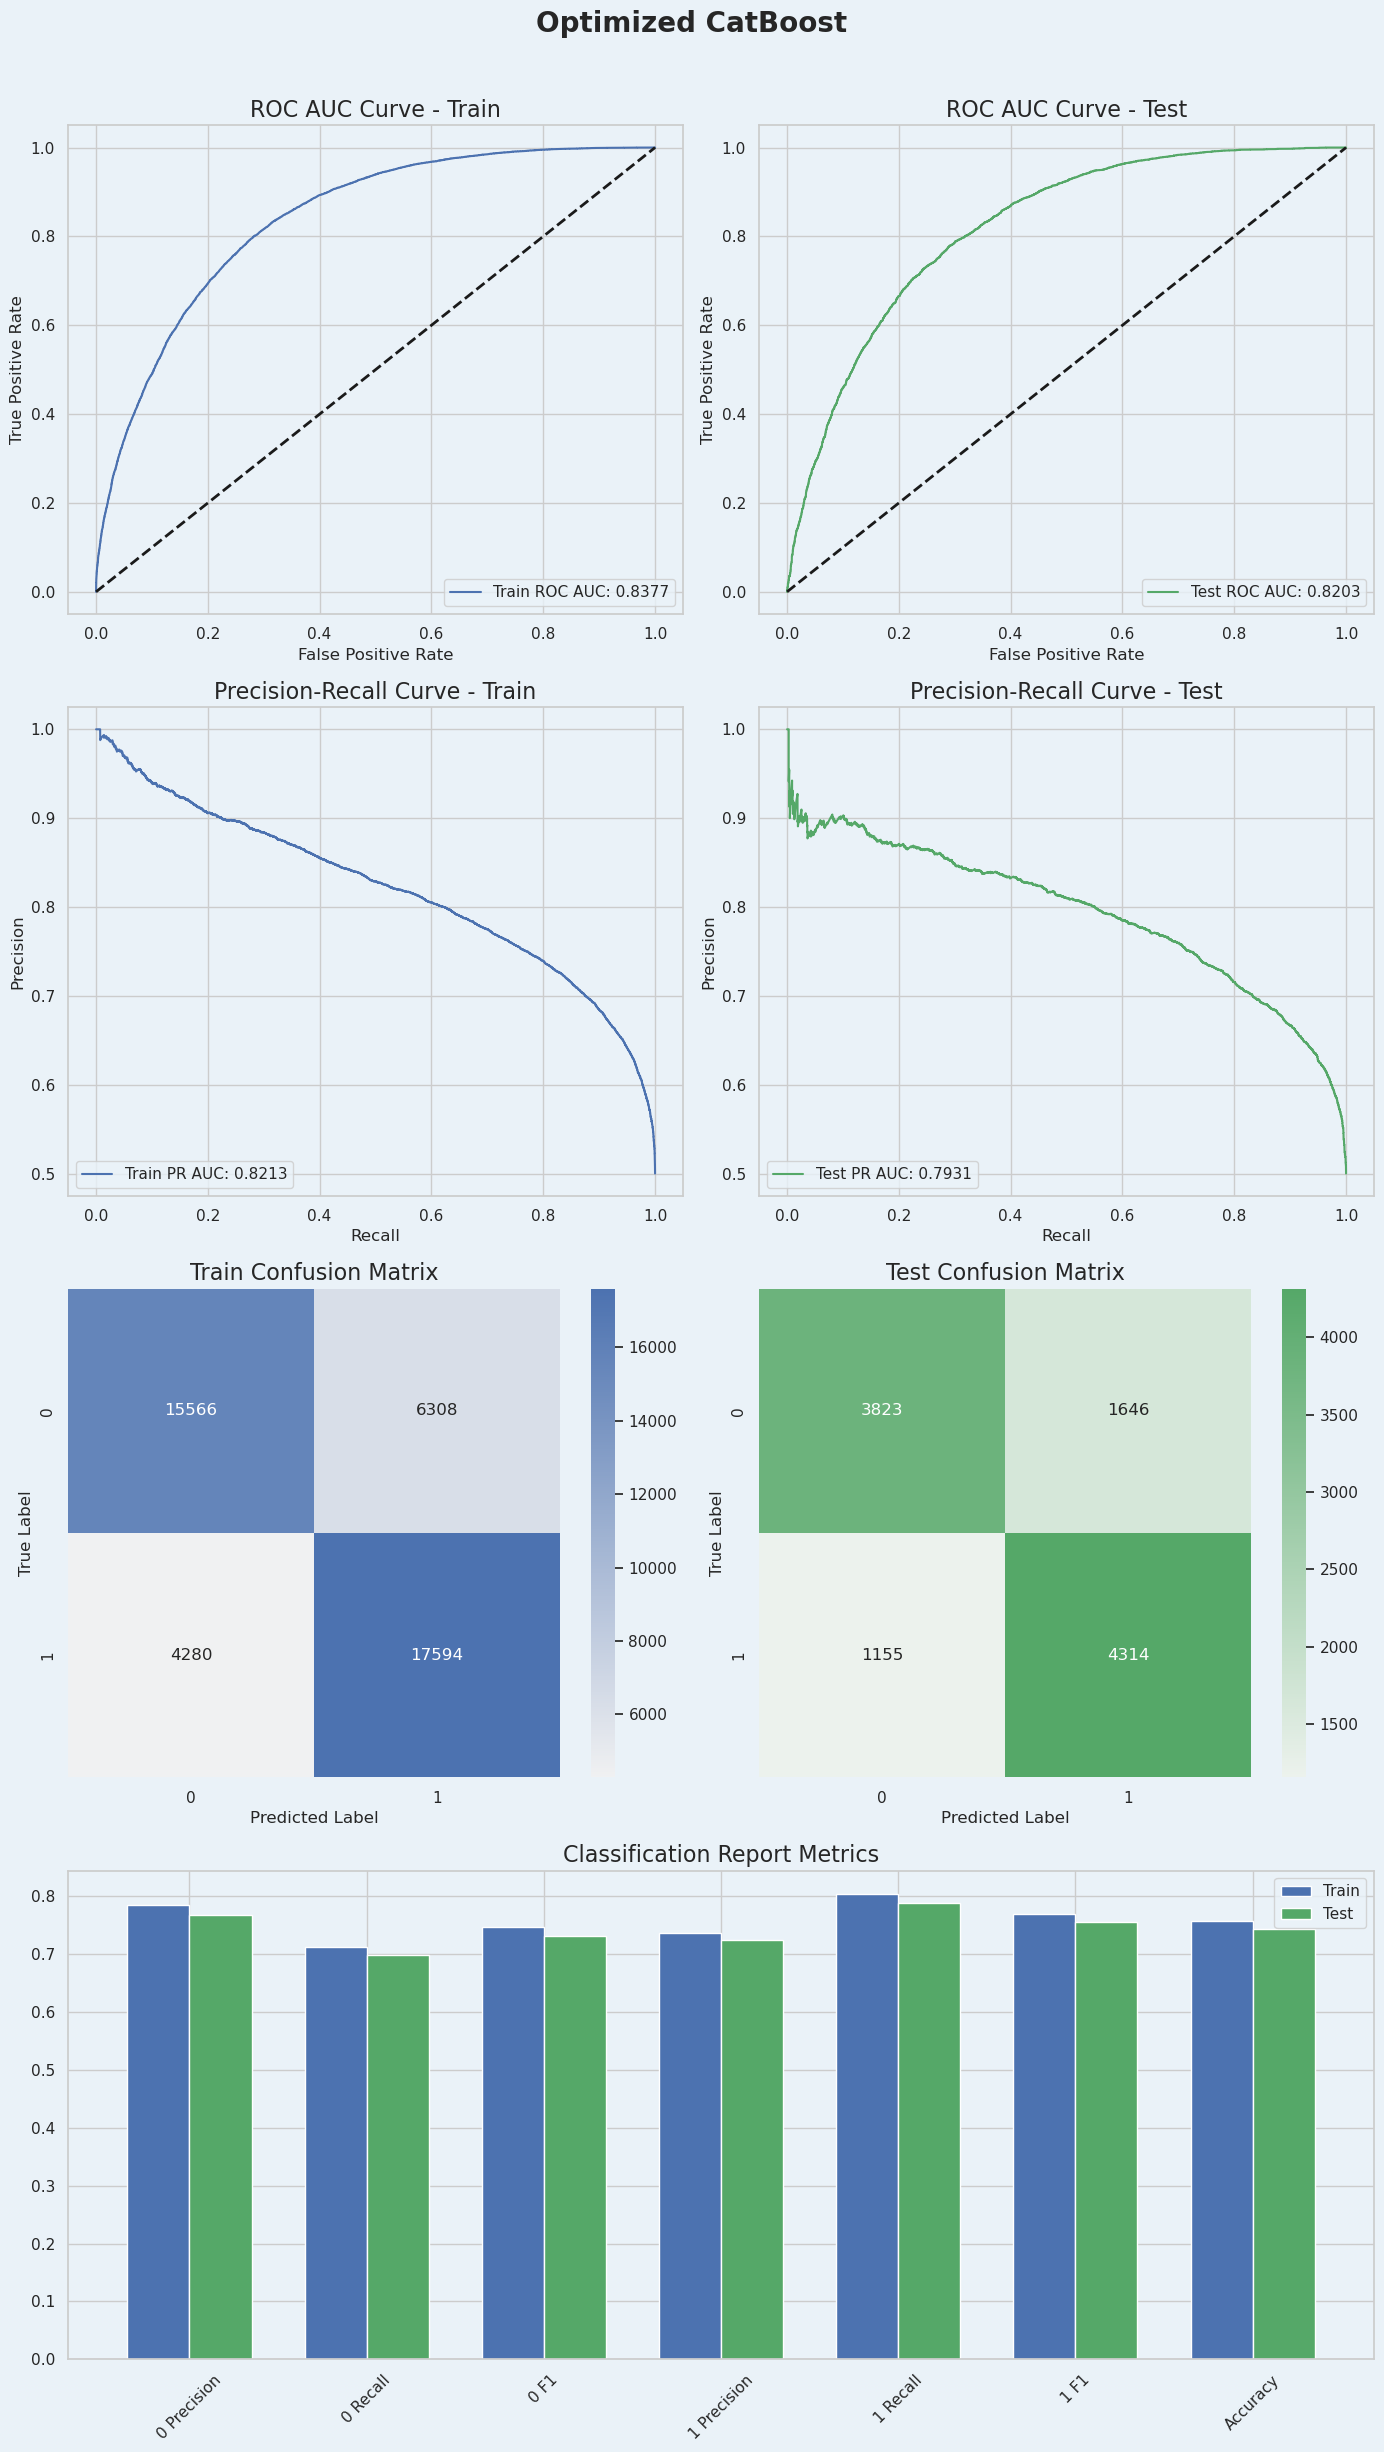

Test Classification Report:
               precision    recall  f1-score   support

Test Class 0       0.77      0.70      0.73      5469
Test Class 1       0.72      0.79      0.75      5469

    accuracy                           0.74     10938
   macro avg       0.75      0.74      0.74     10938
weighted avg       0.75      0.74      0.74     10938



In [83]:
evaluate_model(best_catboost_model, uX_train, uy_train, uX_test, uy_test, 'Optimized CatBoost')

## CatBoost Full Data

### Flag

In [84]:
fd_use_optimal_catboost = True

### Catboost Objective

In [85]:
def fd_catboost_objective(trial):
    try:
        # Define the hyperparameter search space
        param = {
            'iterations': trial.suggest_int('iterations', 500, 2000),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
            'depth': trial.suggest_int('depth', 4, 10),
            'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-5, 10.0, log=True),
            'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),
            'border_count': trial.suggest_int('border_count', 32, 255),
            'random_strength': trial.suggest_float('random_strength', 1e-9, 10.0, log=True),
            #'rsm': trial.suggest_float('rsm', 0.5, 1.0),  # Subspace of features used per iteration
            'bootstrap_type': trial.suggest_categorical('bootstrap_type', ['Poisson']),
            'subsample': trial.suggest_float('subsample', 0.5, 1.0),  # Fraction of samples per iteration
            'eval_metric': 'Recall',
            'loss_function': 'Logloss',
            'task_type': "GPU",  # Ensures GPU usage
            'random_seed': 42,  # Ensures reproducibility
            'logging_level': 'Silent',  # Suppresses CatBoost output
            'early_stopping_rounds': 100,  # Enable early stopping
        }

        # Add auto_class_weights only if it's set to 'Balanced'
        auto_class_weights = trial.suggest_categorical('auto_class_weights', ['Balanced', None])
        if auto_class_weights == 'Balanced':
            param['auto_class_weights'] = 'Balanced'

        # Create the CatBoost Pool object for training data
        train_pool = Pool(X_train, y_train)

        # Perform cross-validation using CatBoost's built-in function
        cv_results = cv(
            params=param,
            pool=train_pool,
            fold_count=5,  # Number of folds
            shuffle=True,  # Shuffle the dataset before splitting
            partition_random_seed=42,  # Ensures reproducibility
            stratified=True,  # For classification tasks
            verbose=False,  # Suppress output
            plot=False  # Disable plotting
        )

        # Get the mean of the cross-validated metric (in this case, recall)
        mean_recall = np.max(cv_results['test-Recall-mean'])

        return mean_recall

    except FloatingPointError:
        return float('nan')  # Return NaN to skip this trial

### Study

In [86]:
if fd_use_optimal_catboost:
    best_params = {
        'iterations': 914,
        'learning_rate': 0.11310969482354828,
        'depth': 8,
        'l2_leaf_reg': 0.00041526042731307124,
        'bagging_temperature': 0.4642445134068348,
        'border_count': 38,
        'random_strength': 5.115620711662322e-06,
        'bootstrap_type': 'Poisson',
        'subsample': 0.7101374035846627,
        'auto_class_weights': 'Balanced'
    }
else:
    # Create an Optuna study to maximize the recall
    study = optuna.create_study(direction="maximize")
    #more than 30 gets a lot of errors
    study.optimize(fd_catboost_objective, n_trials=30, timeout=3600)
    best_params = study.best_params

#best_params['class_weights'] = [1, 7]  # Ensuring class weights are set

print("Best Hyperparameters: ", best_params)

Best Hyperparameters:  {'iterations': 914, 'learning_rate': 0.11310969482354828, 'depth': 8, 'l2_leaf_reg': 0.00041526042731307124, 'bagging_temperature': 0.4642445134068348, 'border_count': 38, 'random_strength': 5.115620711662322e-06, 'bootstrap_type': 'Poisson', 'subsample': 0.7101374035846627, 'auto_class_weights': 'Balanced'}


Best Hyperparameters:  {'iterations': 1064, 'learning_rate': 0.10344611610889885, 'depth': 8, 'l2_leaf_reg': 0.0001197519376912362, 'bagging_temperature': 0.16339847168224553, 'border_count': 57, 'random_strength': 0.000344476516786255, 'class_weights': [1, 7]}


Best Hyperparameters:  {'iterations': 914, 'learning_rate': 0.11310969482354828, 'depth': 8, 'l2_leaf_reg': 0.00041526042731307124, 'bagging_temperature': 0.4642445134068348, 'border_count': 38, 'random_strength': 5.115620711662322e-06, 'bootstrap_type': 'Poisson', 'subsample': 0.7101374035846627, 'auto_class_weights': 'Balanced'}

### Train Best

In [87]:
# Train the model on the full dataset using the best hyperparameters
fd_best_catboost_model = CatBoostClassifier(
    **best_params,  # Unpack the best hyperparameters
    eval_metric='Recall:use_weights=True',  # Evaluation metric
    task_type="GPU",  # Ensures GPU usage
    random_seed=42,  # Ensures reproducibility
    logging_level='Silent',  # Suppresses CatBoost output
    early_stopping_rounds=100  # Enable early stopping
)

# Fit the model on the full training data
fd_best_catboost_model.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=100, early_stopping_rounds=100)


### Evaluate

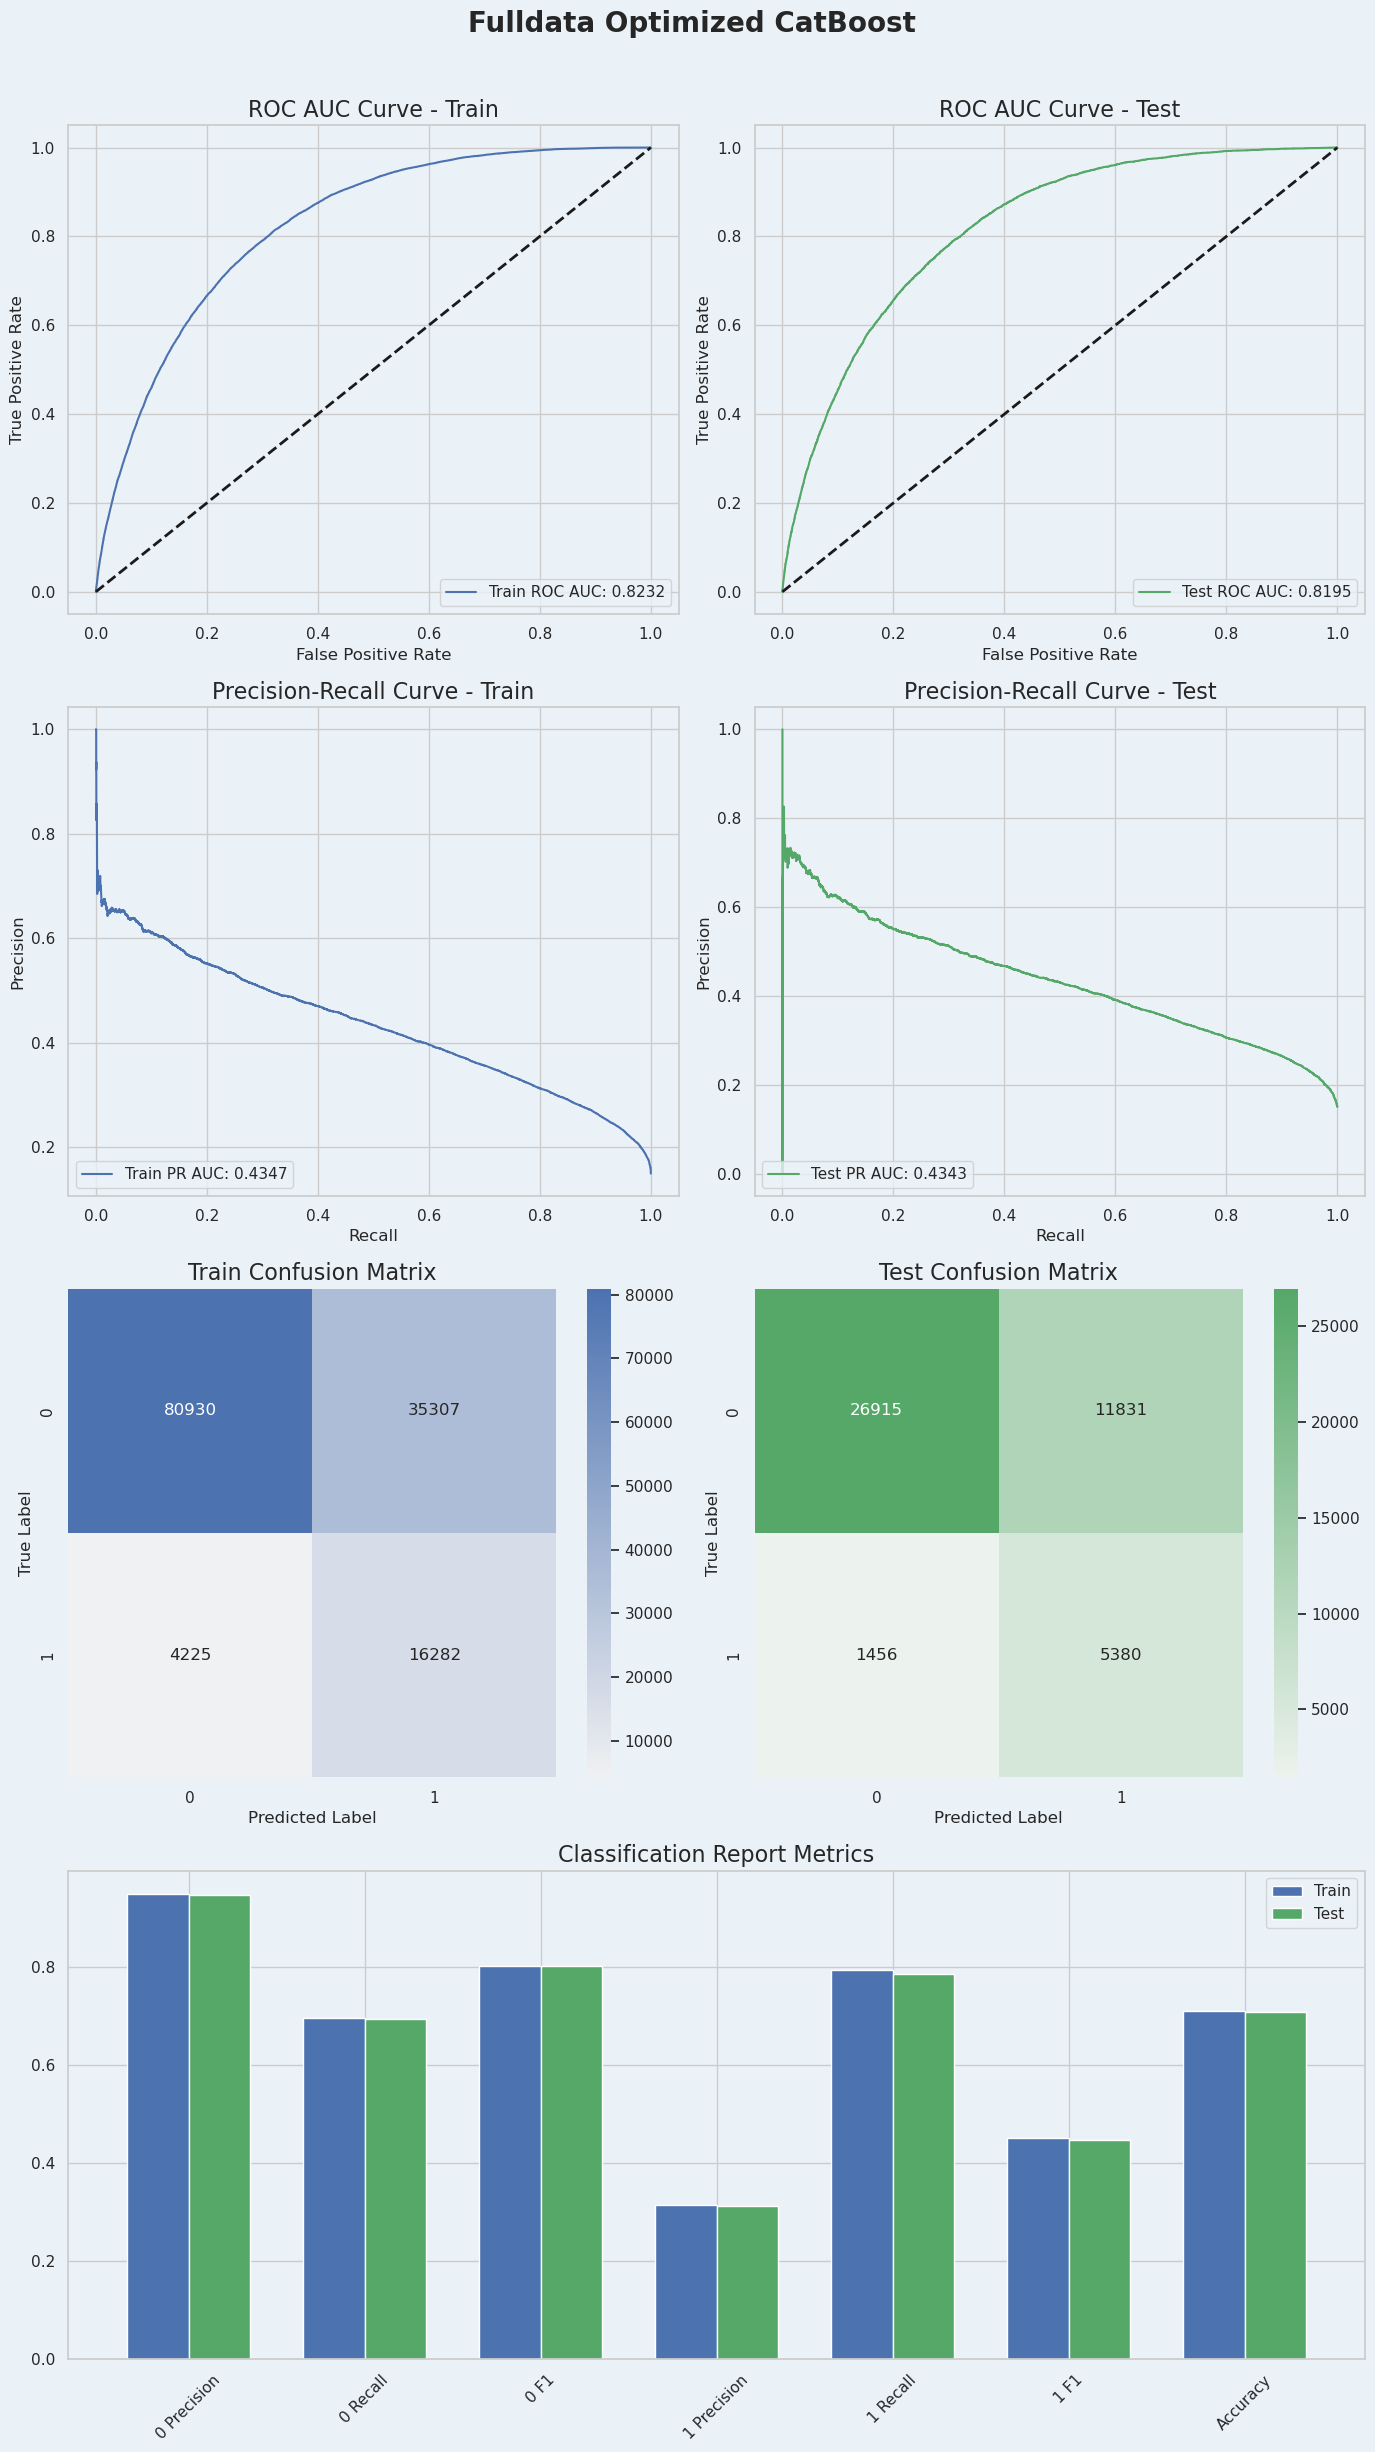

Test Classification Report:
               precision    recall  f1-score   support

Test Class 0       0.95      0.69      0.80     38746
Test Class 1       0.31      0.79      0.45      6836

    accuracy                           0.71     45582
   macro avg       0.63      0.74      0.62     45582
weighted avg       0.85      0.71      0.75     45582



In [88]:
evaluate_model(fd_best_catboost_model, X_train, y_train, X_test, y_test, 'Fulldata Optimized CatBoost')

## Logistic Tuned

In [151]:
log_use_optimal_params = True
if log_use_optimal_params:
    # Iterated down to these values after many grid searches
    param_grid = {
        'scaler': [StandardScaler()],  # Fixed to the best scaler found
        'model__penalty': ['elasticnet'],  # Fixed to the best penalty found
        'model__C': [0.01],  # Fixed to the best C value found
        'model__l1_ratio': [0.1],  # Fixed to the best l1_ratio found
        'model__max_iter': [100]  # Fixed to the best max_iter found
    }

else: 
    # Full Search, over 15 mins to run  
    param_grid = [
        {
            'scaler': [None, StandardScaler(), MinMaxScaler(), RobustScaler()],
            'model__penalty': ['none'],
            'model__C': [1],  # C is irrelevant when penalty is 'none', but must be set
            'model__max_iter': [100, 500,1000]
        },
        {
            'scaler': [None, StandardScaler(), MinMaxScaler(), RobustScaler()],
            'model__penalty': ['l1', 'l2'],
            'model__C': [0.01, 0.1, 1, 10, 100],
            'model__max_iter': [100, 500, 1000]
        },
        {
            'scaler': [None, StandardScaler(), MinMaxScaler(), RobustScaler()],
            'model__penalty': ['elasticnet'],
            'model__C': [0.01, 0.1, 1, 10, 100],
            'model__max_iter': [100, 500, 1000],
            'model__l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]
        }
    ]

# Create a pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Placeholder for scaler
    ('model', LogisticRegression(solver='saga', random_state=42))  # Use saga to handle elasticnet
])

# Initialize the grid search
grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, scoring='roc_auc', error_score=np.nan)

# Fit the grid search
grid_search.fit(uX_train, uy_train.values.ravel())  # Ensuring uy_train is flattened correctly

# Best parameters and score
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Score:", grid_search.best_score_)

# Evaluate on the test set
tuned_logistic_model = grid_search.best_estimator_
test_score = tuned_logistic_model.score(uX_test, uy_test.values.ravel())
print("Test Set Score:", test_score)

Best Parameters: {'model__C': 0.01, 'model__l1_ratio': 0.1, 'model__max_iter': 100, 'model__penalty': 'elasticnet', 'scaler': StandardScaler()}
Best Cross-Validation Score: 0.8102909402888685
Test Set Score: 0.7350521119034559


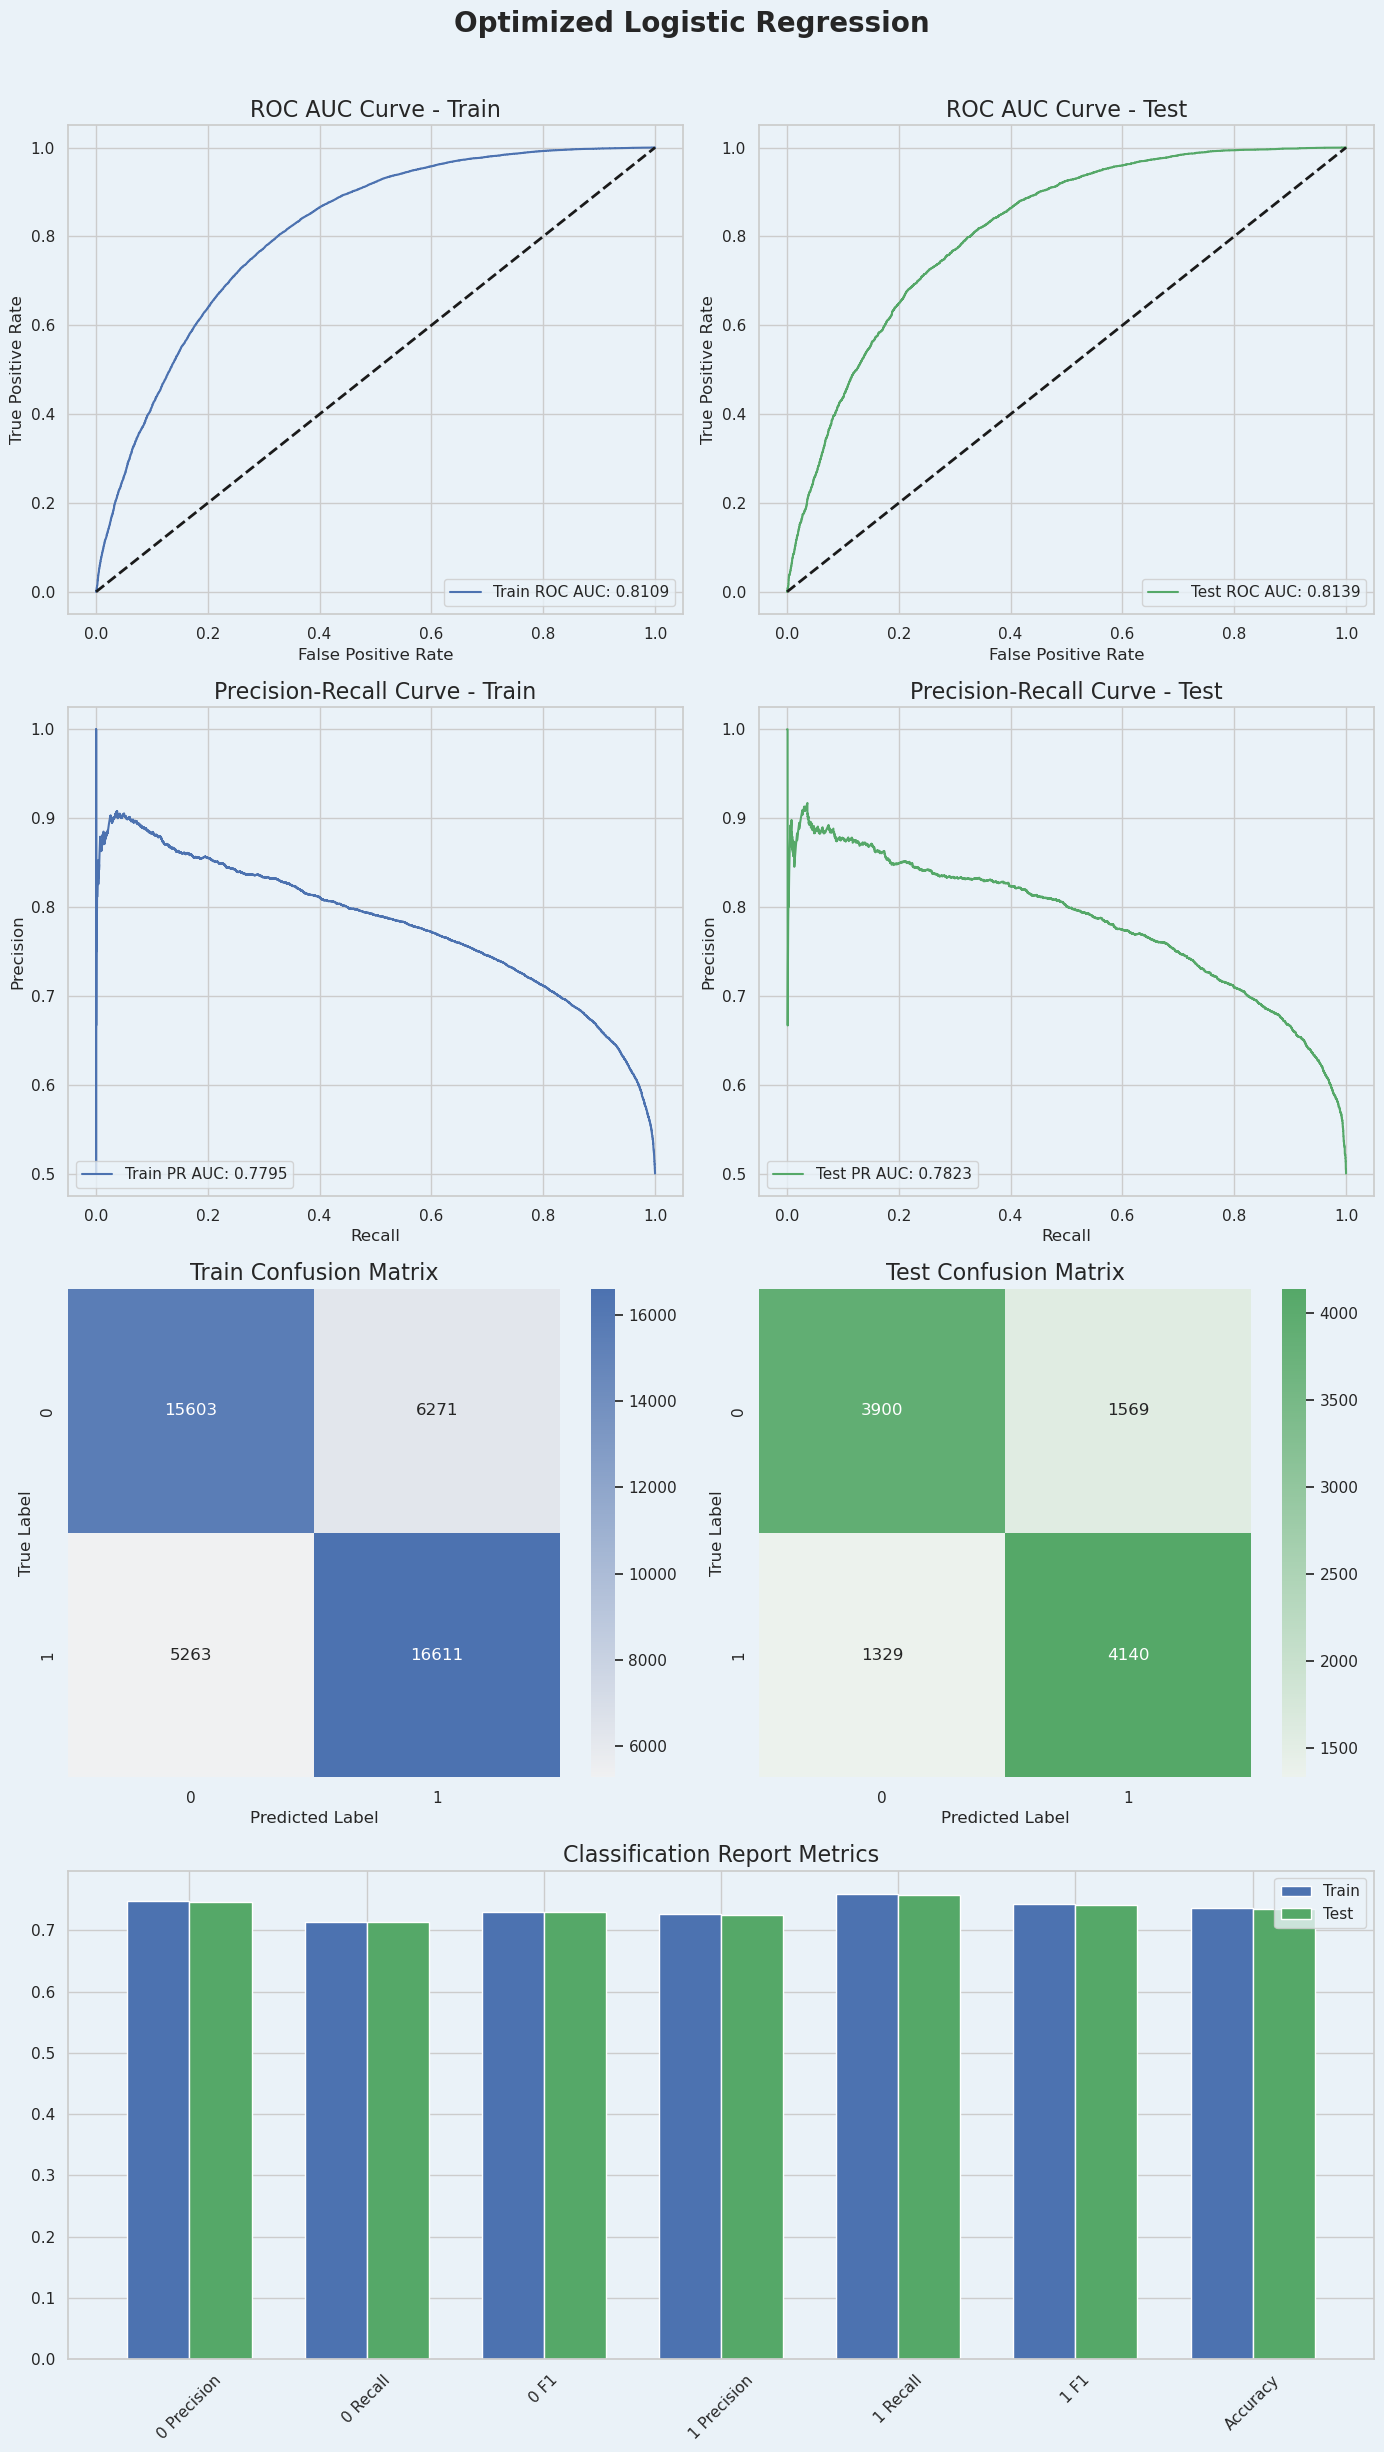

Test Classification Report:
               precision    recall  f1-score   support

Test Class 0       0.75      0.71      0.73      5469
Test Class 1       0.73      0.76      0.74      5469

    accuracy                           0.74     10938
   macro avg       0.74      0.74      0.73     10938
weighted avg       0.74      0.74      0.73     10938



In [152]:
# Evaluate the model using your evaluate_model function
evaluate_model(tuned_logistic_model, uX_train, uy_train, uX_test, uy_test, 'Optimized Logistic Regression')

## TabNet Tuned

### TabNet Format

In [91]:
use_best_params_tabnet = True
# Prepare the data for TabNet
uX_train_tabnet = uX_train.copy()
uX_test_tabnet = uX_test.copy()

# Convert all boolean columns to integers in the copies
uX_train_tabnet = uX_train_tabnet.astype({col: 'uint8' for col in uX_train_tabnet.select_dtypes('bool').columns})
uX_test_tabnet = uX_test_tabnet.astype({col: 'uint8' for col in uX_test_tabnet.select_dtypes('bool').columns})

# Flatten the target arrays to make them 1-dimensional
uy_train_tabnet = uy_train.values.ravel()
uy_test_tabnet = uy_test.values.ravel()

### TabNet Objective

In [92]:
def tabnet_objective(trial):
    try:
        # Suggest hyperparameters for TabNet
        n_d = trial.suggest_int('n_d', 8, 64)
        n_a = trial.suggest_int('n_a', 8, 64)
        n_steps = trial.suggest_int('n_steps', 3, 10)
        gamma = trial.suggest_float('gamma', 1.0, 2.0)
        lambda_sparse = trial.suggest_float('lambda_sparse', 1e-6, 1e-3)
        momentum = trial.suggest_float('momentum', 0.01, 0.4)
        learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-1, log=True)
        
        tabnet_clf = TabNetClassifier(
            n_d=n_d,
            n_a=n_a,
            n_steps=n_steps,
            gamma=gamma,
            lambda_sparse=lambda_sparse,
            momentum=momentum,
            optimizer_params=dict(lr=learning_rate),  # Use the suggested learning rate
            seed=42
        )

        # Train the model with early stopping
        tabnet_clf.fit(
            uX_train_tabnet.values, uy_train_tabnet,
            eval_set=[(uX_test_tabnet.values, uy_test_tabnet)],
            eval_name=['val'],
            eval_metric=['auc'],
            max_epochs=200, patience=20,
            batch_size=1024, virtual_batch_size=128,
            num_workers=0,
            drop_last=False
        )

        # Predict on the test set
        uy_test_prob = tabnet_clf.predict_proba(uX_test_tabnet.values)[:, 1]

        # Calculate and return the evaluation metric
        score = roc_auc_score(uy_test_tabnet, uy_test_prob)
        return score

    except Exception as e:
        # Handle any exceptions that occur during the training or evaluation
        print(f"An error occurred: {e}")
        return float('nan')  # Return NaN to indicate the trial failed

### Study

In [93]:
if not use_best_params_tabnet:
    # Create an Optuna study and optimize
    study = optuna.create_study(direction='maximize')
    study.optimize(tabnet_objective, n_trials=50)

    # Best parameters and score
    print("Best Parameters:", study.best_params)
    print("Best ROC AUC Score:", study.best_value)

### Train Best

In [94]:
if use_best_params_tabnet:
    best_params = {
        "n_d": 51,
        "n_a": 12,
        "n_steps": 3,
        "gamma": 1.4199324179569643,
        "lambda_sparse": 0.00037071990661158055,
        "momentum": 0.14269955580864002,
        "learning_rate": 0.02  # Default learning rate, adjust as needed
    }
else:
    best_params = study.best_params

# Provide default values for n_independent and n_shared if not found
n_independent = best_params.get('n_independent', 2)  # Default to 2 if not found
n_shared = best_params.get('n_shared', 2)  # Default to 2 if not found

# Initialize the TabNet model with the best hyperparameters
best_tabnet_clf = TabNetClassifier(
    n_d=best_params['n_d'],
    n_a=best_params['n_a'],
    n_steps=best_params['n_steps'],
    gamma=best_params['gamma'],
    lambda_sparse=best_params['lambda_sparse'],
    optimizer_params=dict(lr=best_params['learning_rate']),
    n_independent=n_independent,
    n_shared=n_shared,
    seed=42
)

# Train the model on the entire training data
best_tabnet_clf.fit(
    uX_train_tabnet.values, uy_train_tabnet,
    max_epochs=50, patience=20,
    batch_size=1024, virtual_batch_size=128
)

/home/atrix/anaconda3/envs/pytorch-env/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/home/atrix/anaconda3/envs/pytorch-env/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.6442  |  0:00:01s
epoch 1  | loss: 0.56776 |  0:00:01s
epoch 2  | loss: 0.55103 |  0:00:02s
epoch 3  | loss: 0.54403 |  0:00:03s
epoch 4  | loss: 0.54266 |  0:00:04s
epoch 5  | loss: 0.53644 |  0:00:04s
epoch 6  | loss: 0.53479 |  0:00:05s
epoch 7  | loss: 0.5338  |  0:00:06s
epoch 8  | loss: 0.5296  |  0:00:07s
epoch 9  | loss: 0.52869 |  0:00:07s
epoch 10 | loss: 0.5271  |  0:00:08s
epoch 11 | loss: 0.52513 |  0:00:09s
epoch 12 | loss: 0.52652 |  0:00:10s
epoch 13 | loss: 0.52494 |  0:00:10s
epoch 14 | loss: 0.52395 |  0:00:11s
epoch 15 | loss: 0.52394 |  0:00:12s
epoch 16 | loss: 0.52153 |  0:00:13s
epoch 17 | loss: 0.52201 |  0:00:13s
epoch 18 | loss: 0.52254 |  0:00:14s
epoch 19 | loss: 0.52117 |  0:00:15s
epoch 20 | loss: 0.52084 |  0:00:16s
epoch 21 | loss: 0.52029 |  0:00:16s
epoch 22 | loss: 0.51882 |  0:00:17s
epoch 23 | loss: 0.52004 |  0:00:18s
epoch 24 | loss: 0.51795 |  0:00:18s
epoch 25 | loss: 0.51803 |  0:00:19s
epoch 26 | loss: 0.52037 |  0:00:20s
e

### Evaluate

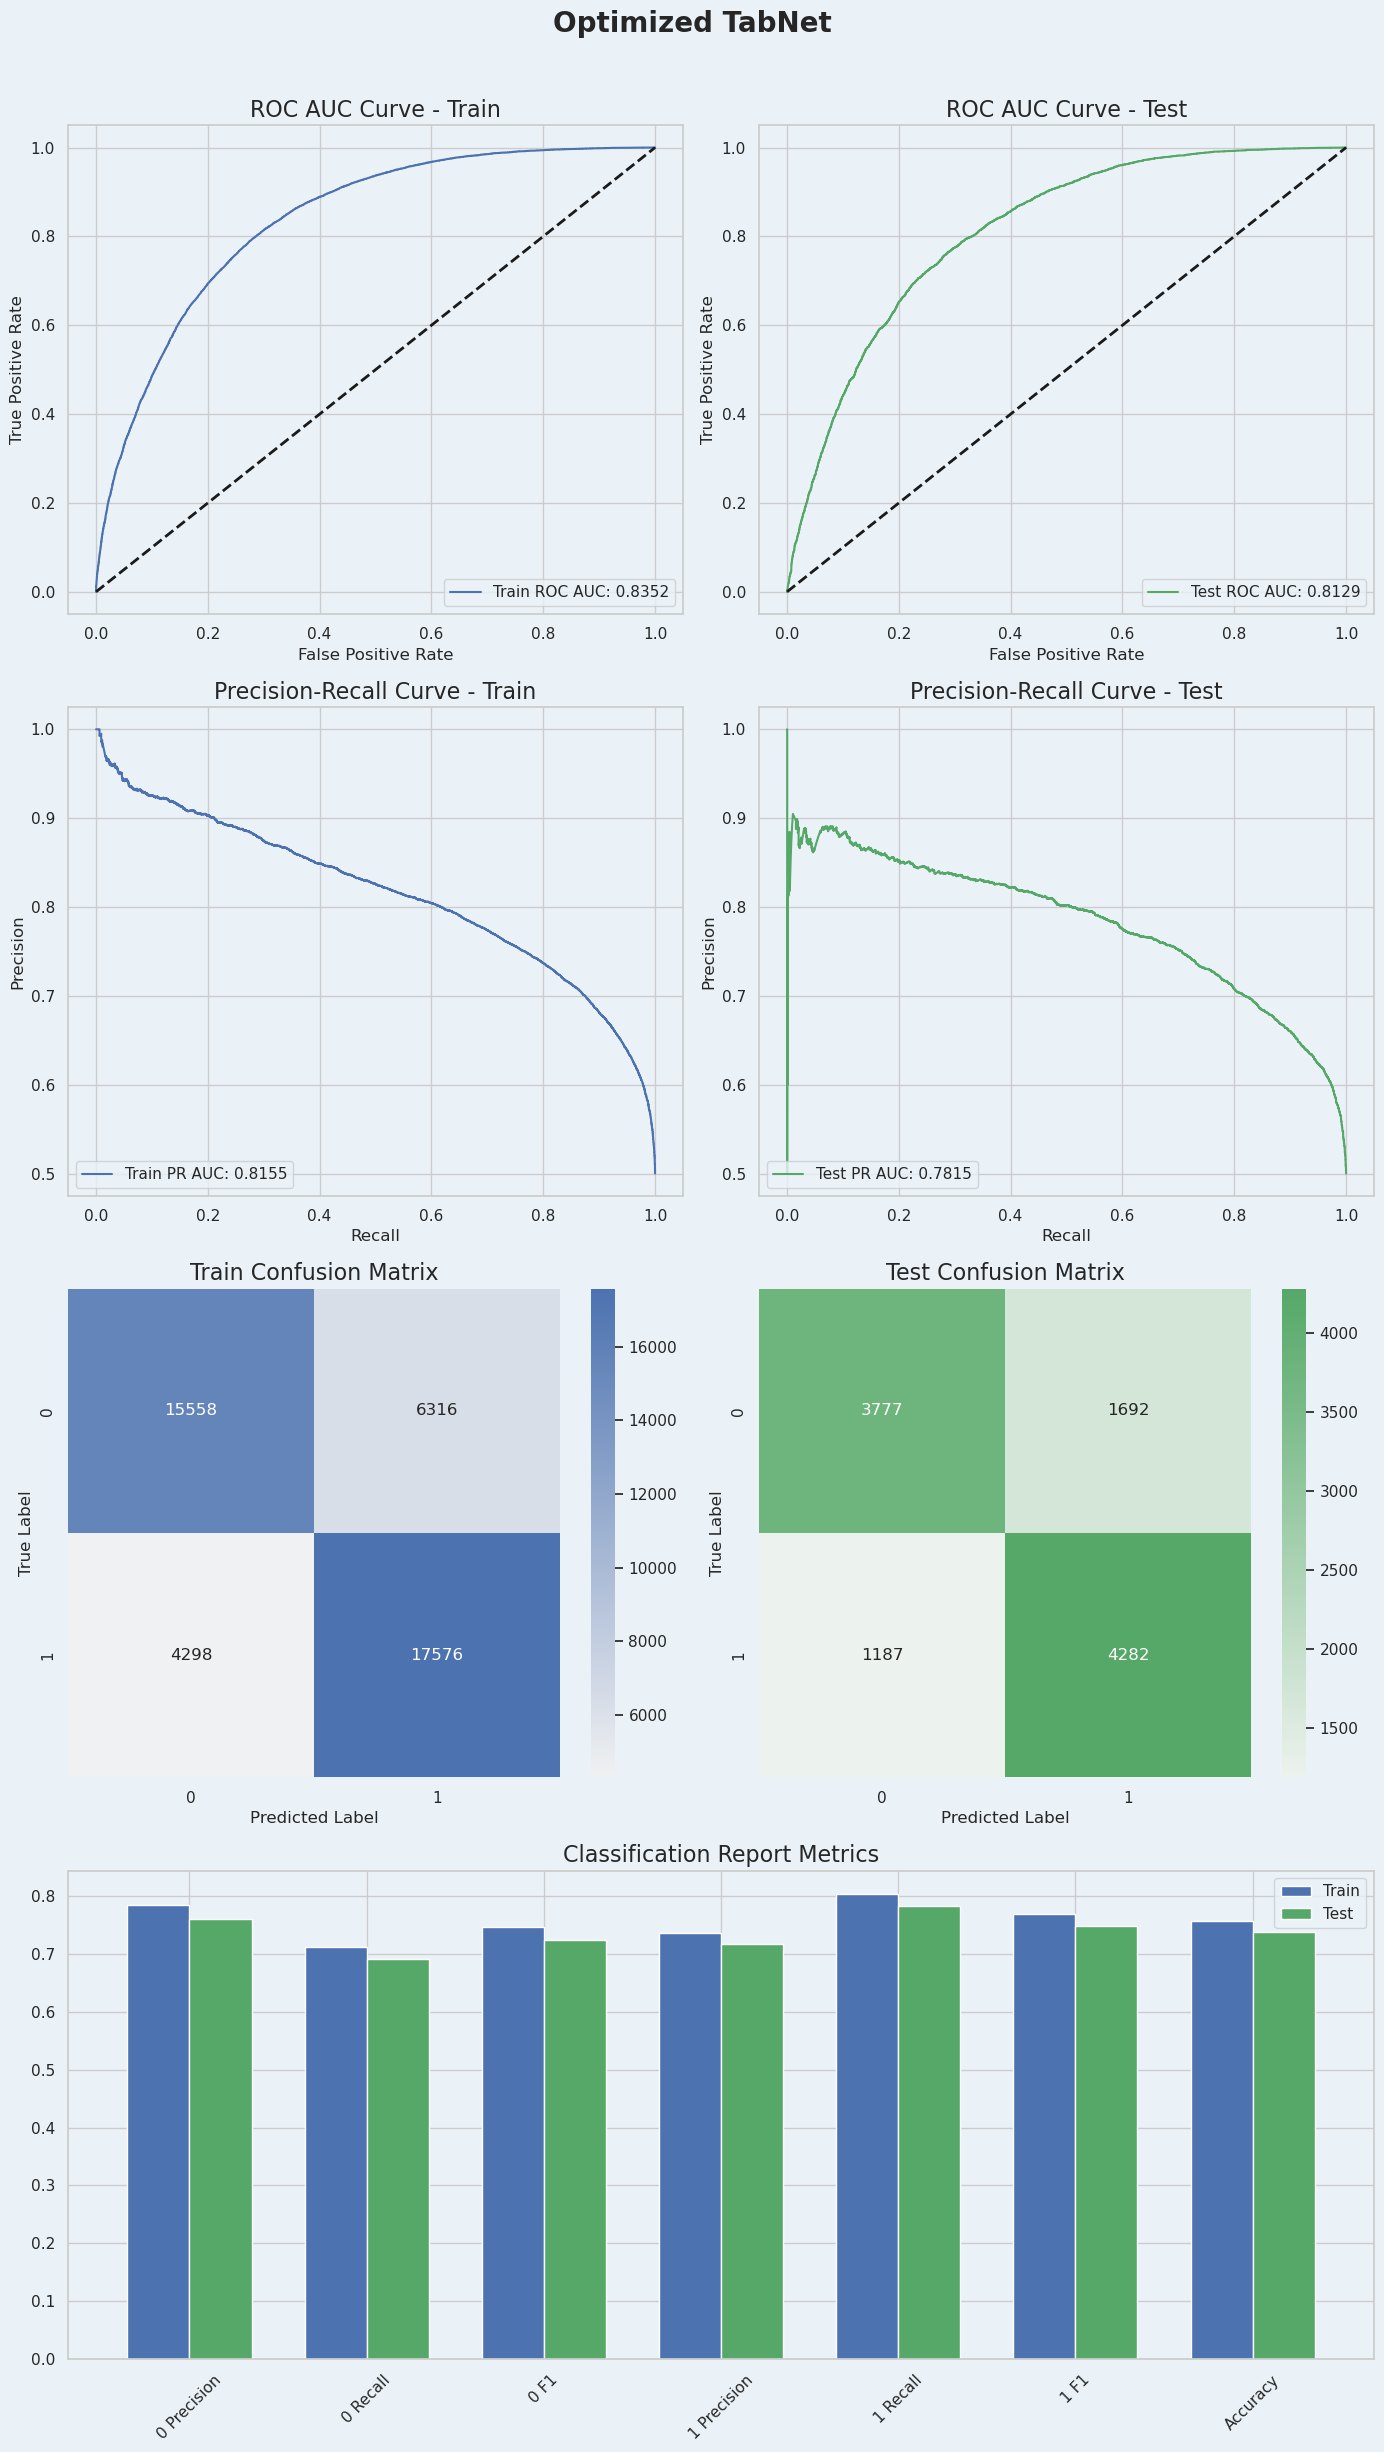

Test Classification Report:
               precision    recall  f1-score   support

Test Class 0       0.76      0.69      0.72      5469
Test Class 1       0.72      0.78      0.75      5469

    accuracy                           0.74     10938
   macro avg       0.74      0.74      0.74     10938
weighted avg       0.74      0.74      0.74     10938



In [95]:
# Evaluate the model using your custom evaluation function
evaluate_model(best_tabnet_clf, uX_train_tabnet.values, uy_train_tabnet, uX_test_tabnet.values, uy_test_tabnet, 'Optimized TabNet')

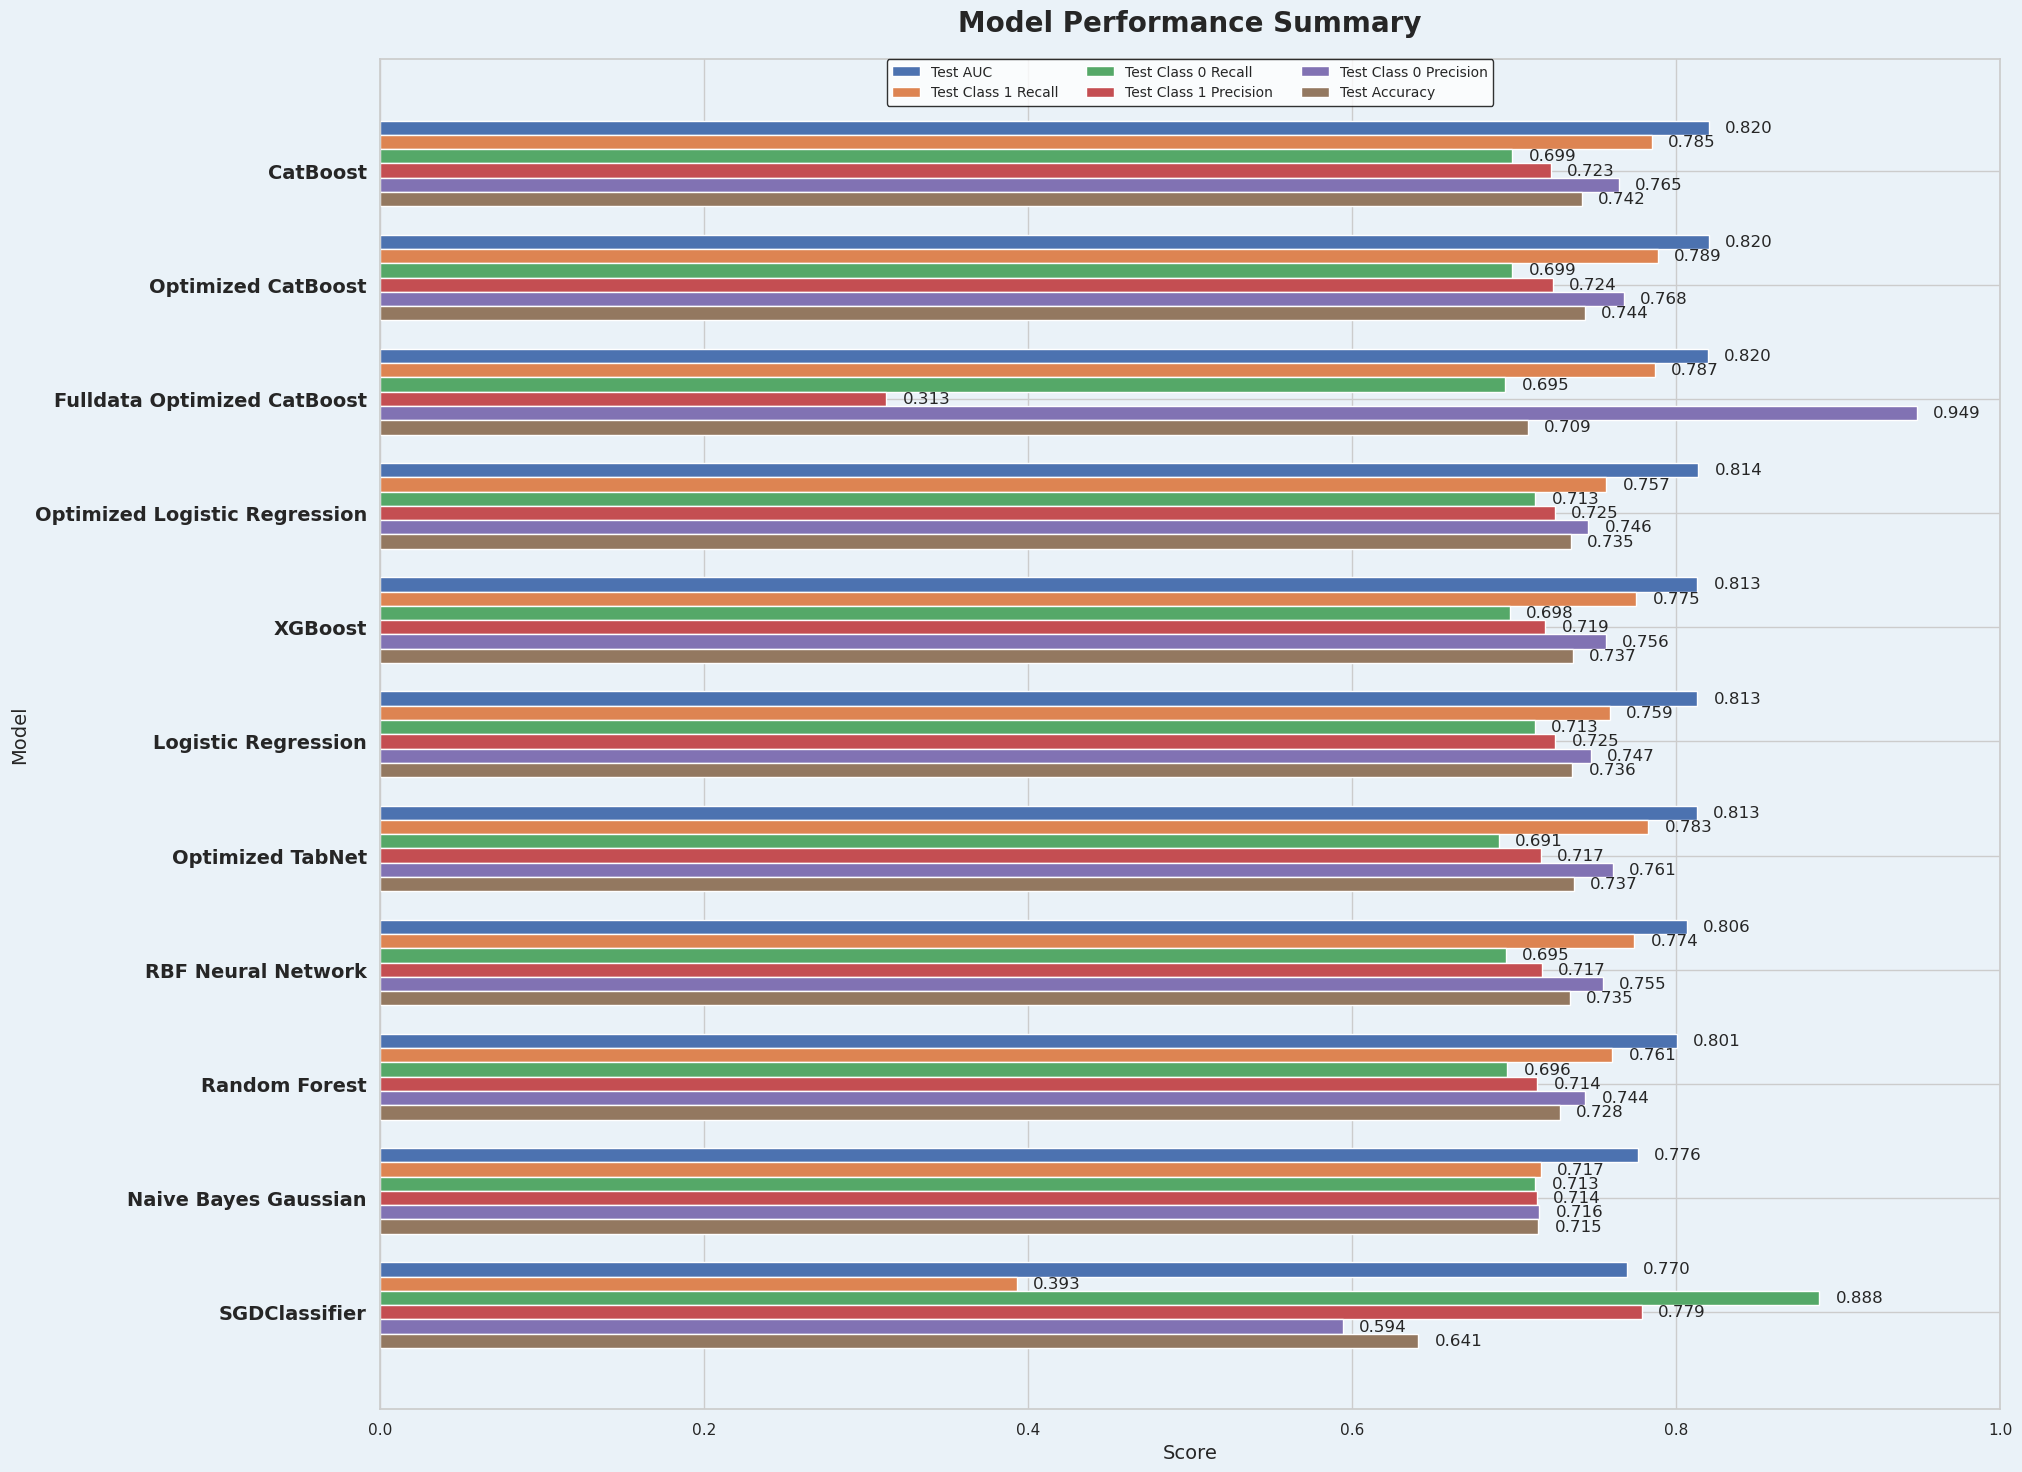

In [96]:
evaluation_summary()

## Summary
CatBoost is said to have strong out of the box defaults and tuning did not improve it despite training on it multiple times for long periods.  

For TabNet, although it achieved a slightly higher recall, this gain was minimal and came at the cost of a lower ROC AUC score, and tweaking the threshold is probably a better course.

Logistic regression showed a marginal improvement after tuning with grid search, but for the time and effort spent feature engineering might have been time better spent.  It is something you have to do to know the value of for a dataset however.

Overall, this hyperparameter tuning process was time-consuming, requiring extensive setup, execution, and evaluation. Despite these efforts, the results suggest that this dataset may not respond well to hyperparameter tuning. 

This dataset benefits more from feature engineering, binning, and balancing techniques than from hyperparameter tuning. 

# Finetune CatBoost on Full Data

## CatBoost

In [97]:
# Initialize the CatBoost model with the parameters you want to use
full_catboost_model = CatBoostClassifier(
    iterations=20000,  
    learning_rate=0.5,  # Base Rate was .1, sometimes you want to reduce the learning rate for fine-tuning
    depth=6,  # Same Depth
    eval_metric='Recall',
    random_seed=42,  # Ensure reproducibility
    task_type="CPU",  # Use CPU because CatBoost does not support training continuation with GPU
    logging_level='Silent'  # Suppress detailed output
)

# Fine-tune the model on the entire training set
full_catboost_model.fit(
    X_train, y_train,
    eval_set=(X_test, y_test), #This is used for early stopping only
    verbose=100,  # Print training progress every 100 iterations
    early_stopping_rounds=300,  # Stop early if there is no improvement
    init_model=catboost_model  # Continue training from the prior best model
)

## Evaluate

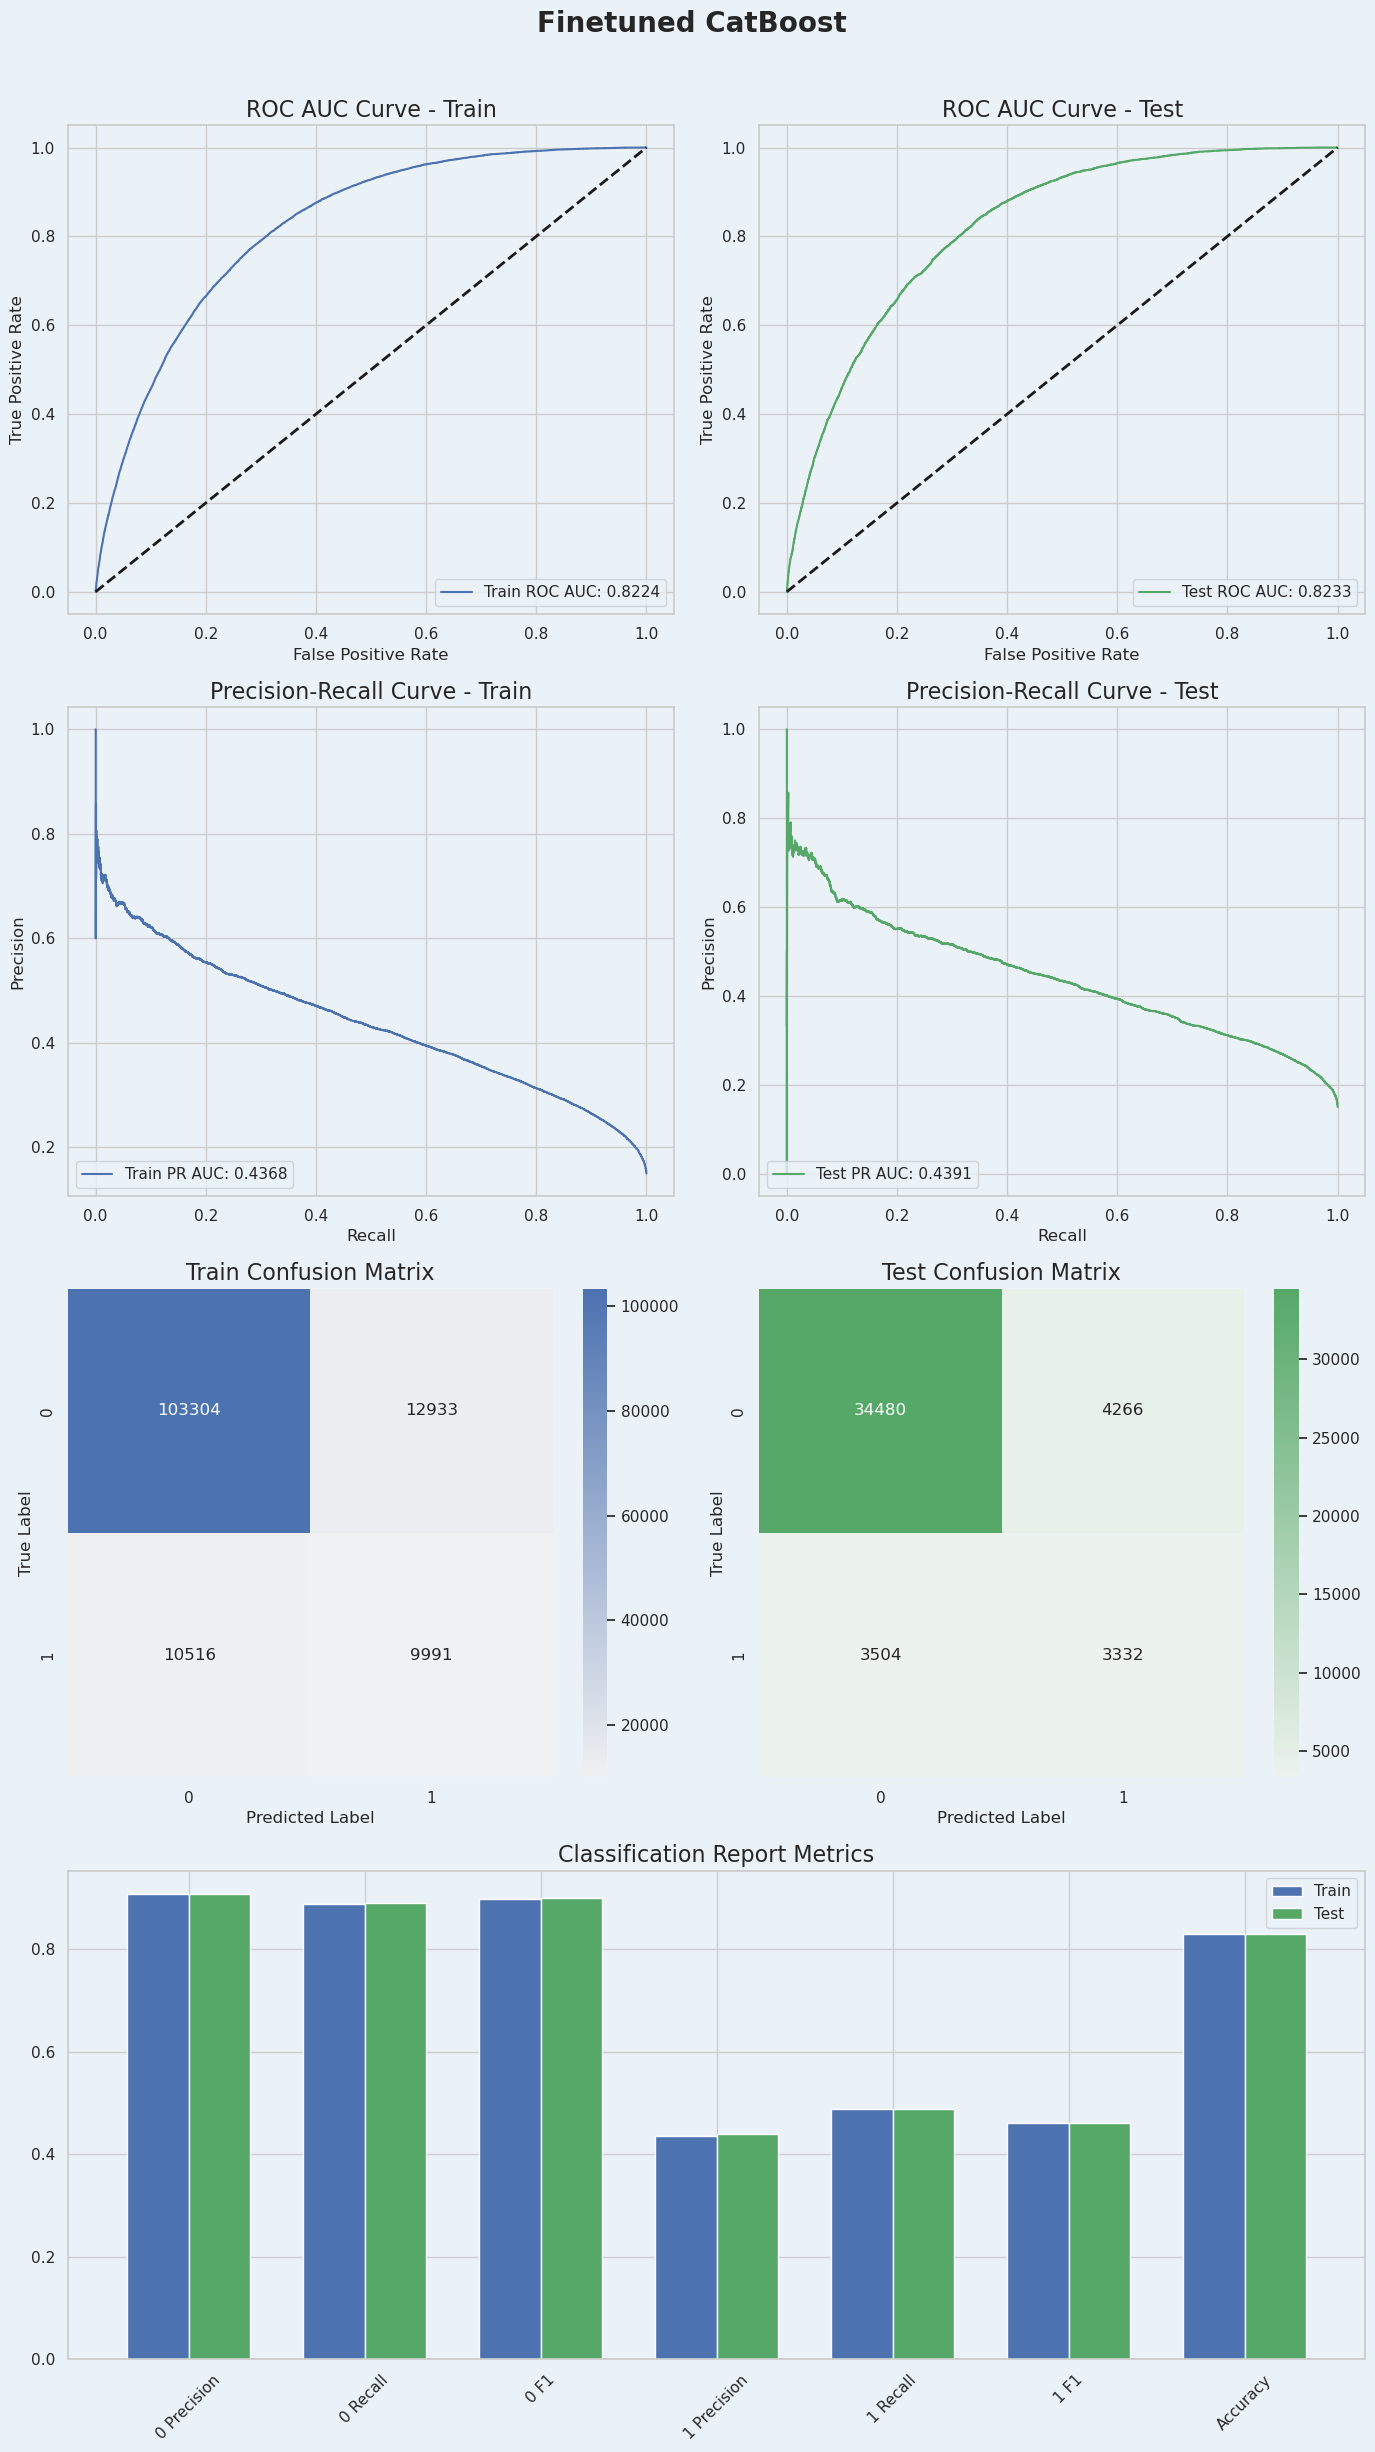

Test Classification Report:
               precision    recall  f1-score   support

Test Class 0       0.91      0.89      0.90     38746
Test Class 1       0.44      0.49      0.46      6836

    accuracy                           0.83     45582
   macro avg       0.67      0.69      0.68     45582
weighted avg       0.84      0.83      0.83     45582



In [98]:
evaluate_model(full_catboost_model, X_train, y_train, X_test, y_test, 'Finetuned CatBoost')

It seems the changes are really minimal to ROC AUC but worse.

What really changes is the balance of the classifications.  0 Precision shoots up.  1 Precision and 1 F1 score go down.  Accuracy is worse.  Though it does boost 1 Recall some.

I tried this with lots of iterations too and a bigger learning rate the results are almost always the same.
It seems mostly to mess with thresholds because even very minor changes to the model can change key thresholds.

I think the best thing to do is use the original best AUC Score do threshold tuning instead.

# Stack CatBoost and Logistic Regression

## Generate Predictions from CatBoost Model

In [134]:
catboost_train_preds = full_catboost_model.predict_proba(X_train)[:, 1].reshape(-1, 1)
catboost_test_preds = full_catboost_model.predict_proba(X_test)[:, 1].reshape(-1, 1)
stacked_train_features = np.hstack((X_train, catboost_train_preds))
stacked_test_features = np.hstack((X_test, catboost_test_preds))

## Train Stacked

In [143]:
# Define the logistic regression hyperparameter grid
stacked_logistic_optimal = True  # renamed from log_use_optimal_params

if stacked_logistic_optimal:
    #'best_cross_val_score': 0.8223050484330885,
    #'test_set_score': 0.855864156904041
    param_grid = {
        'model__C': [0.01],
        'model__max_iter': [100],
        'model__penalty': ['l1'],
        'scaler': [MinMaxScaler()],
    }
else:
    param_grid = [
        {
            'scaler': [None, StandardScaler(), MinMaxScaler(), RobustScaler()],
            'model__penalty': ['none'],
            'model__C': [1],
            'model__max_iter': [100, 500, 1000]
        },
        {
            'scaler': [None, StandardScaler(), MinMaxScaler(), RobustScaler()],
            'model__penalty': ['l1', 'l2'],
            'model__C': [0.01, 0.1, 1, 10, 100],
            'model__max_iter': [100, 500, 1000]
        },
        {
            'scaler': [None, StandardScaler(), MinMaxScaler(), RobustScaler()],
            'model__penalty': ['elasticnet'],
            'model__C': [0.01, 0.1, 1, 10, 100],
            'model__max_iter': [100, 500, 1000],
            'model__l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]
        }
    ]

# Create the pipeline for logistic regression
stacked_pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Placeholder for scaler
    ('model', LogisticRegression(solver='saga', random_state=42))  # Use saga to handle elasticnet
])

# Initialize the grid search with the parameter grid
grid_search = GridSearchCV(stacked_pipeline, param_grid, cv=5, n_jobs=-1, scoring='roc_auc', error_score=np.nan)

# Fit the grid search on the stacked features
grid_search.fit(stacked_train_features, y_train.values.ravel())

# Best parameters and score
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Score:", grid_search.best_score_)

# Evaluate on the test set
stacked_model = grid_search.best_estimator_
test_score = stacked_model.score(stacked_test_features, y_test.values.ravel())
print("Test Set Score:", test_score)

Best Parameters: {'model__C': 0.01, 'model__max_iter': 100, 'model__penalty': 'l1', 'scaler': MinMaxScaler()}
Best Cross-Validation Score: 0.8223050484330885
Test Set Score: 0.855864156904041


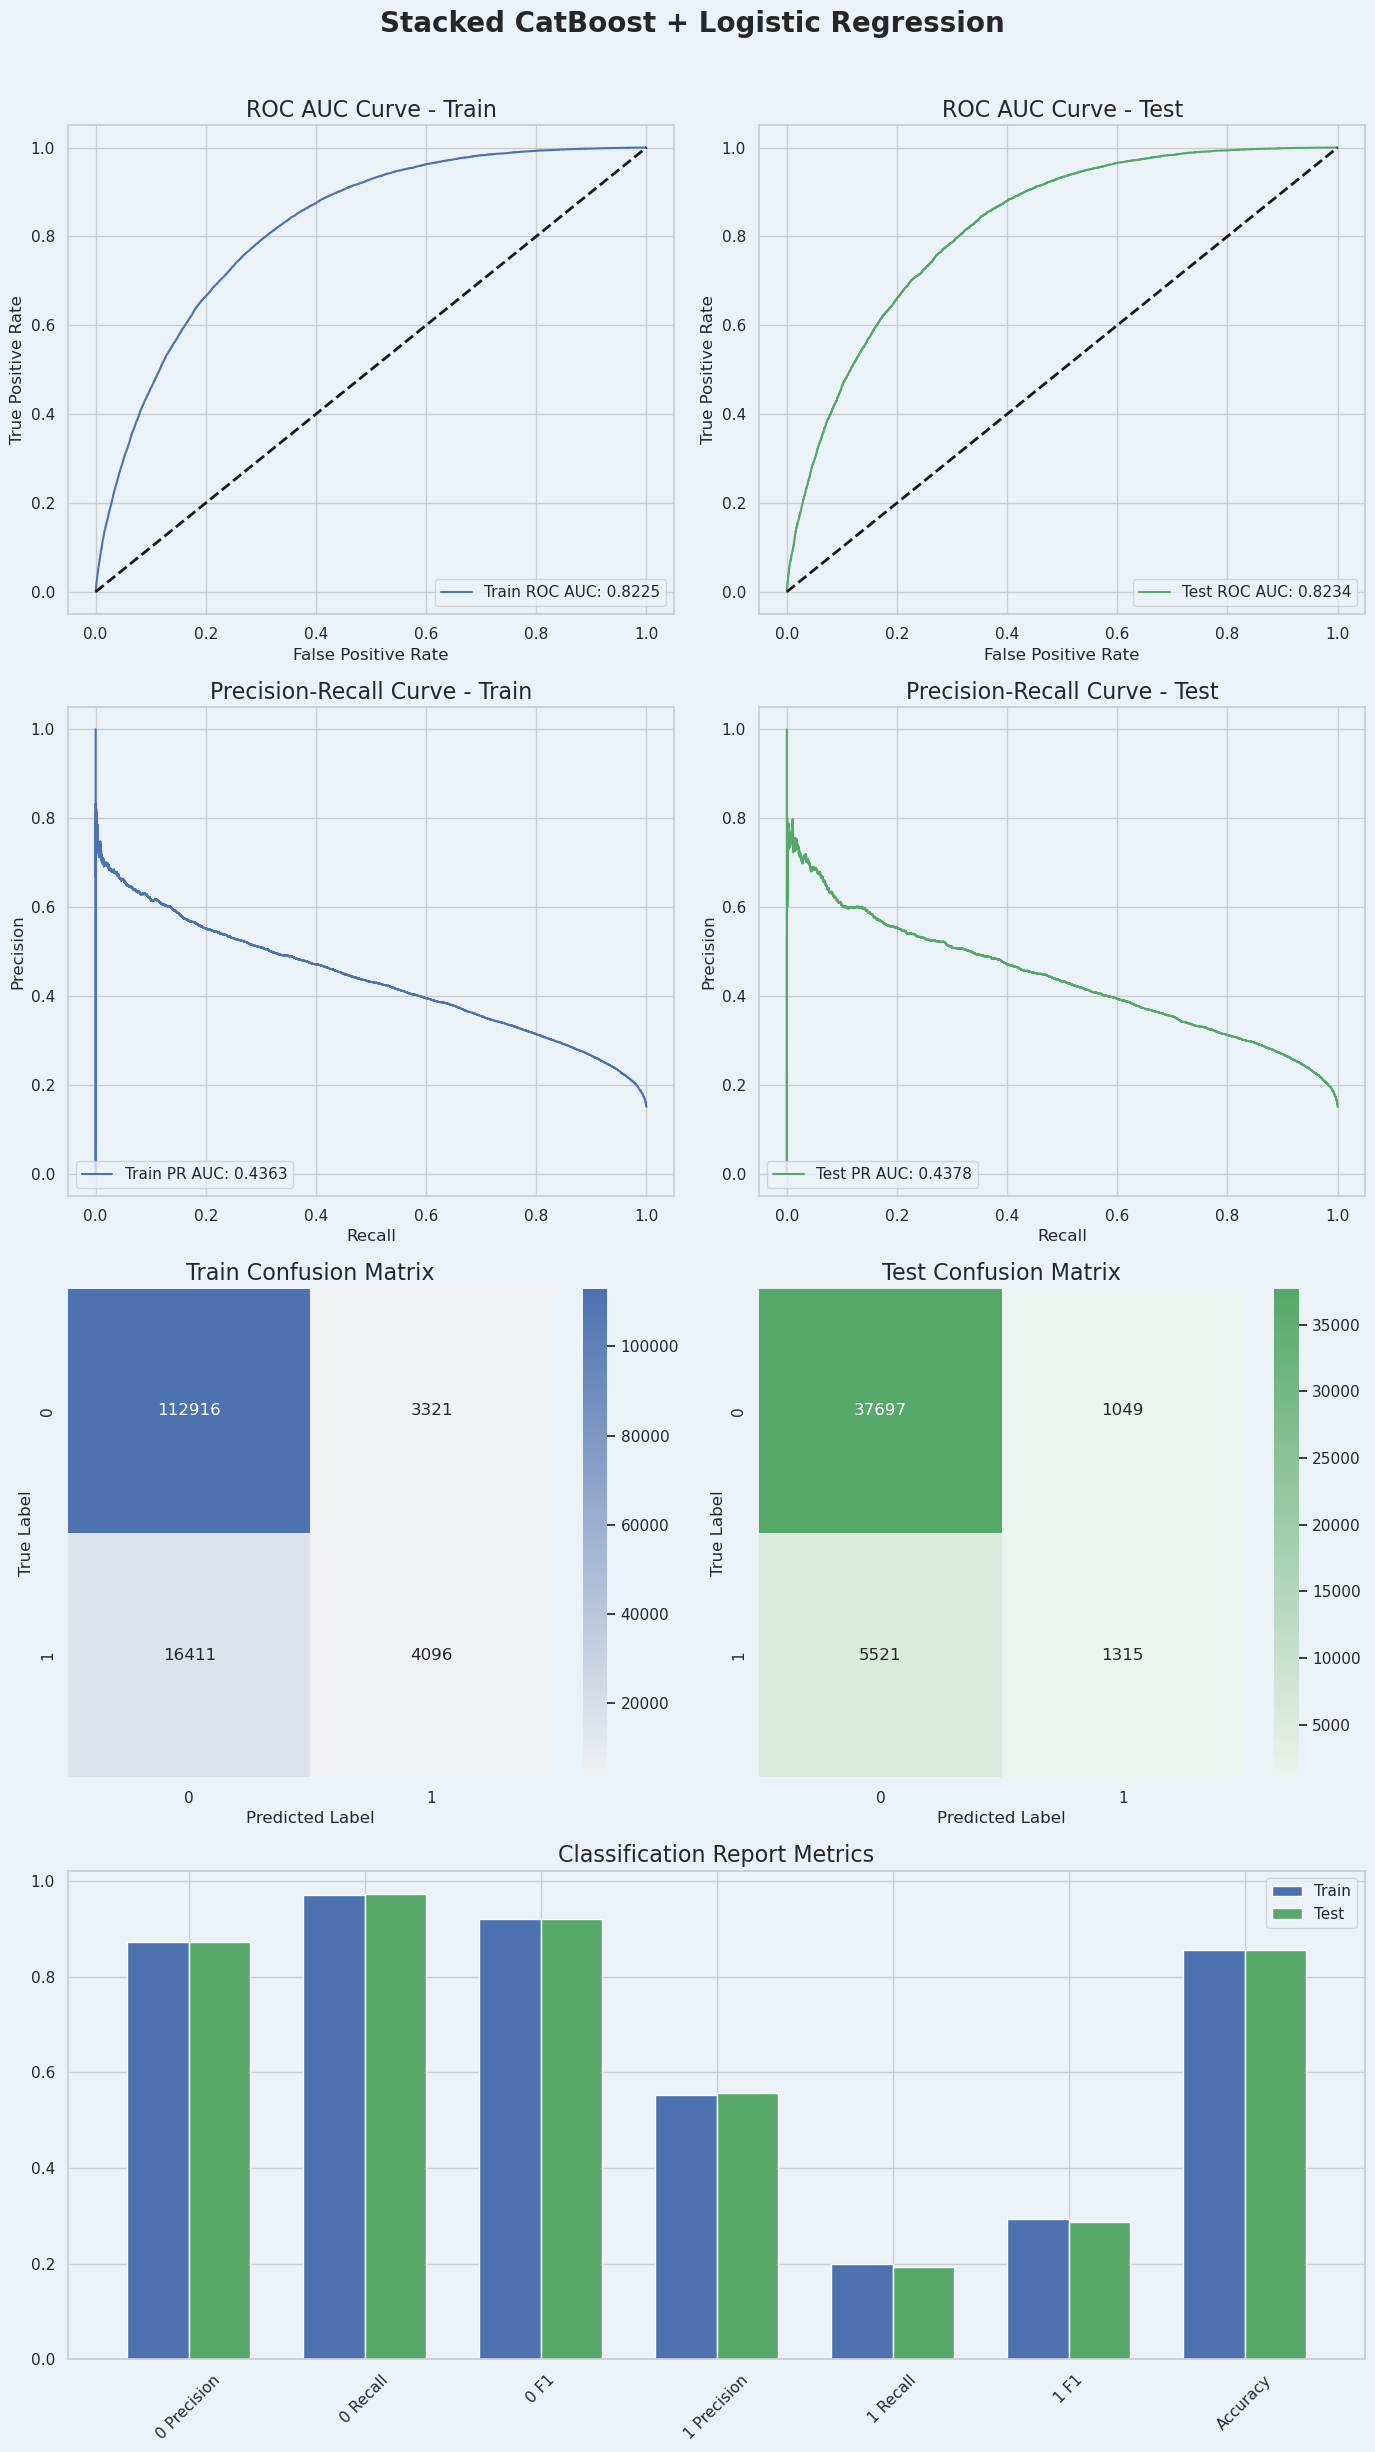

Test Classification Report:
               precision    recall  f1-score   support

Test Class 0       0.87      0.97      0.92     38746
Test Class 1       0.56      0.19      0.29      6836

    accuracy                           0.86     45582
   macro avg       0.71      0.58      0.60     45582
weighted avg       0.82      0.86      0.82     45582



In [144]:
evaluate_model(stacked_model, stacked_train_features, y_train, stacked_test_features, y_test, 'Stacked CatBoost + Logistic Regression')

# Average CatBoost, Logistic Regression

In [154]:
# Generate predictions (probabilities) for the training and test sets from both models
catboost_train_preds = full_catboost_model.predict_proba(X_train)[:, 1]
catboost_test_preds = full_catboost_model.predict_proba(X_test)[:, 1]

logistic_train_preds = tuned_logistic_model.predict_proba(X_train)[:, 1]
logistic_test_preds = tuned_logistic_model.predict_proba(X_test)[:, 1]

## Averaged Predictions

In [155]:
# Average the predictions
averaged_train_preds = (catboost_train_preds + logistic_train_preds) / 2
averaged_test_preds = (catboost_test_preds + logistic_test_preds) / 2

## Averaged Classifier

In [162]:
class AveragedModel(BaseEstimator, ClassifierMixin):
    def __init__(self, model1, model2, threshold=0.5):
        self.model1 = model1
        self.model2 = model2
        self.threshold = threshold
    
    def predict_proba(self, X):
        # Compute the predictions dynamically based on the input X
        model1_probs = self.model1.predict_proba(X)[:, 1]
        model2_probs = self.model2.predict_proba(X)[:, 1]
        averaged_probs = (model1_probs + model2_probs) / 2
        return np.vstack([1 - averaged_probs, averaged_probs]).T
    
    def predict(self, X):
        # Apply the threshold to determine class labels
        probs = self.predict_proba(X)[:, 1]
        return (probs >= self.threshold).astype(int)

# Instantiate the averaged model with actual models
averaged_model = AveragedModel(model1=full_catboost_model, model2=tuned_logistic_model)

## Evaluation

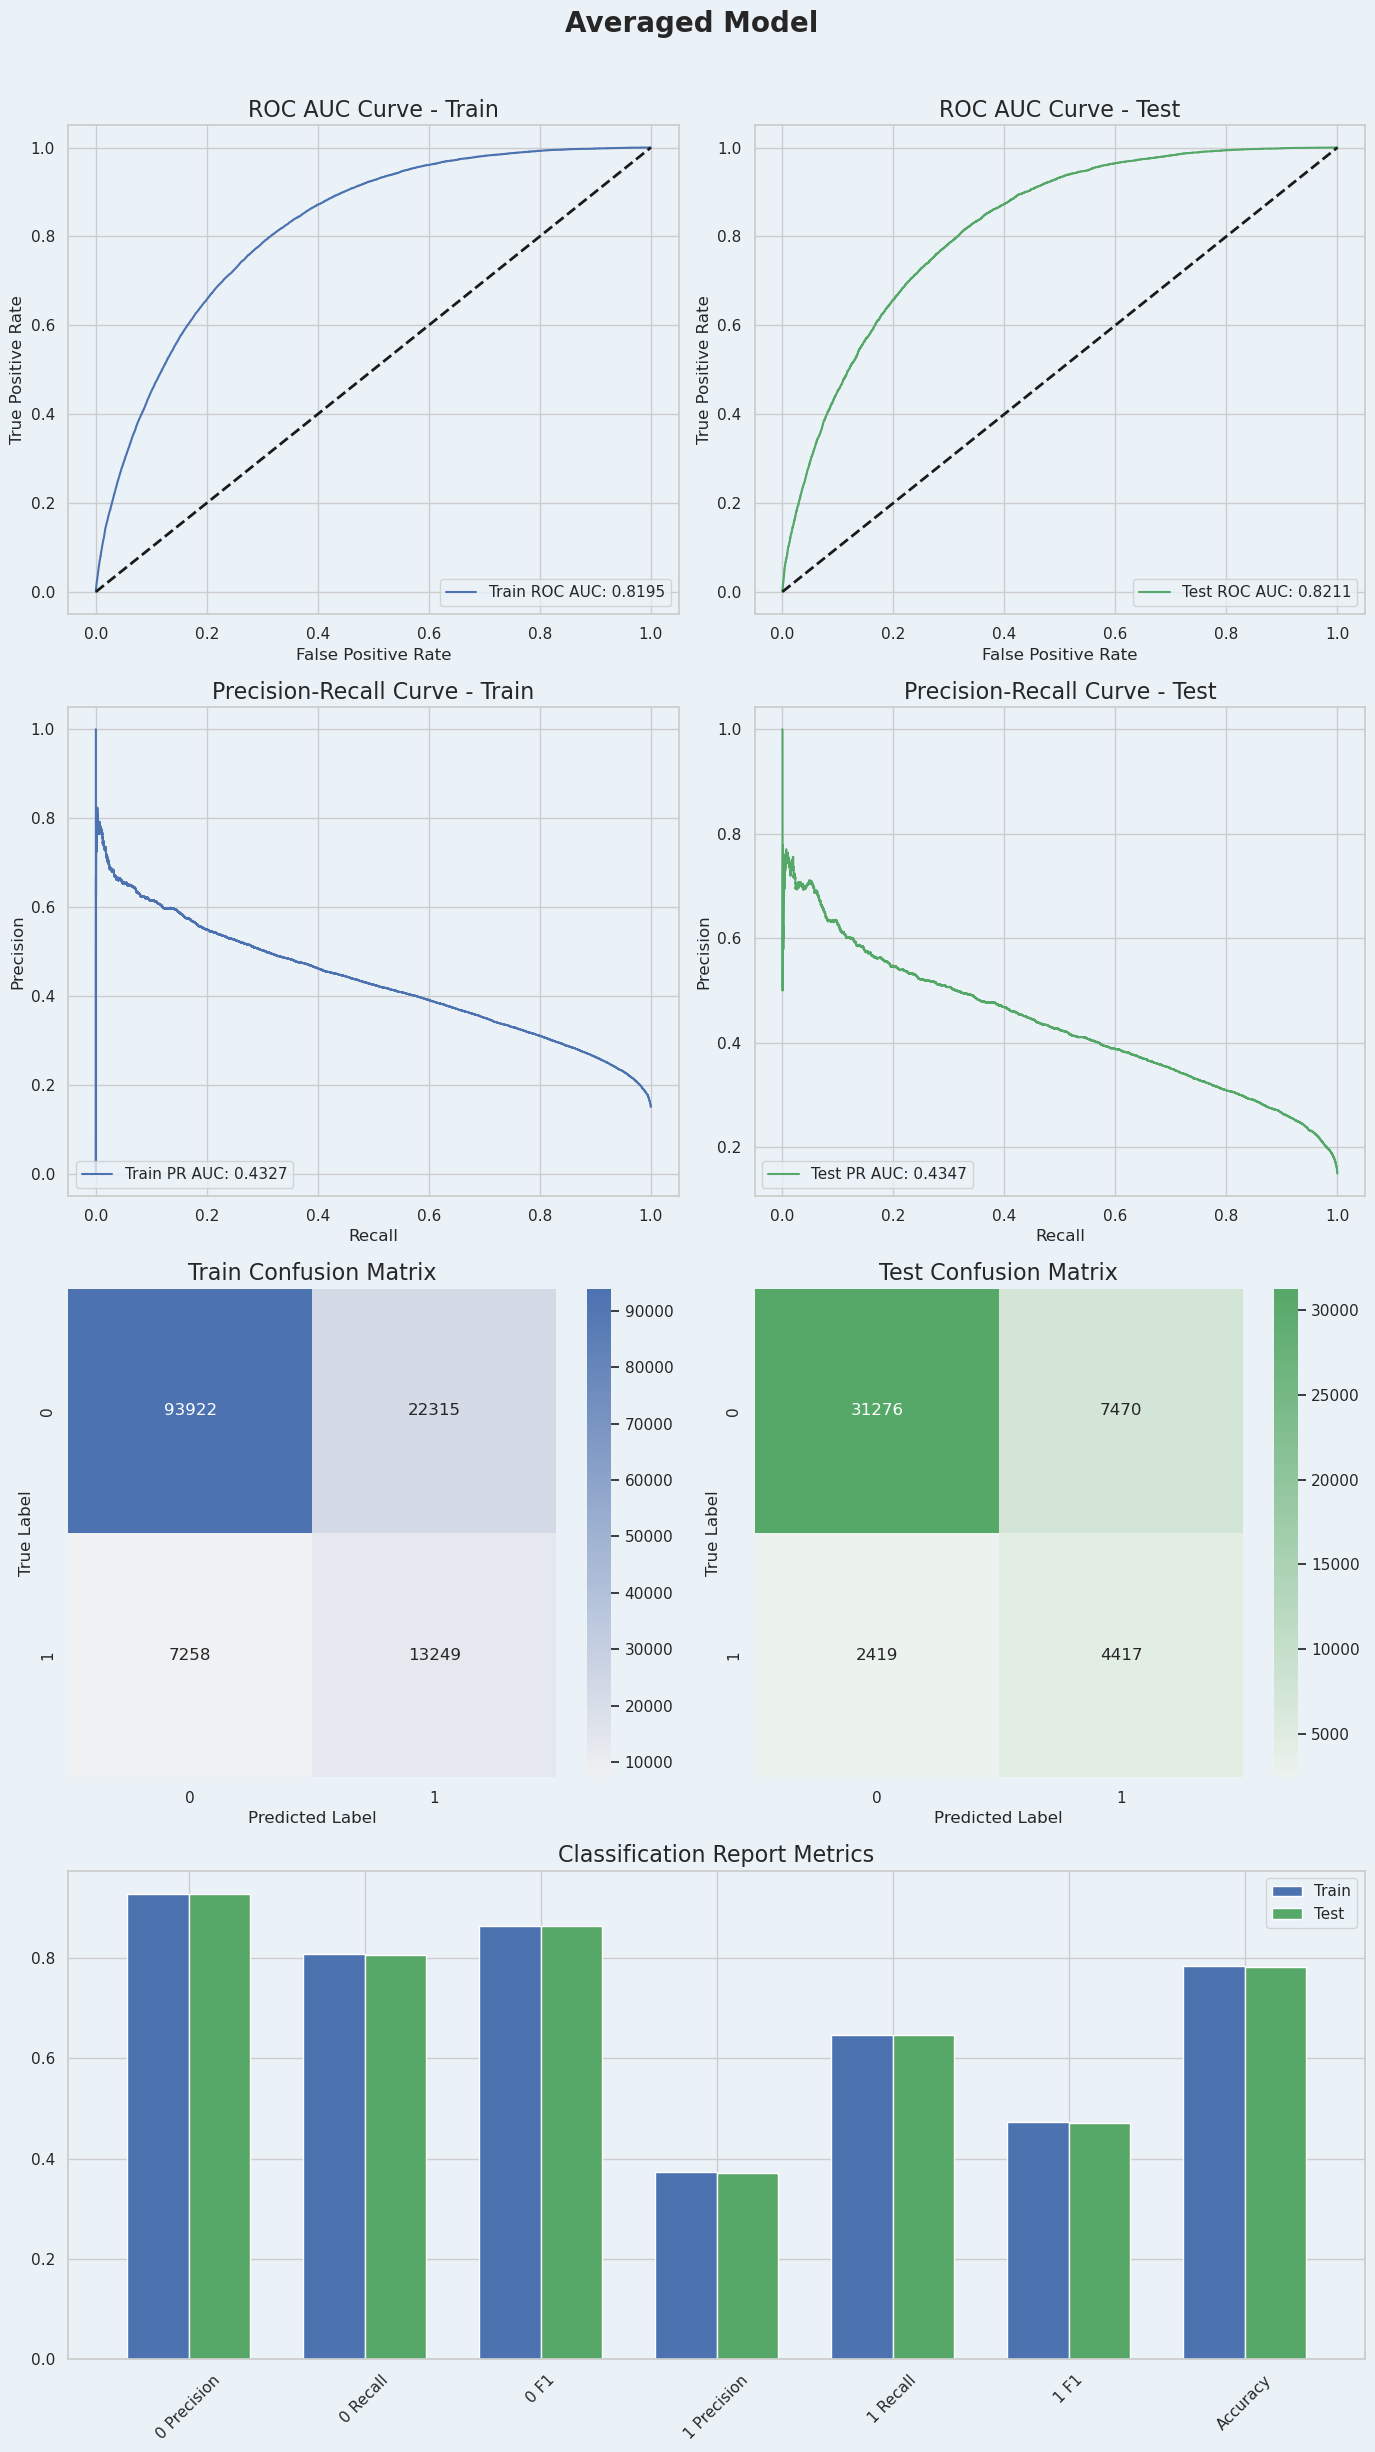

Test Classification Report:
               precision    recall  f1-score   support

Test Class 0       0.93      0.81      0.86     38746
Test Class 1       0.37      0.65      0.47      6836

    accuracy                           0.78     45582
   macro avg       0.65      0.73      0.67     45582
weighted avg       0.84      0.78      0.80     45582



In [163]:
# Evaluate the averaged model
evaluate_model(averaged_model, X_train, y_train, X_test, y_test, 'Averaged Model')

# Threshold Tuning and Model Evaluations

In [126]:
def evaluate_threshold(y_true, y_prob, threshold):
    y_pred = (y_prob >= threshold).astype(int)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_prob)
    
    return {
        'Threshold': threshold,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'Accuracy': accuracy,
        'AUC': auc
    }
def model_thresholds(model,tX_test,ty_test,title='',showplot=False):
    y_test_prob = model.predict_proba(tX_test)[:, 1]

    thresholds = np.arange(0.1, 0.9, 0.05)  # Define a range of thresholds to test
    results = []

    for threshold in thresholds:
        metrics = evaluate_threshold(ty_test, y_test_prob, threshold)
        results.append(metrics)

    # Convert to a DataFrame for easier analysis
    results_df = pd.DataFrame(results)
    if showplot:
        plt.figure(figsize=(10, 6))
        plt.plot(results_df['Threshold'], results_df['Precision'], label='Precision')
        plt.plot(results_df['Threshold'], results_df['Recall'], label='Recall')
        plt.plot(results_df['Threshold'], results_df['F1 Score'], label='F1 Score')
        plt.plot(results_df['Threshold'], results_df['Accuracy'], label='Accuracy')
        plt.xlabel('Threshold')
        plt.ylabel('Score')
        plt.title(title)
        plt.legend()
        plt.grid(True)
        plt.show()

    return results_df, title

def report_at_threshold(best_threshold,model,tX_test,ty_test):
    y_test_prob = model.predict_proba(tX_test)[:, 1]
    y_test_pred_adjusted = (y_test_prob >= best_threshold).astype(int)

    # Confusion Matrix
    conf_matrix = confusion_matrix(ty_test, y_test_pred_adjusted)
    print("Confusion Matrix:\n", conf_matrix)

    # Classification Report
    class_report = classification_report(ty_test, y_test_pred_adjusted)
    print("Classification Report:\n", class_report)

def plot_subplots(models_data):
    fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(16, 18))
    axes = axes.flatten()

    for i, (model_data, title) in enumerate(models_data):
        ax = axes[i]
        ax.plot(model_data['Threshold'], model_data['Precision'], label='Precision')
        ax.plot(model_data['Threshold'], model_data['Recall'], label='Recall')
        ax.plot(model_data['Threshold'], model_data['F1 Score'], label='F1 Score')
        ax.plot(model_data['Threshold'], model_data['Accuracy'], label='Accuracy')
        ax.set_title(title)
        ax.set_xlabel('Threshold')
        ax.set_ylabel('Score')
        ax.legend()
        ax.grid(True)

    plt.tight_layout()
    plt.show()

## Subplot Model Threshold Evaluations

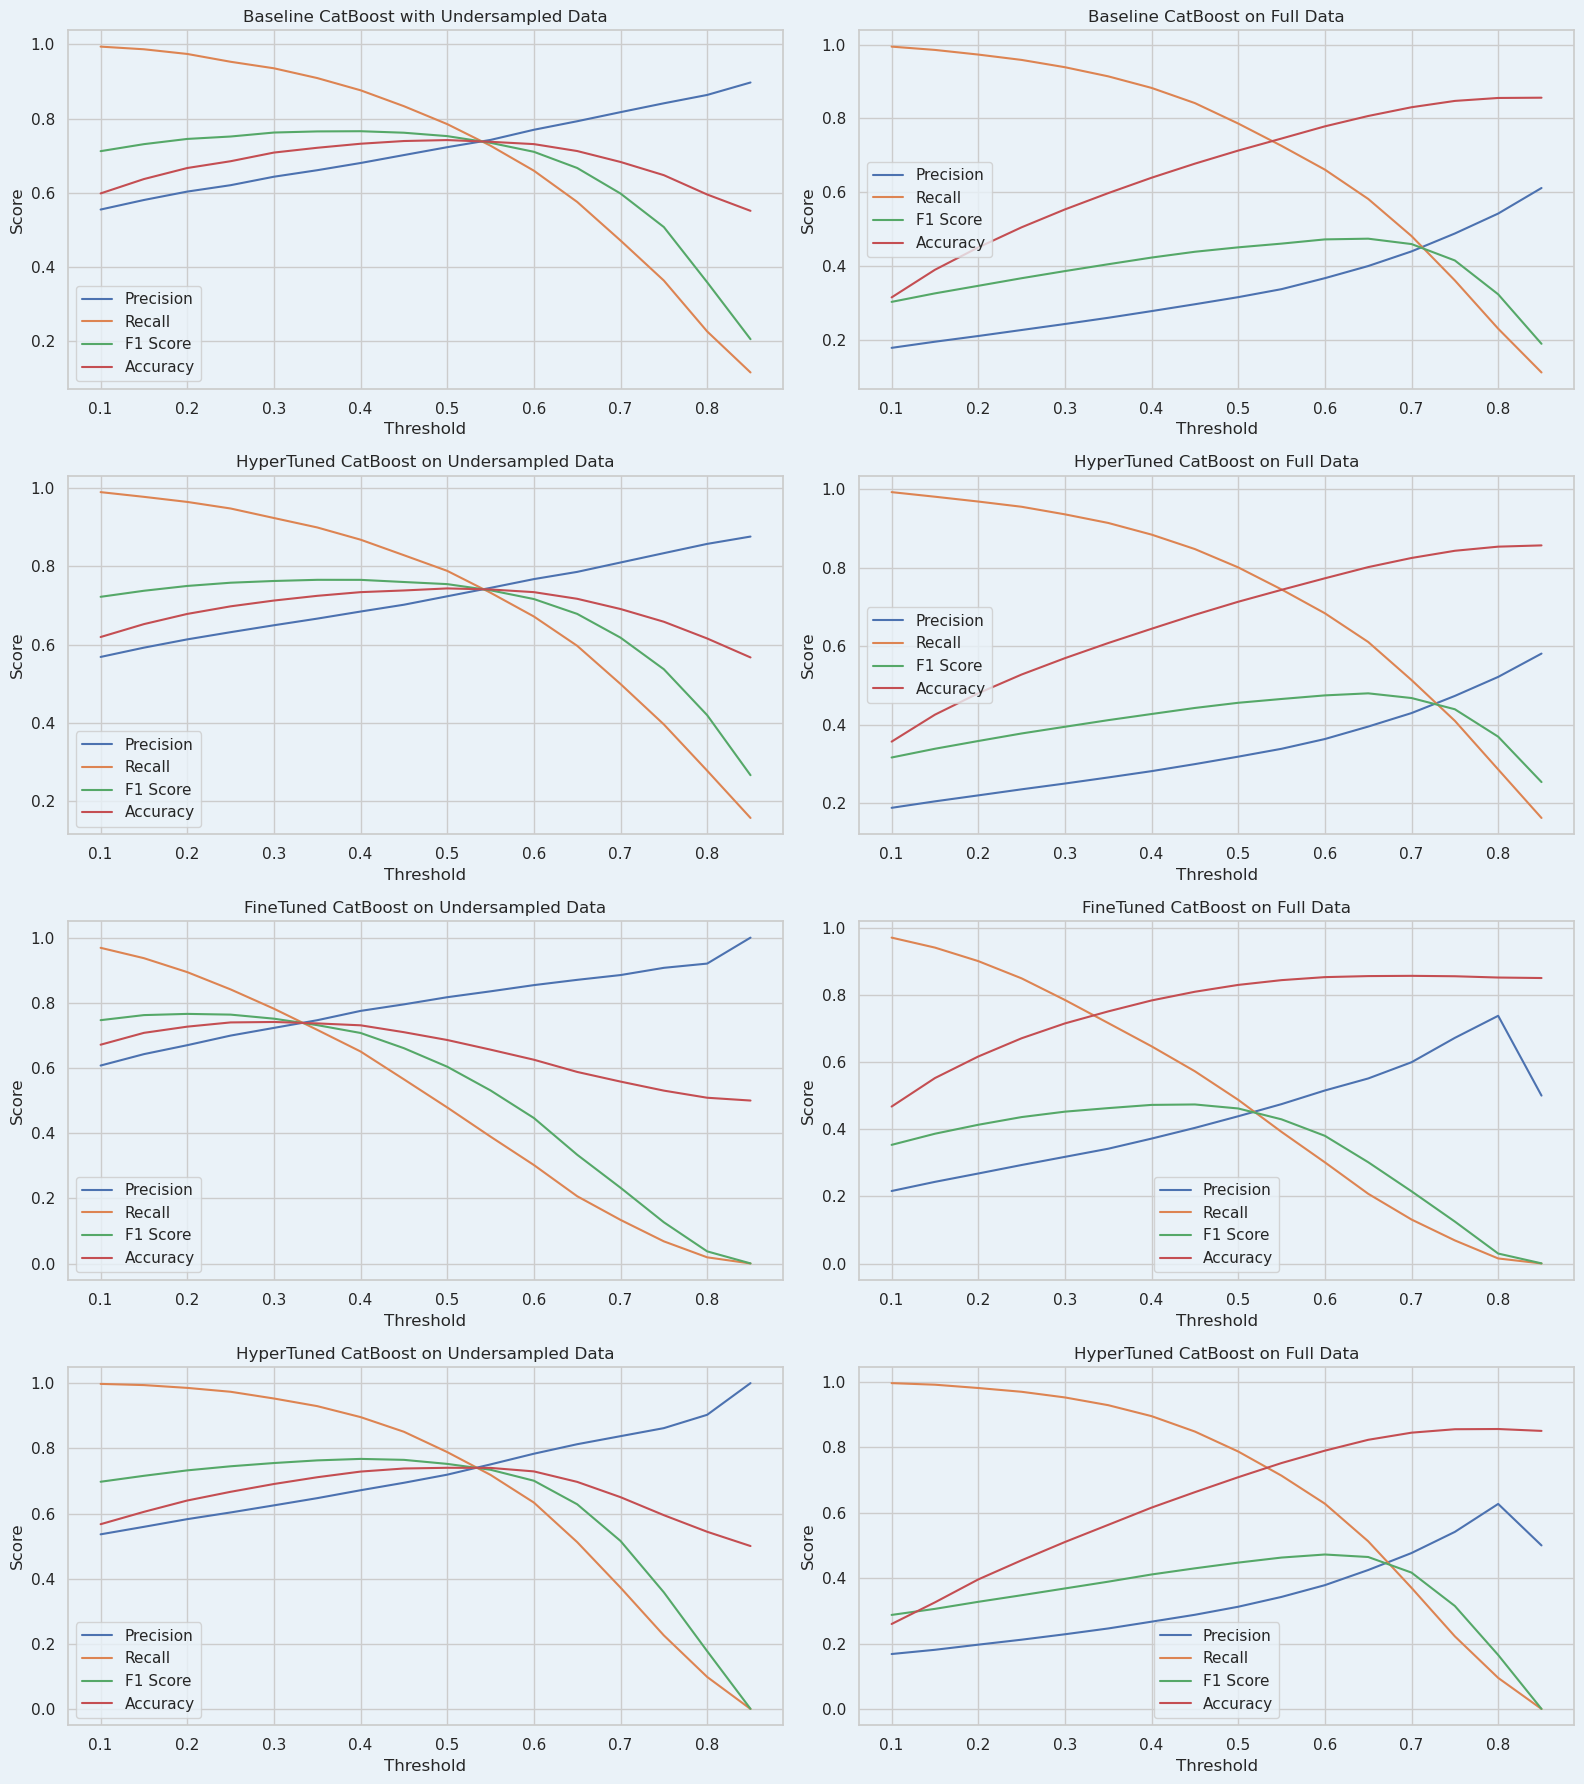

In [121]:
# Collect data for all models and datasets
models_data = []

# Baseline CatBoost with undersampled data
thresh_df, title = model_thresholds(catboost_model, uX_test, uy_test, "Baseline CatBoost with Undersampled Data")
models_data.append((thresh_df, title))

# Baseline CatBoost with Full Data
thresh_df, title = model_thresholds(catboost_model, X_test, y_test, 'Baseline CatBoost on Full Data')
models_data.append((thresh_df, title))

# HyperTuned CatBoost with Undersampled Data
thresh_df, title = model_thresholds(best_catboost_model, uX_test, uy_test, 'HyperTuned CatBoost on Undersampled Data')
models_data.append((thresh_df, title))

# HyperTuned CatBoost with Full Data
thresh_df, title = model_thresholds(best_catboost_model, X_test, y_test, 'HyperTuned CatBoost on Full Data')
models_data.append((thresh_df, title))

# FineTuned CatBoost on Undersampled Data
thresh_df, title = model_thresholds(full_catboost_model, uX_test, uy_test, 'FineTuned CatBoost on Undersampled Data')
models_data.append((thresh_df, title))

# FineTuned CatBoost on Full Data
thresh_df, title = model_thresholds(full_catboost_model, X_test, y_test, 'FineTuned CatBoost on Full Data')
models_data.append((thresh_df, title))

# Hypertuned CatBoost on Undersampled Data
thresh_df, title = model_thresholds(fd_best_catboost_model, uX_test, uy_test, 'HyperTuned CatBoost on Undersampled Data')
models_data.append((thresh_df, title))

# Hypertuned CatBoost on Full Data
thresh_df, title = model_thresholds(fd_best_catboost_model, X_test, y_test, 'HyperTuned CatBoost on Full Data')
models_data.append((thresh_df, title))

# Plot all subplots
plot_subplots(models_data)

## Plot for Holdout and FineTuned CatBoost

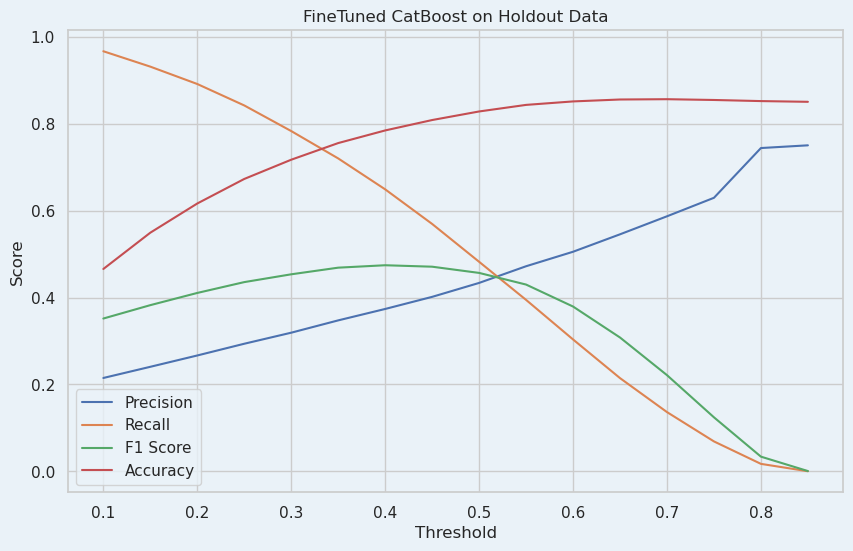

In [124]:
# FineTuned CatBoost on Holdout Data
thresh_df, title = model_thresholds(full_catboost_model, X_holdout, y_holdout, 'FineTuned CatBoost on Holdout Data', showplot=True)
models_data.append((thresh_df, title))

## Threshold Compare

In [167]:
report_at_threshold(.28,full_catboost_model,X_holdout,y_holdout)

Confusion Matrix:
 [[26397 12349]
 [ 1321  5515]]
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.68      0.79     38746
           1       0.31      0.81      0.45      6836

    accuracy                           0.70     45582
   macro avg       0.63      0.74      0.62     45582
weighted avg       0.86      0.70      0.74     45582



## Plot for Stacked CatBoost and Logistic Regression on Holdout

/home/atrix/anaconda3/envs/pytorch-env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/atrix/anaconda3/envs/pytorch-env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


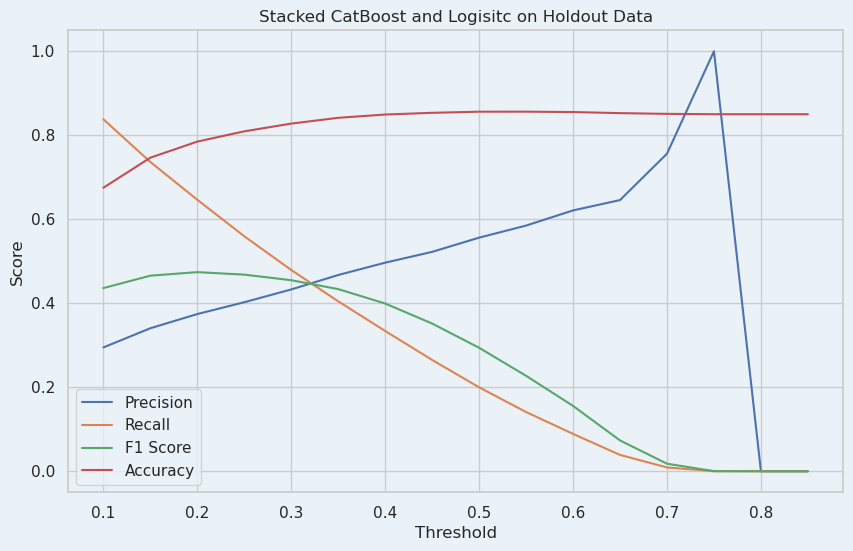

In [149]:
# Stack the predictions with the original holdout features
catboost_holdout_preds = full_catboost_model.predict_proba(X_holdout)[:, 1].reshape(-1, 1)
stacked_holdout_features = np.hstack((X_holdout, catboost_holdout_preds))

thresh_df, title = model_thresholds(stacked_model, stacked_holdout_features, y_holdout, 'Stacked CatBoost and Logisitc on Holdout Data', showplot=True)
models_data.append((thresh_df, title))

This model is going to be less reliable overall.

## Plot for Averaged Model on Test Data

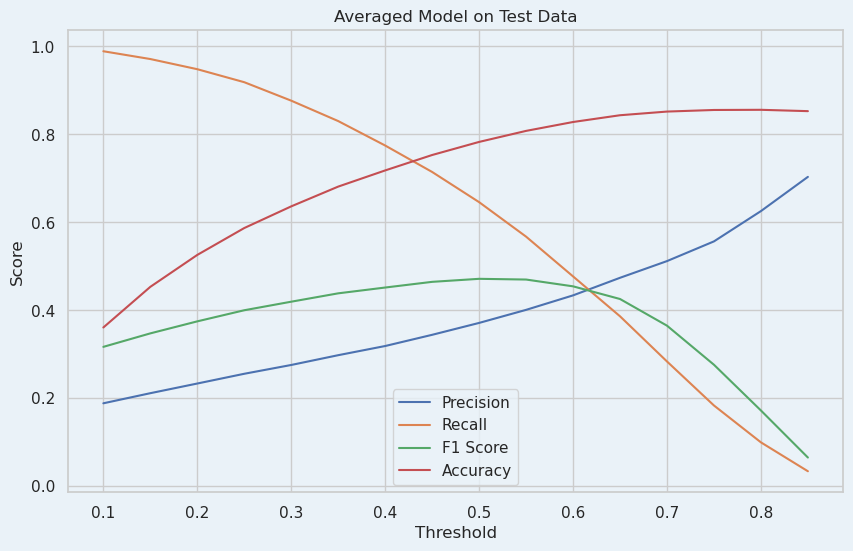

In [164]:
thresh_df, title = model_thresholds(averaged_model, X_test, y_test, 'Averaged Model on Test Data', showplot=True)
models_data.append((thresh_df, title))

## Plot for Averaged Model on Holdout Data

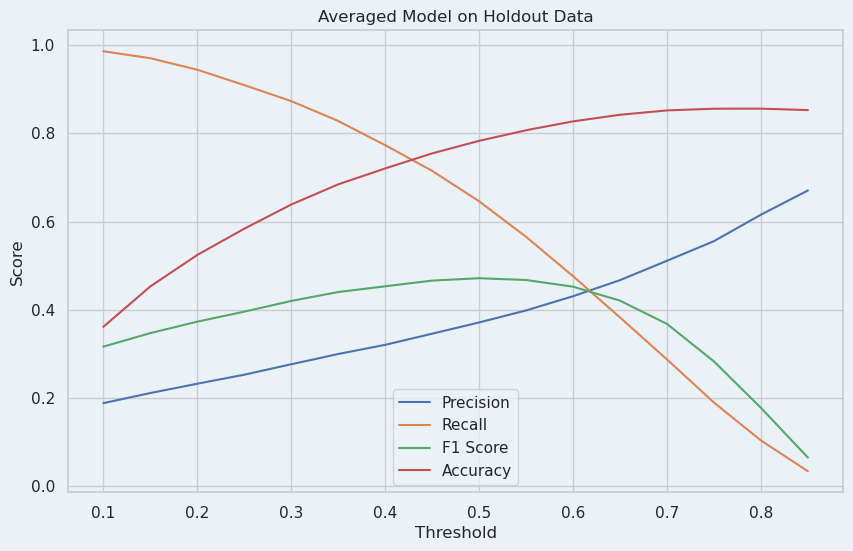

In [165]:
thresh_df, title = model_thresholds(averaged_model, X_holdout, y_holdout, 'Averaged Model on Holdout Data', showplot=True)
models_data.append((thresh_df, title))

# Save Model

* Use ONNX and make a single web page js with forms that will report your diabetes risk

## Wrappers


In [178]:
# See https://onnx.ai/sklearn-onnx/auto_tutorial/plot_gexternal_catboost.html
# the only place that had a converter for catboost that works
def skl2onnx_parser_catboost_classifier(scope, model, inputs, custom_parsers=None):
    options = scope.get_options(model, dict(zipmap=True))
    no_zipmap = isinstance(options["zipmap"], bool) and not options["zipmap"]

    alias = _get_sklearn_operator_name(type(model))
    this_operator = scope.declare_local_operator(alias, model)
    this_operator.inputs = inputs

    label_variable = scope.declare_local_variable("label", Int64TensorType())
    prob_dtype = guess_tensor_type(inputs[0].type)
    probability_tensor_variable = scope.declare_local_variable(
        "probabilities", prob_dtype
    )
    this_operator.outputs.append(label_variable)
    this_operator.outputs.append(probability_tensor_variable)
    probability_tensor = this_operator.outputs

    if no_zipmap:
        return probability_tensor

    return _apply_zipmap(
        options["zipmap"], scope, model, inputs[0].type, probability_tensor
    )

def skl2onnx_convert_catboost(scope, operator, container):
    onx = convert_to_onnx_object(operator.raw_operator)
    opsets = {d.domain: d.version for d in onx.opset_import}
    if "" in opsets and opsets[""] >= container.target_opset:
        raise RuntimeError("CatBoost uses an opset more recent than the target one.")
    if len(onx.graph.initializer) > 0 or len(onx.graph.sparse_initializer) > 0:
        raise NotImplementedError(
            "CatBoost returns a model initializers. This option is not implemented yet."
        )
    if (
        len(onx.graph.node) not in (1, 2)
        or not onx.graph.node[0].op_type.startswith("TreeEnsemble")
        or (len(onx.graph.node) == 2 and onx.graph.node[1].op_type != "ZipMap")
    ):
        types = ", ".join(map(lambda n: n.op_type, onx.graph.node))
        raise NotImplementedError(
            f"CatBoost returns {len(onx.graph.node)} != 1 (types={types}). "
            f"This option is not implemented yet."
        )
    node = onx.graph.node[0]
    atts = {}
    for att in node.attribute:
        atts[att.name] = get_attribute_value(att)
    container.add_node(
        node.op_type,
        [operator.inputs[0].full_name],
        [operator.outputs[0].full_name, operator.outputs[1].full_name],
        op_domain=node.domain,
        op_version=opsets.get(node.domain, None),
        **atts,
    )


## Register Converter

In [179]:
# Register the converter
update_registered_converter(
    CatBoostClassifier, 
    "CatBoostCatBoostClassifier", 
    calculate_linear_classifier_output_shapes, 
    skl2onnx_convert_catboost, 
    parser=skl2onnx_parser_catboost_classifier,
    options={"nocl": [True, False], "zipmap": [True, False, "columns"]}
)

## Convert Model To ONNX

In [180]:
# Define the input type based on your training data shape
initial_type = [("input", FloatTensorType([None, X_train.shape[1]]))]

# Set options to disable ZipMap
options = {
    CatBoostClassifier: {
        "zipmap": False  # Disable ZipMap
    }
}

# Convert the trained CatBoost model to ONNX with ZipMap disabled
model_onnx = convert_sklearn(
    full_catboost_model, 
    "catboost_model", 
    initial_types=initial_type,
    target_opset={"": 12, "ai.onnx.ml": 2},
    options=options  # Pass the options here
)

# Save the ONNX model to a file
with open("models/catboost_model_no_zipmap.onnx", "wb") as f:
    f.write(model_onnx.SerializeToString())

## Test ONNX

In [187]:
# Convert DataFrame to NumPy array and ensure float32 type
X_test_np = X_test.to_numpy().astype(np.float32)

# Load the ONNX model
sess = rt.InferenceSession("models/catboost_model_no_zipmap.onnx")

# Test with the converted NumPy array using the correct input name
pred_onx = sess.run(None, {"input": X_test_np})

# Print predictions
print("Predicted Labels:", pred_onx[0])
print("Predicted Probabilities:", pred_onx[1])

Predicted Labels: [0 0 1 ... 0 1 0]
Predicted Probabilities: [[0.787363   0.212637  ]
 [0.9632792  0.03672081]
 [0.3825944  0.6174056 ]
 ...
 [0.56989354 0.43010646]
 [0.42903703 0.57096297]
 [0.98135537 0.01864463]]


In [175]:
# Save the model in Core ML format
#full_catboost_model.save_model('models/catboost_model.onnx', format="onnx")

## Features List

In [176]:
X_holdout.info()

<class 'pandas.core.frame.DataFrame'>
Index: 45582 entries, 70838 to 51804
Data columns (total 30 columns):
 #   Column                                      Non-Null Count  Dtype
---  ------                                      --------------  -----
 0   HighBP                                      45582 non-null  bool 
 1   HighChol                                    45582 non-null  bool 
 2   CholCheck                                   45582 non-null  bool 
 3   BMI                                         45582 non-null  uint8
 4   Smoker                                      45582 non-null  bool 
 5   Stroke                                      45582 non-null  bool 
 6   HeartDiseaseorAttack                        45582 non-null  bool 
 7   PhysActivity                                45582 non-null  bool 
 8   Fruits                                      45582 non-null  bool 
 9   Veggies                                     45582 non-null  bool 
 10  HvyAlcoholConsump                  

In [189]:
X_train['GenHlth'].value_counts()

GenHlth
2    45954
3    43798
1    20812
4    18843
5     7337
Name: count, dtype: int64

In [190]:
display_variable_desc('GenHlth')

**GenHlth Description:**

Would you say that in general your health is: scale 1-5 1 = excellent 2 = very good 3 = good 4 = fair 5 = poor

In [191]:
display_variable_desc('Age')

**Age Description:**

13-level age category (_AGEG5YR see codebook) 1 = 18-24 9 = 60-64 13 = 80 or older

In [196]:
display_variable_desc('BMI')
display(X_train['BMI'])

**BMI Description:**

Body Mass Index

159405    22
131477    22
197069    34
167065    24
140625    26
          ..
235458    23
209865    24
22809     22
80519     27
29105     23
Name: BMI, Length: 136744, dtype: uint8